In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2022/Especialidad Prueba B.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=130.0, y1=139.9
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 312
Page 1, Q1, A: Yellow percentage: 0.0%


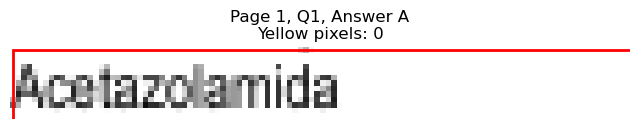

Page 1, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=115.5, y1=152.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 259
Page 1, Q1, B: Yellow percentage: 0.0%


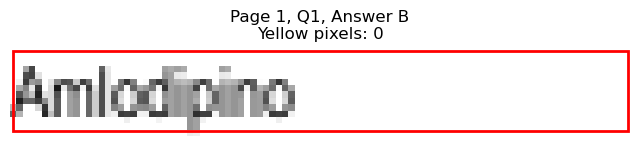

Page 1, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=111.4, y1=165.2
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 230
Page 1, Q1, C: Yellow percentage: 0.0%


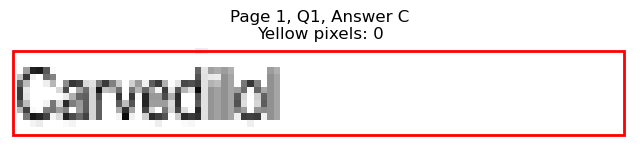

Page 1, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=394.7, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 356
Page 1, Q1, D: Yellow percentage: 0.0%


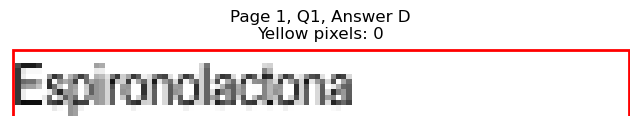

Page 1, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=388.7, y1=152.6
Page 1, Q1, E: Yellow pixels: 1212
Page 1, Q1, E: Total non-white pixels: 1568
Page 1, Q1, E: Yellow percentage: 77.3%


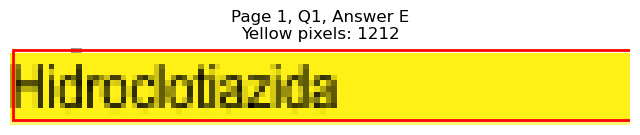


Page 1, Q1 - Selected Answer: E (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=109.5, y1=203.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 221
Page 1, Q2, A: Yellow percentage: 0.0%


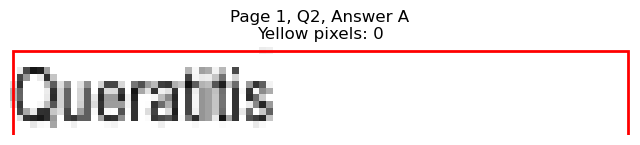

Page 1, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=106.9, y1=215.6
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 198
Page 1, Q2, B: Yellow percentage: 0.0%


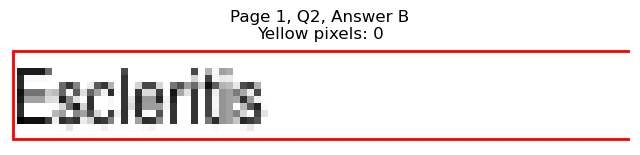

Page 1, Q2 - C: Detected box: x0=68.8, y0=215.7, x1=149.5, y1=228.3
Page 1, Q2, C: Yellow pixels: 1234
Page 1, Q2, C: Total non-white pixels: 1848
Page 1, Q2, C: Yellow percentage: 66.8%


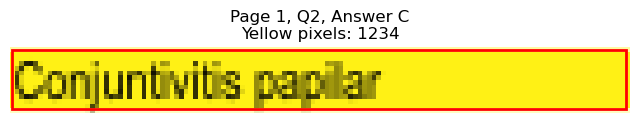

Page 1, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=433.9, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 524
Page 1, Q2, D: Yellow percentage: 0.0%


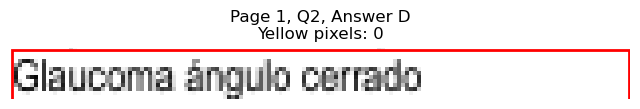

Page 1, Q2 - E: Detected box: x0=327.0, y0=202.9, x1=430.4, y1=215.6
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 533
Page 1, Q2, E: Yellow percentage: 0.0%


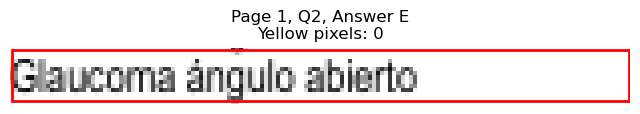


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=157.6, y1=278.7
Page 1, Q3, A: Yellow pixels: 1453
Page 1, Q3, A: Total non-white pixels: 1820
Page 1, Q3, A: Yellow percentage: 79.8%


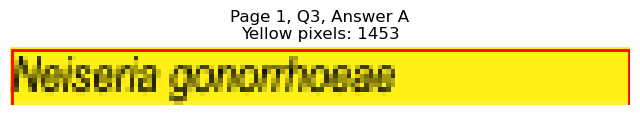

Page 1, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=155.1, y1=291.5
Page 1, Q3, B: Yellow pixels: 136
Page 1, Q3, B: Total non-white pixels: 567
Page 1, Q3, B: Yellow percentage: 24.0%


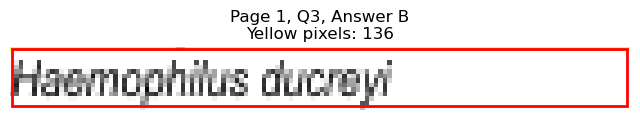

Page 1, Q3 - C: Detected box: x0=68.8, y0=291.4, x1=146.5, y1=304.1
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 370
Page 1, Q3, C: Yellow percentage: 0.0%


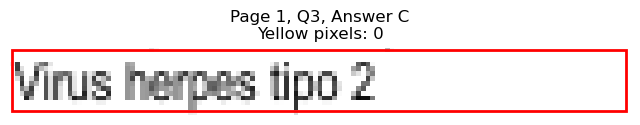

Page 1, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=389.2, y1=278.7
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 293
Page 1, Q3, D: Yellow percentage: 0.0%


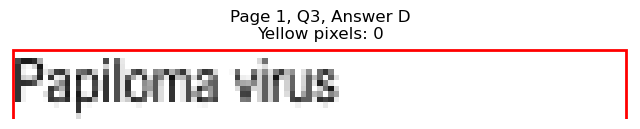

Page 1, Q3 - E: Detected box: x0=327.0, y0=278.8, x1=411.8, y1=291.5
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 428
Page 1, Q3, E: Yellow percentage: 0.0%


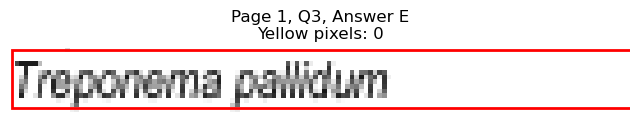


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=158.5, y1=354.6
Page 1, Q4, A: Yellow pixels: 141
Page 1, Q4, A: Total non-white pixels: 622
Page 1, Q4, A: Yellow percentage: 22.7%


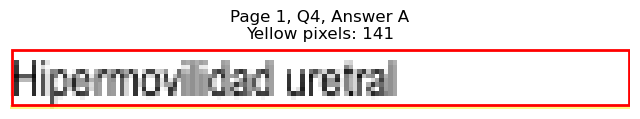

Page 1, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=142.0, y1=367.2
Page 1, Q4, B: Yellow pixels: 1281
Page 1, Q4, B: Total non-white pixels: 1736
Page 1, Q4, B: Yellow percentage: 73.8%


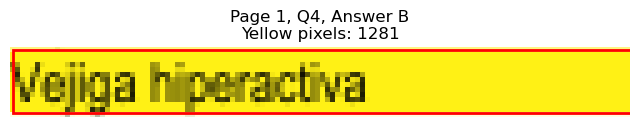

Page 1, Q4 - C: Detected box: x0=68.8, y0=367.1, x1=158.1, y1=379.8
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 585
Page 1, Q4, C: Yellow percentage: 0.0%


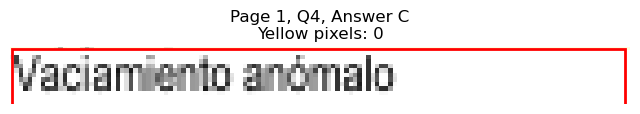

Page 1, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=437.3, y1=354.6
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 586
Page 1, Q4, D: Yellow percentage: 0.0%


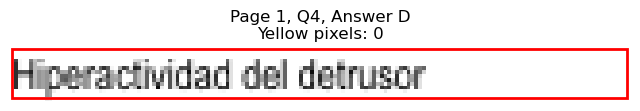

Page 1, Q4 - E: Detected box: x0=327.0, y0=354.5, x1=439.4, y1=367.2
Page 1, Q4, E: Yellow pixels: 0
Page 1, Q4, E: Total non-white pixels: 567
Page 1, Q4, E: Yellow percentage: 0.0%


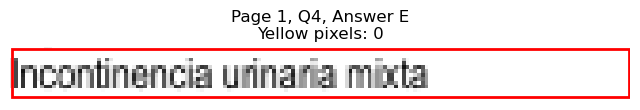


Page 1, Q4 - Selected Answer: B (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=251.3, y1=417.6
Page 1, Q5, A: Yellow pixels: 2072
Page 1, Q5, A: Total non-white pixels: 2996
Page 1, Q5, A: Yellow percentage: 69.2%


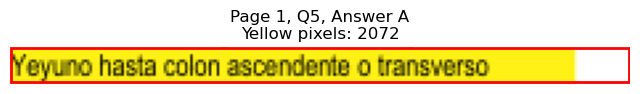

Page 1, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=154.1, y1=430.3
Page 1, Q5, B: Yellow pixels: 136
Page 1, Q5, B: Total non-white pixels: 531
Page 1, Q5, B: Yellow percentage: 25.6%


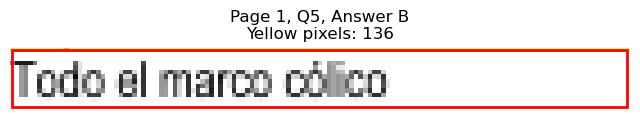

Page 1, Q5 - C: Detected box: x0=68.8, y0=430.2, x1=162.1, y1=442.9
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 401
Page 1, Q5, C: Yellow percentage: 0.0%


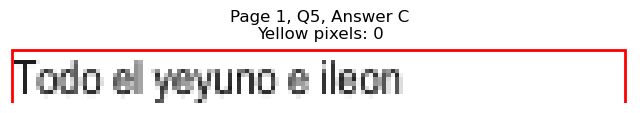

Page 1, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=462.9, y1=417.6
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 654
Page 1, Q5, D: Yellow percentage: 0.0%


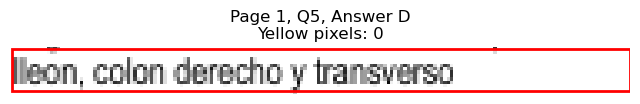

Page 1, Q5 - E: Detected box: x0=327.0, y0=417.6, x1=429.4, y1=430.3
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 486
Page 1, Q5, E: Yellow percentage: 0.0%


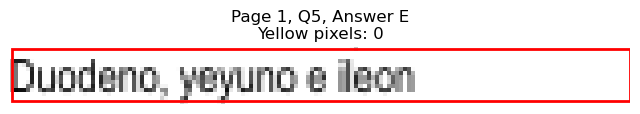


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=506.0, x1=164.1, y1=518.6
Page 1, Q6, A: Yellow pixels: 1483
Page 1, Q6, A: Total non-white pixels: 2058
Page 1, Q6, A: Yellow percentage: 72.1%


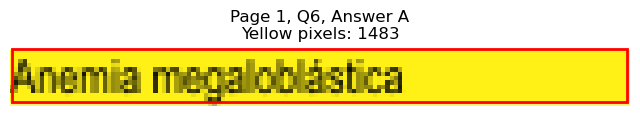

Page 1, Q6 - B: Detected box: x0=68.3, y0=518.6, x1=161.5, y1=531.2
Page 1, Q6, B: Yellow pixels: 143
Page 1, Q6, B: Total non-white pixels: 624
Page 1, Q6, B: Yellow percentage: 22.9%


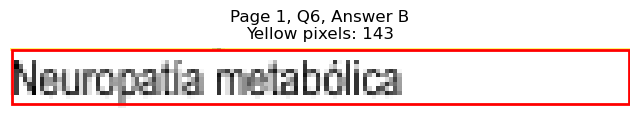

Page 1, Q6 - C: Detected box: x0=68.8, y0=531.2, x1=167.1, y1=543.8
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 481
Page 1, Q6, C: Yellow percentage: 0.0%


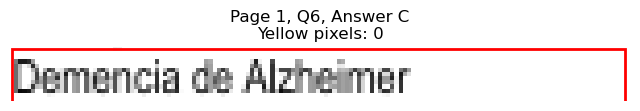

Page 1, Q6 - D: Detected box: x0=327.5, y0=506.0, x1=415.3, y1=518.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 444
Page 1, Q6, D: Yellow percentage: 0.0%


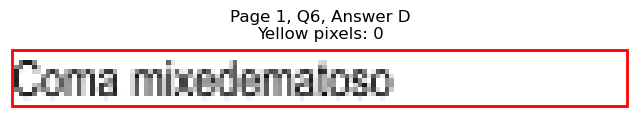

Page 1, Q6 - E: Detected box: x0=327.0, y0=518.6, x1=386.7, y1=531.2
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 315
Page 1, Q6, E: Yellow percentage: 0.0%


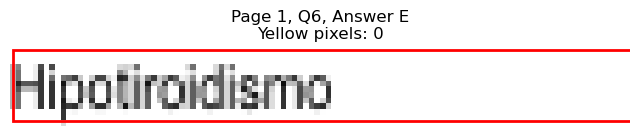


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=581.7, x1=115.5, y1=594.4
Page 1, Q7, A: Yellow pixels: 999
Page 1, Q7, A: Total non-white pixels: 1372
Page 1, Q7, A: Yellow percentage: 72.8%


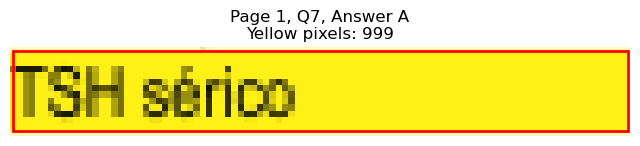

Page 1, Q7 - B: Detected box: x0=68.3, y0=594.3, x1=119.9, y1=607.0
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 328
Page 1, Q7, B: Yellow percentage: 0.0%


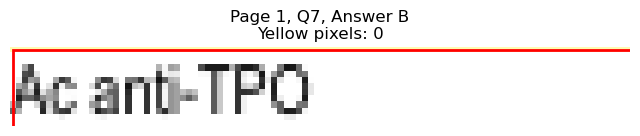

Page 1, Q7 - C: Detected box: x0=68.8, y0=606.9, x1=101.4, y1=619.6
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 154
Page 1, Q7, C: Yellow percentage: 0.0%


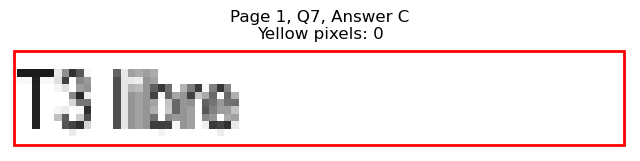

Page 1, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=389.7, y1=594.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 338
Page 1, Q7, D: Yellow percentage: 0.0%


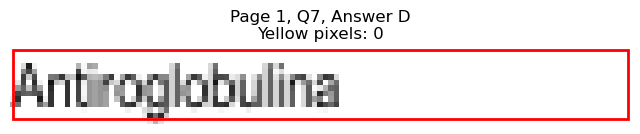

Page 1, Q7 - E: Detected box: x0=327.0, y0=594.3, x1=400.3, y1=607.0
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 386
Page 1, Q7, E: Yellow percentage: 0.0%


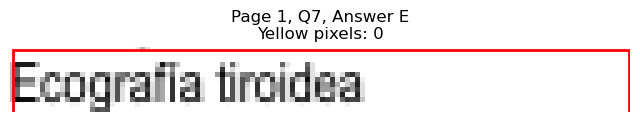


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=644.9, x1=154.1, y1=657.5
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 415
Page 1, Q8, A: Yellow percentage: 0.0%


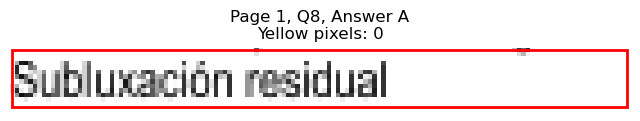

Page 1, Q8 - B: Detected box: x0=68.3, y0=657.5, x1=152.1, y1=670.1
Page 1, Q8, B: Yellow pixels: 135
Page 1, Q8, B: Total non-white pixels: 548
Page 1, Q8, B: Yellow percentage: 24.6%


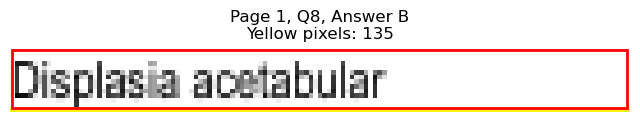

Page 1, Q8 - C: Detected box: x0=68.8, y0=670.1, x1=232.8, y1=682.7
Page 1, Q8, C: Yellow pixels: 2107
Page 1, Q8, C: Total non-white pixels: 2782
Page 1, Q8, C: Yellow percentage: 75.7%


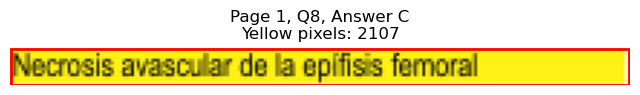

Page 1, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=374.7, y1=657.5
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 249
Page 1, Q8, D: Yellow percentage: 0.0%


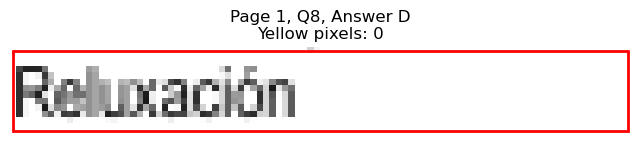

Page 1, Q8 - E: Detected box: x0=327.0, y0=657.5, x1=402.8, y1=670.1
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 411
Page 1, Q8, E: Yellow percentage: 0.0%


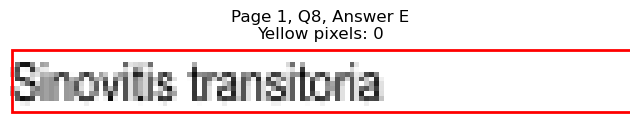


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=104.4, y1=139.9
Page 2, Q1, A: Yellow pixels: 983
Page 2, Q1, A: Total non-white pixels: 1131
Page 2, Q1, A: Yellow percentage: 86.9%


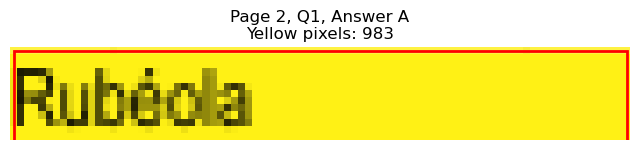

Page 2, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=109.5, y1=152.6
Page 2, Q1, B: Yellow pixels: 92
Page 2, Q1, B: Total non-white pixels: 302
Page 2, Q1, B: Yellow percentage: 30.5%


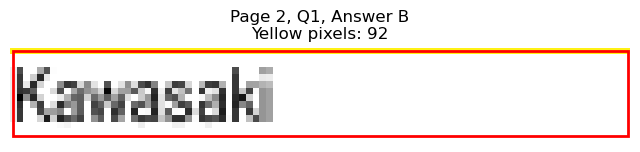

Page 2, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=131.4, y1=165.2
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 312
Page 2, Q1, C: Yellow percentage: 0.0%


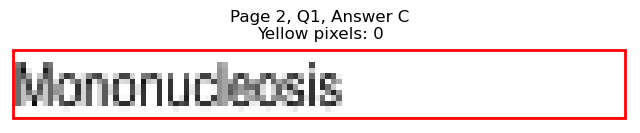

Page 2, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=373.7, y1=139.9
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 233
Page 2, Q1, D: Yellow percentage: 0.0%


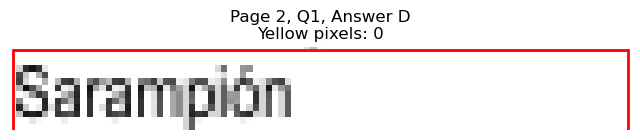

Page 2, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=403.3, y1=152.6
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 400
Page 2, Q1, E: Yellow percentage: 0.0%


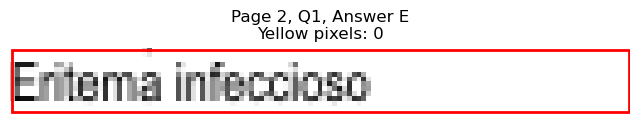


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=105.4, y1=215.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 190
Page 2, Q2, A: Yellow percentage: 0.0%


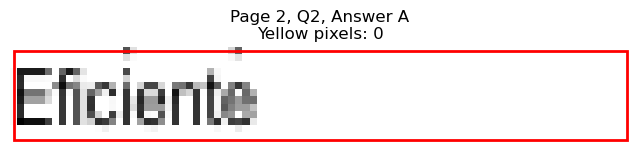

Page 2, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=101.9, y1=228.3
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 165
Page 2, Q2, B: Yellow percentage: 0.0%


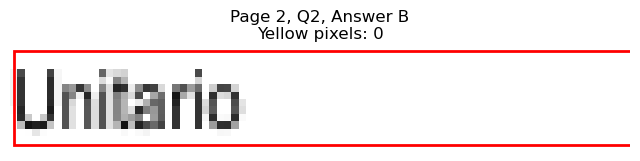

Page 2, Q2 - C: Detected box: x0=68.8, y0=228.3, x1=136.0, y1=240.9
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 350
Page 2, Q2, C: Yellow percentage: 0.0%


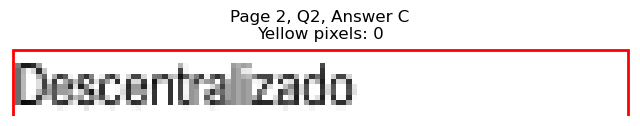

Page 2, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=358.6, y1=215.6
Page 2, Q2, D: Yellow pixels: 951
Page 2, Q2, D: Total non-white pixels: 1148
Page 2, Q2, D: Yellow percentage: 82.8%


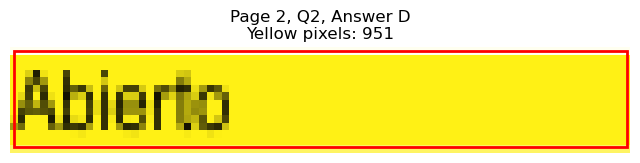

Page 2, Q2 - E: Detected box: x0=327.0, y0=215.7, x1=422.8, y1=228.3
Page 2, Q2, E: Yellow pixels: 146
Page 2, Q2, E: Total non-white pixels: 624
Page 2, Q2, E: Yellow percentage: 23.4%


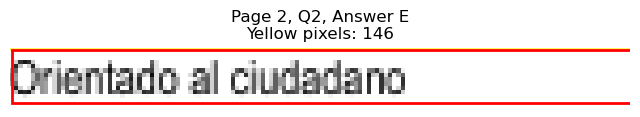


Page 2, Q2 - Selected Answer: D (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=121.0, y1=291.5
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 250
Page 2, Q3, A: Yellow percentage: 0.0%


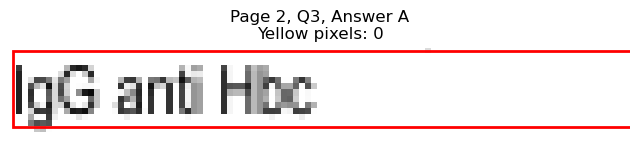

Page 2, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=121.5, y1=304.1
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 259
Page 2, Q3, B: Yellow percentage: 0.0%


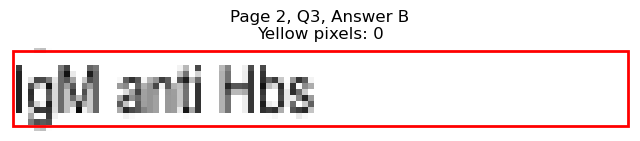

Page 2, Q3 - C: Detected box: x0=68.8, y0=304.0, x1=122.4, y1=316.7
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 279
Page 2, Q3, C: Yellow percentage: 0.0%


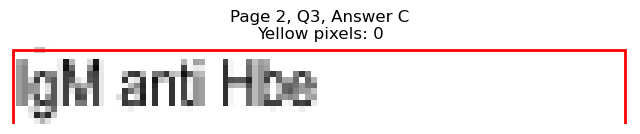

Page 2, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=380.7, y1=291.5
Page 2, Q3, D: Yellow pixels: 104
Page 2, Q3, D: Total non-white pixels: 373
Page 2, Q3, D: Yellow percentage: 27.9%


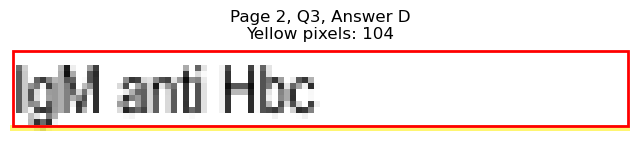

Page 2, Q3 - E: Detected box: x0=327.0, y0=291.4, x1=379.7, y1=304.1
Page 2, Q3, E: Yellow pixels: 1160
Page 2, Q3, E: Total non-white pixels: 1442
Page 2, Q3, E: Yellow percentage: 80.4%


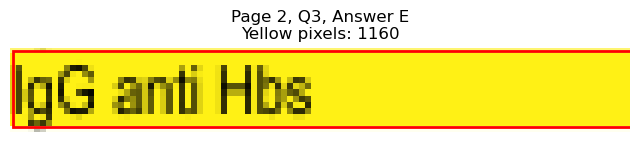


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=379.7, x1=102.9, y1=392.4
Page 2, Q4, A: Yellow pixels: 85
Page 2, Q4, A: Total non-white pixels: 262
Page 2, Q4, A: Yellow percentage: 32.4%


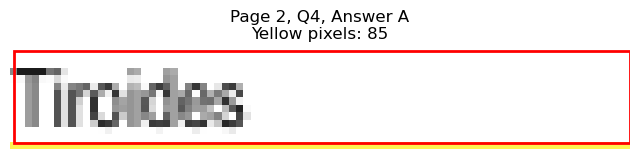

Page 2, Q4 - B: Detected box: x0=68.3, y0=392.3, x1=92.9, y1=405.0
Page 2, Q4, B: Yellow pixels: 879
Page 2, Q4, B: Total non-white pixels: 975
Page 2, Q4, B: Yellow percentage: 90.2%


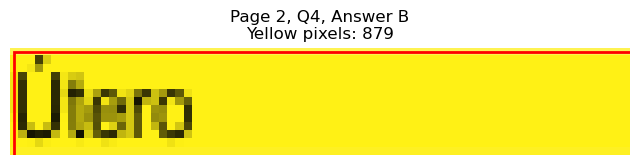

Page 2, Q4 - C: Detected box: x0=68.8, y0=404.9, x1=97.8, y1=417.6
Page 2, Q4, C: Yellow pixels: 80
Page 2, Q4, C: Total non-white pixels: 205
Page 2, Q4, C: Yellow percentage: 39.0%


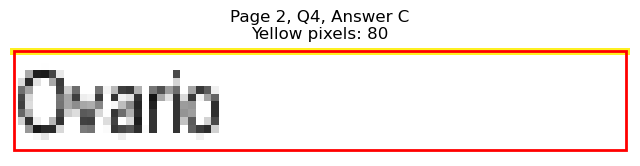

Page 2, Q4 - D: Detected box: x0=327.5, y0=379.7, x1=375.7, y1=392.4
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 262
Page 2, Q4, D: Yellow percentage: 0.0%


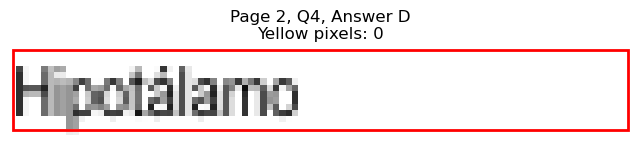

Page 2, Q4 - E: Detected box: x0=327.0, y0=392.3, x1=363.7, y1=405.0
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 200
Page 2, Q4, E: Yellow percentage: 0.0%


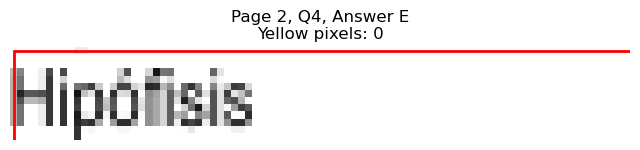


Page 2, Q4 - Selected Answer: B (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=455.5, x1=109.9, y1=468.1
Page 2, Q5, A: Yellow pixels: 92
Page 2, Q5, A: Total non-white pixels: 298
Page 2, Q5, A: Yellow percentage: 30.9%


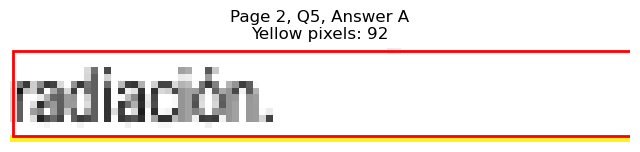

Page 2, Q5 - B: Detected box: x0=68.3, y0=468.1, x1=118.9, y1=480.7
Page 2, Q5, B: Yellow pixels: 1108
Page 2, Q5, B: Total non-white pixels: 1313
Page 2, Q5, B: Yellow percentage: 84.4%


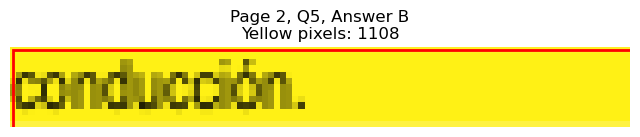

Page 2, Q5 - C: Detected box: x0=68.8, y0=480.8, x1=122.9, y1=493.4
Page 2, Q5, C: Yellow pixels: 105
Page 2, Q5, C: Total non-white pixels: 364
Page 2, Q5, C: Yellow percentage: 28.8%


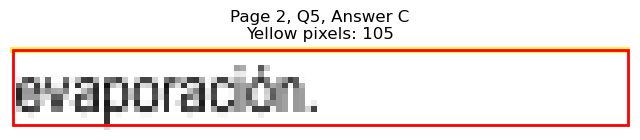

Page 2, Q5 - D: Detected box: x0=327.5, y0=455.5, x1=384.2, y1=468.1
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 291
Page 2, Q5, D: Yellow percentage: 0.0%


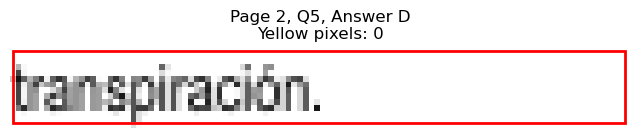

Page 2, Q5 - E: Detected box: x0=327.0, y0=468.1, x1=377.2, y1=480.7
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 237
Page 2, Q5, E: Yellow percentage: 0.0%


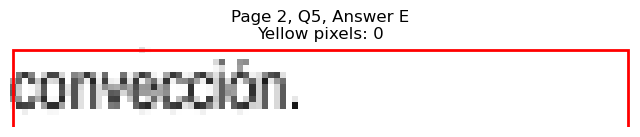


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=531.2, x1=115.0, y1=543.8
Page 2, Q6, A: Yellow pixels: 1086
Page 2, Q6, A: Total non-white pixels: 1261
Page 2, Q6, A: Yellow percentage: 86.1%


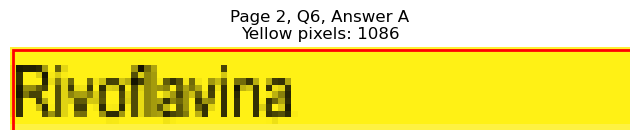

Page 2, Q6 - B: Detected box: x0=68.3, y0=543.8, x1=114.5, y1=556.4
Page 2, Q6, B: Yellow pixels: 97
Page 2, Q6, B: Total non-white pixels: 294
Page 2, Q6, B: Yellow percentage: 33.0%


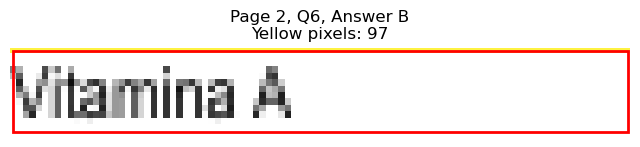

Page 2, Q6 - C: Detected box: x0=68.8, y0=556.5, x1=143.1, y1=569.2
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 394
Page 2, Q6, C: Yellow percentage: 0.0%


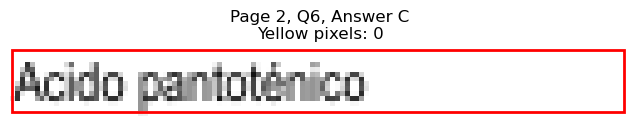

Page 2, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=393.8, y1=543.8
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 333
Page 2, Q6, D: Yellow percentage: 0.0%


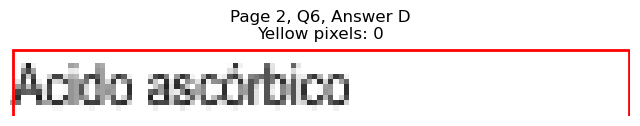

Page 2, Q6 - E: Detected box: x0=327.0, y0=543.8, x1=361.6, y1=556.4
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 161
Page 2, Q6, E: Yellow percentage: 0.0%


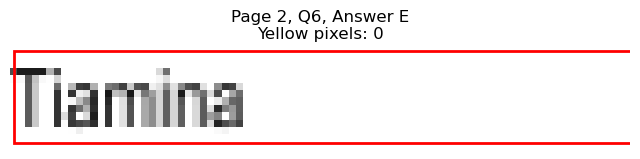


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=619.6, x1=95.4, y1=632.3
Page 2, Q7, A: Yellow pixels: 839
Page 2, Q7, A: Total non-white pixels: 1092
Page 2, Q7, A: Yellow percentage: 76.8%


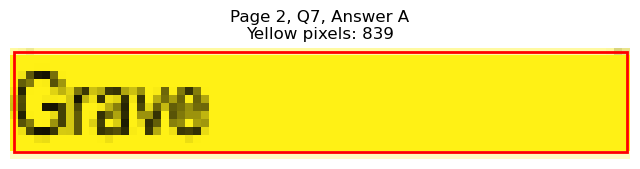

Page 2, Q7 - B: Detected box: x0=68.3, y0=632.2, x1=111.4, y1=644.9
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 333
Page 2, Q7, B: Yellow percentage: 0.0%


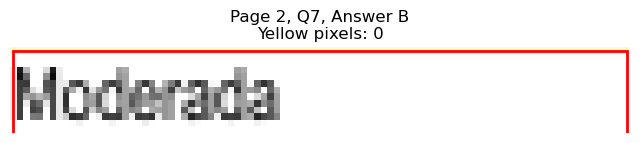

Page 2, Q7 - C: Detected box: x0=68.8, y0=644.9, x1=109.0, y1=657.5
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 202
Page 2, Q7, C: Yellow percentage: 0.0%


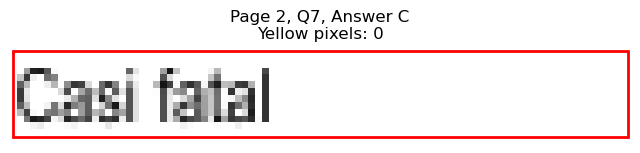

Page 2, Q7 - D: Detected box: x0=327.5, y0=619.6, x1=358.6, y1=632.3
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 154
Page 2, Q7, D: Yellow percentage: 0.0%


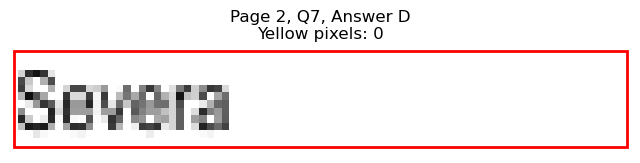

Page 2, Q7 - E: Detected box: x0=327.0, y0=632.2, x1=349.1, y1=644.9
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 94
Page 2, Q7, E: Yellow percentage: 0.0%


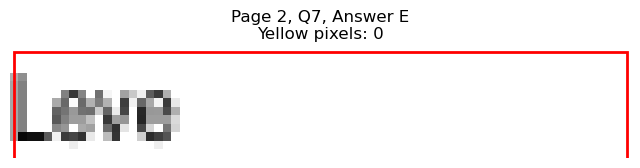


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=708.0, x1=171.1, y1=720.6
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 534
Page 2, Q8, A: Yellow percentage: 0.0%


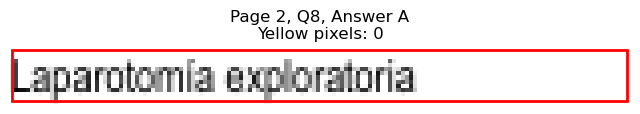

Page 2, Q8 - B: Detected box: x0=68.3, y0=720.6, x1=167.5, y1=733.2
Page 2, Q8, B: Yellow pixels: 150
Page 2, Q8, B: Total non-white pixels: 668
Page 2, Q8, B: Yellow percentage: 22.5%


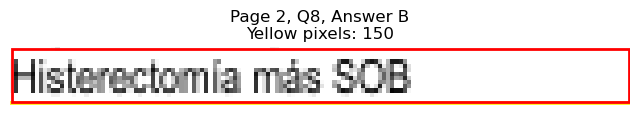

Page 2, Q8 - C: Detected box: x0=68.8, y0=733.2, x1=181.8, y1=745.8
Page 2, Q8, C: Yellow pixels: 1705
Page 2, Q8, C: Total non-white pixels: 2132
Page 2, Q8, C: Yellow percentage: 80.0%


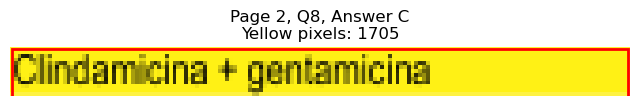

Page 2, Q8 - D: Detected box: x0=327.5, y0=708.0, x1=409.3, y1=720.6
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 423
Page 2, Q8, D: Yellow percentage: 0.0%


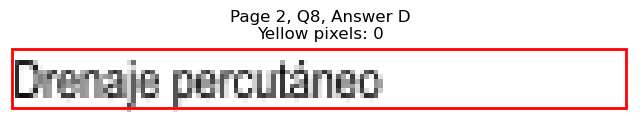

Page 2, Q8 - E: Detected box: x0=327.0, y0=720.6, x1=409.8, y1=733.2
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 442
Page 2, Q8, E: Yellow percentage: 0.0%


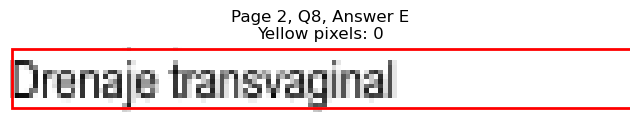


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=80.9, y1=114.7
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 47
Page 3, Q1, A: Yellow percentage: 0.0%


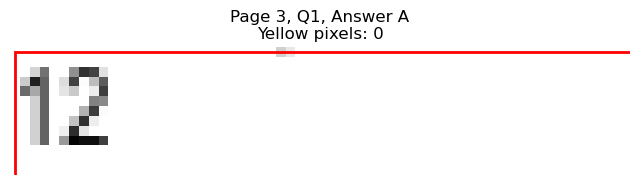

Page 3, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=65.2, y1=127.3
Page 3, Q1, B: Yellow pixels: 60
Page 3, Q1, B: Total non-white pixels: 136
Page 3, Q1, B: Yellow percentage: 44.1%


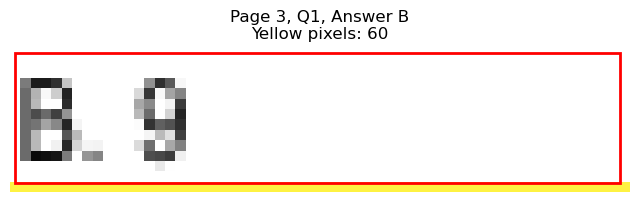

Page 3, Q1 - C: Detected box: x0=68.8, y0=127.2, x1=81.4, y1=139.9
Page 3, Q1, C: Yellow pixels: 795
Page 3, Q1, C: Total non-white pixels: 832
Page 3, Q1, C: Yellow percentage: 95.6%


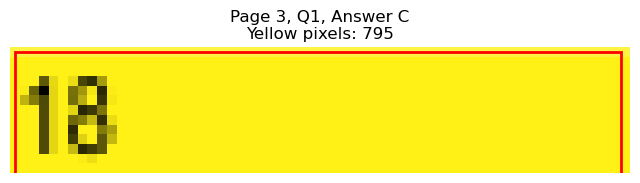

Page 3, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=340.1, y1=114.7
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 44
Page 3, Q1, D: Yellow percentage: 0.0%


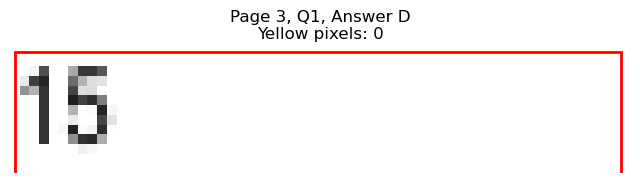

Page 3, Q1 - E: Detected box: x0=315.4, y0=114.6, x1=323.9, y1=127.3
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 69
Page 3, Q1, E: Yellow percentage: 0.0%


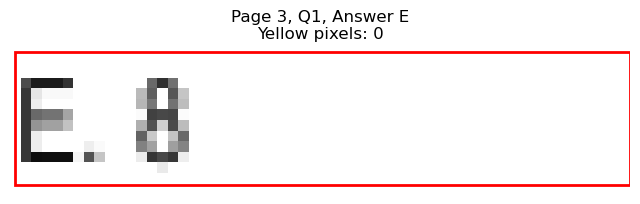


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=115.0, y1=203.0
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 212
Page 3, Q2, A: Yellow percentage: 0.0%


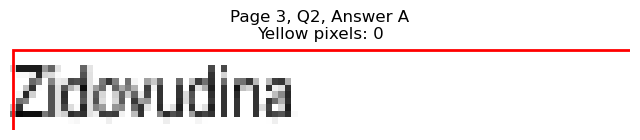

Page 3, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=106.5, y1=215.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 201
Page 3, Q2, B: Yellow percentage: 0.0%


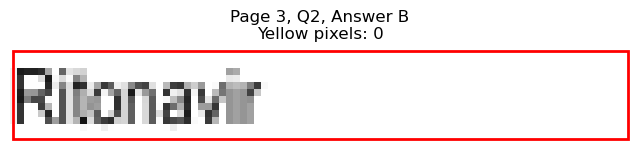

Page 3, Q2 - C: Detected box: x0=68.8, y0=215.7, x1=124.0, y1=228.3
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 269
Page 3, Q2, C: Yellow percentage: 0.0%


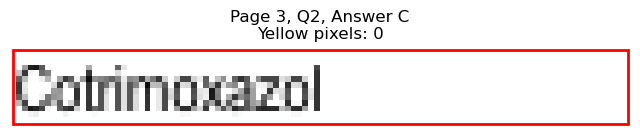

Page 3, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=381.2, y1=203.0
Page 3, Q2, D: Yellow pixels: 1155
Page 3, Q2, D: Total non-white pixels: 1365
Page 3, Q2, D: Yellow percentage: 84.6%


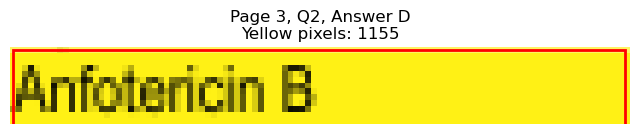

Page 3, Q2 - E: Detected box: x0=327.0, y0=202.9, x1=375.7, y1=215.6
Page 3, Q2, E: Yellow pixels: 99
Page 3, Q2, E: Total non-white pixels: 339
Page 3, Q2, E: Yellow percentage: 29.2%


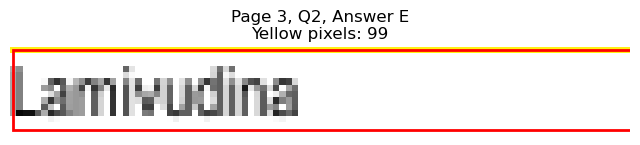


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=291.4, x1=121.5, y1=304.1
Page 3, Q3, A: Yellow pixels: 1143
Page 3, Q3, A: Total non-white pixels: 1456
Page 3, Q3, A: Yellow percentage: 78.5%


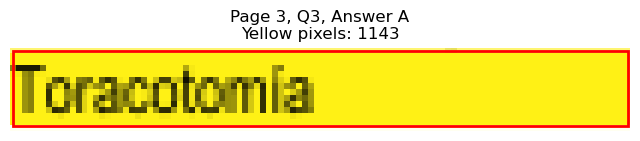

Page 3, Q3 - B: Detected box: x0=68.3, y0=304.0, x1=196.7, y1=316.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 828
Page 3, Q3, B: Yellow percentage: 0.0%


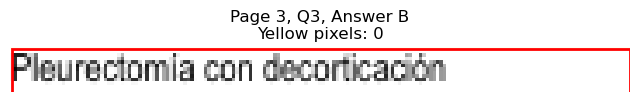

Page 3, Q3 - C: Detected box: x0=68.8, y0=316.6, x1=248.8, y1=329.3
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 851
Page 3, Q3, C: Yellow percentage: 0.0%


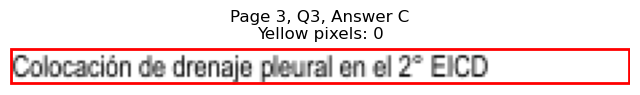

Page 3, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=421.9, y1=304.1
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 493
Page 3, Q3, D: Yellow percentage: 0.0%


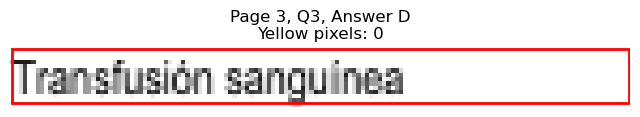

Page 3, Q3 - E: Detected box: x0=327.0, y0=304.0, x1=488.1, y1=316.7
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 783
Page 3, Q3, E: Yellow percentage: 0.0%


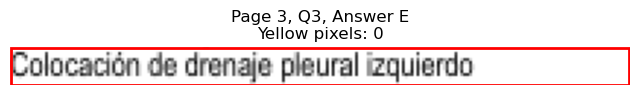


Page 3, Q3 - Selected Answer: A (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=123.0, y1=379.8
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 261
Page 3, Q4, A: Yellow percentage: 0.0%


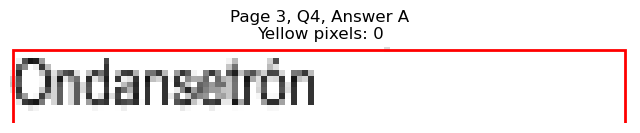

Page 3, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=121.5, y1=392.4
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 272
Page 3, Q4, B: Yellow percentage: 0.0%


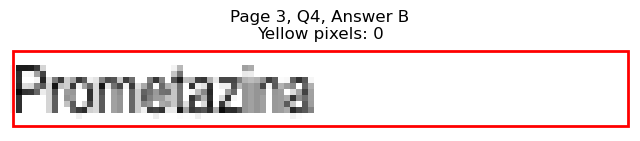

Page 3, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=135.5, y1=405.0
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 350
Page 3, Q4, C: Yellow percentage: 0.0%


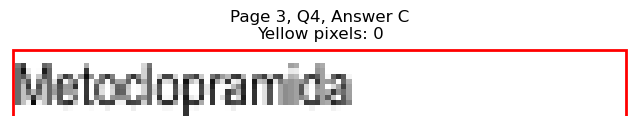

Page 3, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=400.7, y1=379.8
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 526
Page 3, Q4, D: Yellow percentage: 0.0%


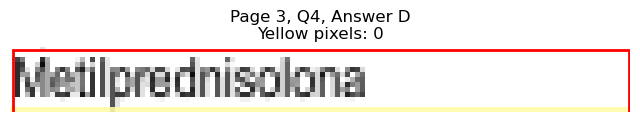

Page 3, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=378.2, y1=392.4
Page 3, Q4, E: Yellow pixels: 1013
Page 3, Q4, E: Total non-white pixels: 1428
Page 3, Q4, E: Yellow percentage: 70.9%


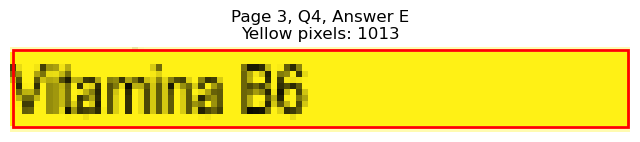


Page 3, Q4 - Selected Answer: E (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=138.5, y1=455.5
Page 3, Q5, A: Yellow pixels: 1273
Page 3, Q5, A: Total non-white pixels: 1694
Page 3, Q5, A: Yellow percentage: 75.1%


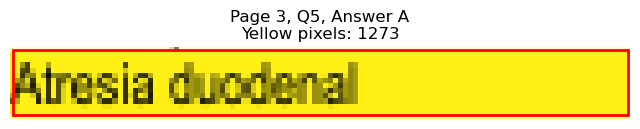

Page 3, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=124.0, y1=468.1
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 246
Page 3, Q5, B: Yellow percentage: 0.0%


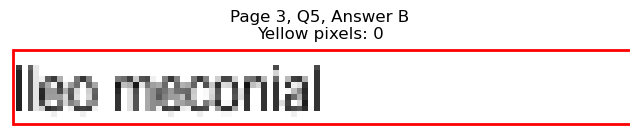

Page 3, Q5 - C: Detected box: x0=68.8, y0=468.1, x1=156.0, y1=480.7
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 445
Page 3, Q5, C: Yellow percentage: 0.0%


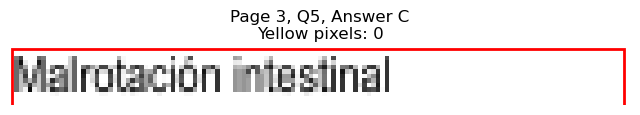

Page 3, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=414.8, y1=455.5
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 487
Page 3, Q5, D: Yellow percentage: 0.0%


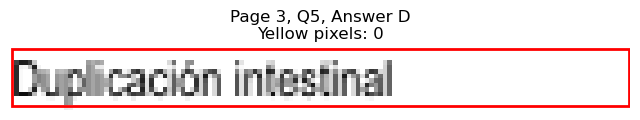

Page 3, Q5 - E: Detected box: x0=327.0, y0=455.5, x1=391.3, y1=468.1
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 336
Page 3, Q5, E: Yellow percentage: 0.0%


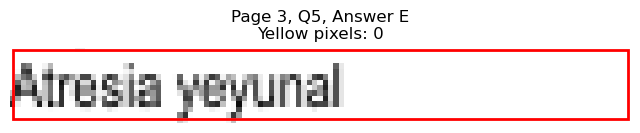


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=531.2, x1=120.5, y1=543.8
Page 3, Q6, A: Yellow pixels: 1147
Page 3, Q6, A: Total non-white pixels: 1339
Page 3, Q6, A: Yellow percentage: 85.7%


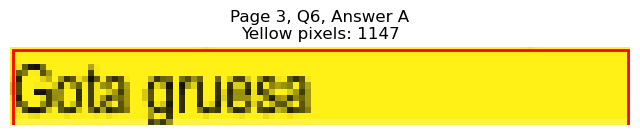

Page 3, Q6 - B: Detected box: x0=68.3, y0=543.8, x1=120.5, y1=556.4
Page 3, Q6, B: Yellow pixels: 99
Page 3, Q6, B: Total non-white pixels: 369
Page 3, Q6, B: Yellow percentage: 26.8%


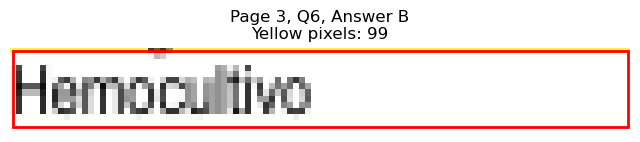

Page 3, Q6 - C: Detected box: x0=68.8, y0=556.5, x1=110.9, y1=569.2
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 203
Page 3, Q6, C: Yellow percentage: 0.0%


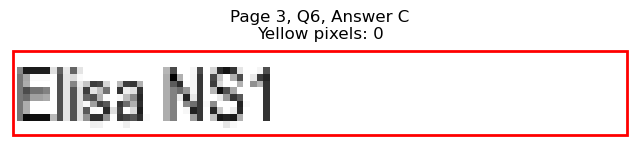

Page 3, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=399.3, y1=543.8
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 375
Page 3, Q6, D: Yellow percentage: 0.0%


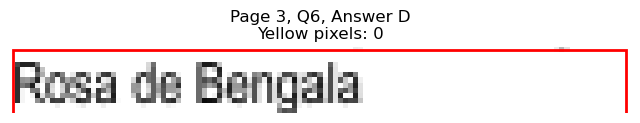

Page 3, Q6 - E: Detected box: x0=327.0, y0=543.8, x1=388.3, y1=556.4
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 340
Page 3, Q6, E: Yellow percentage: 0.0%


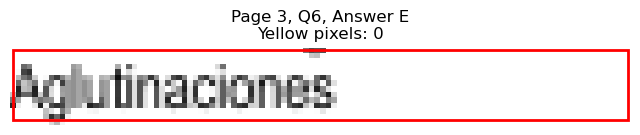


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=632.2, x1=173.7, y1=644.9
Page 3, Q7, A: Yellow pixels: 1596
Page 3, Q7, A: Total non-white pixels: 2028
Page 3, Q7, A: Yellow percentage: 78.7%


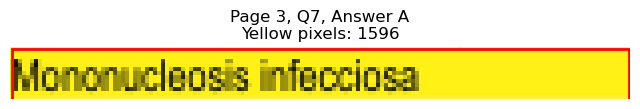

Page 3, Q7 - B: Detected box: x0=68.3, y0=644.9, x1=173.7, y1=657.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 529
Page 3, Q7, B: Yellow percentage: 0.0%


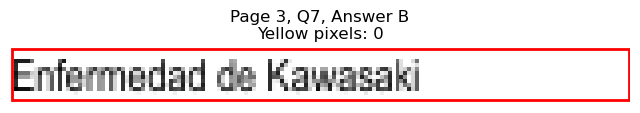

Page 3, Q7 - C: Detected box: x0=68.8, y0=657.5, x1=104.9, y1=670.1
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 182
Page 3, Q7, C: Yellow percentage: 0.0%


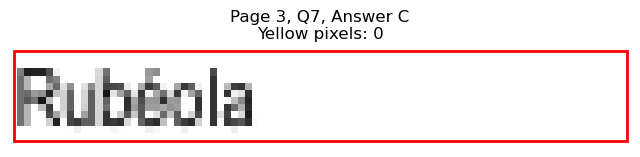

Page 3, Q7 - D: Detected box: x0=327.5, y0=632.2, x1=373.7, y1=644.9
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 230
Page 3, Q7, D: Yellow percentage: 0.0%


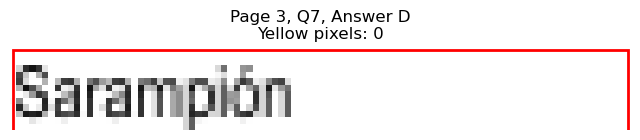

Page 3, Q7 - E: Detected box: x0=327.0, y0=644.9, x1=401.3, y1=657.5
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 380
Page 3, Q7, E: Yellow percentage: 0.0%


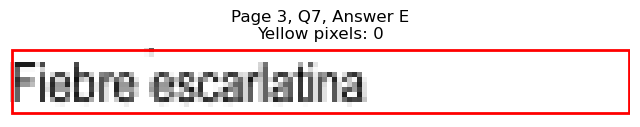


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=720.6, x1=173.7, y1=733.2
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 504
Page 3, Q8, A: Yellow percentage: 0.0%


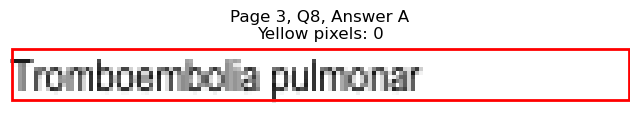

Page 3, Q8 - B: Detected box: x0=68.3, y0=733.2, x1=173.7, y1=745.8
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 495
Page 3, Q8, B: Yellow percentage: 0.0%


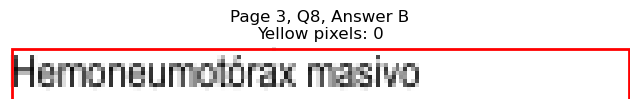

Page 3, Q8 - C: Detected box: x0=68.8, y0=745.8, x1=115.5, y1=758.4
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 237
Page 3, Q8, C: Yellow percentage: 0.0%


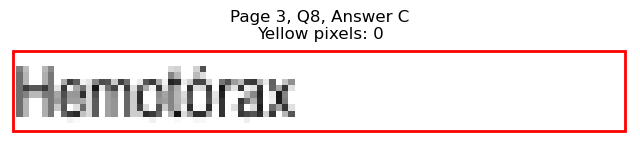

Page 3, Q8 - D: Detected box: x0=327.5, y0=720.6, x1=418.3, y1=733.2
Page 3, Q8, D: Yellow pixels: 1482
Page 3, Q8, D: Total non-white pixels: 1988
Page 3, Q8, D: Yellow percentage: 74.5%


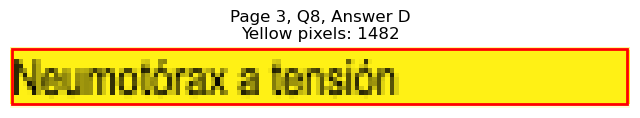

Page 3, Q8 - E: Detected box: x0=327.0, y0=733.2, x1=407.3, y1=745.8
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 533
Page 3, Q8, E: Yellow percentage: 0.0%


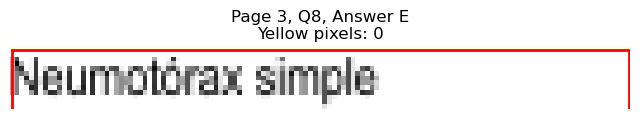


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 8 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=222.9, y1=139.9
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 743
Page 4, Q1, A: Yellow percentage: 0.0%


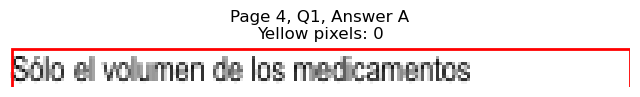

Page 4, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=175.2, y1=152.6
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 536
Page 4, Q1, B: Yellow percentage: 0.0%


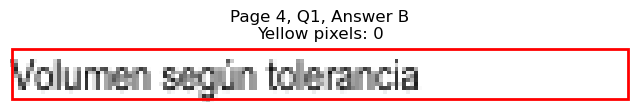

Page 4, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=215.8, y1=165.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 735
Page 4, Q1, C: Yellow percentage: 0.0%


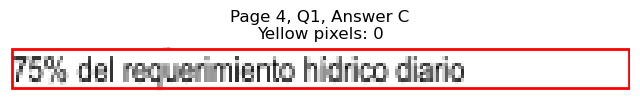

Page 4, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=493.2, y1=139.9
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 827
Page 4, Q1, D: Yellow percentage: 0.0%


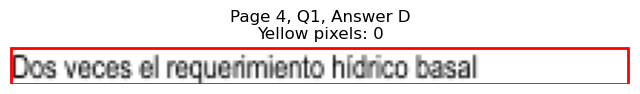

Page 4, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=474.1, y1=152.6
Page 4, Q1, E: Yellow pixels: 2008
Page 4, Q1, E: Total non-white pixels: 2772
Page 4, Q1, E: Yellow percentage: 72.4%


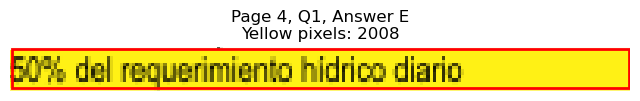


Page 4, Q1 - Selected Answer: E (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=145.1, y1=215.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 395
Page 4, Q2, A: Yellow percentage: 0.0%


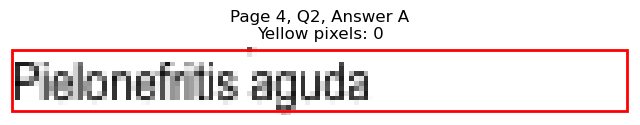

Page 4, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=167.1, y1=228.3
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 489
Page 4, Q2, B: Yellow percentage: 0.0%


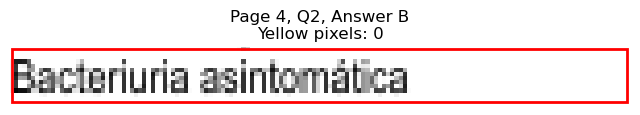

Page 4, Q2 - C: Detected box: x0=68.8, y0=228.3, x1=132.0, y1=240.9
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 297
Page 4, Q2, C: Yellow percentage: 0.0%


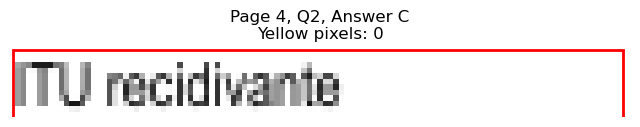

Page 4, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=392.7, y1=215.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 335
Page 4, Q2, D: Yellow percentage: 0.0%


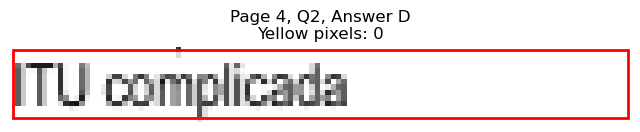

Page 4, Q2 - E: Detected box: x0=327.0, y0=215.7, x1=387.8, y1=228.3
Page 4, Q2, E: Yellow pixels: 1119
Page 4, Q2, E: Total non-white pixels: 1554
Page 4, Q2, E: Yellow percentage: 72.0%


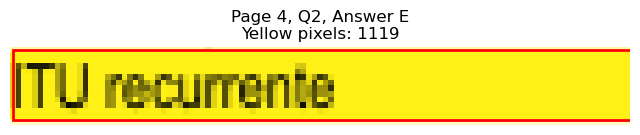


Page 4, Q2 - Selected Answer: E (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=291.4, x1=115.9, y1=304.1
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 234
Page 4, Q3, A: Yellow percentage: 0.0%


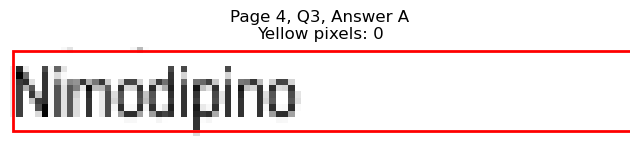

Page 4, Q3 - B: Detected box: x0=68.3, y0=304.0, x1=121.5, y1=316.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 277
Page 4, Q3, B: Yellow percentage: 0.0%


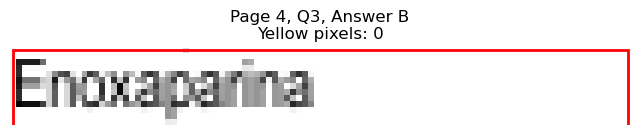

Page 4, Q3 - C: Detected box: x0=68.8, y0=316.6, x1=107.9, y1=329.3
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 205
Page 4, Q3, C: Yellow percentage: 0.0%


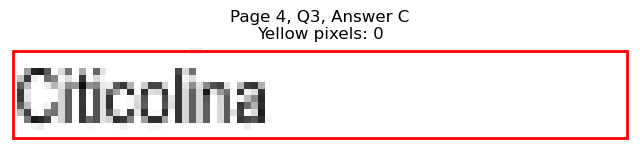

Page 4, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=369.2, y1=304.1
Page 4, Q3, D: Yellow pixels: 91
Page 4, Q3, D: Total non-white pixels: 310
Page 4, Q3, D: Yellow percentage: 29.4%


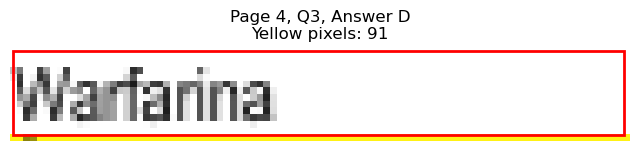

Page 4, Q3 - E: Detected box: x0=327.0, y0=304.0, x1=412.3, y1=316.7
Page 4, Q3, E: Yellow pixels: 1408
Page 4, Q3, E: Total non-white pixels: 1768
Page 4, Q3, E: Yellow percentage: 79.6%


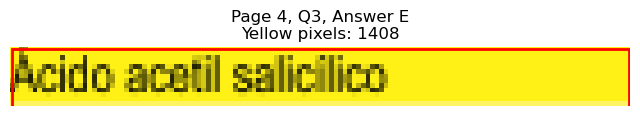


Page 4, Q3 - Selected Answer: E (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=116.4, y1=379.8
Page 4, Q4, A: Yellow pixels: 1105
Page 4, Q4, A: Total non-white pixels: 1287
Page 4, Q4, A: Yellow percentage: 85.9%


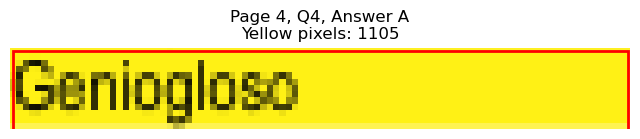

Page 4, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=121.9, y1=392.4
Page 4, Q4, B: Yellow pixels: 102
Page 4, Q4, B: Total non-white pixels: 355
Page 4, Q4, B: Yellow percentage: 28.7%


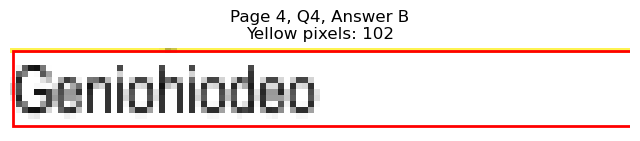

Page 4, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=111.4, y1=405.0
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 226
Page 4, Q4, C: Yellow percentage: 0.0%


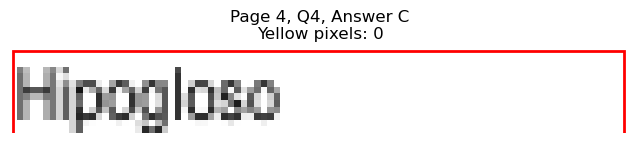

Page 4, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=373.7, y1=379.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 235
Page 4, Q4, D: Yellow percentage: 0.0%


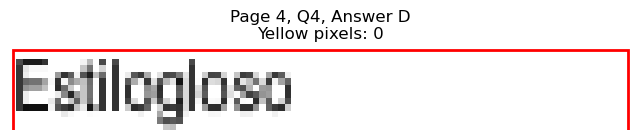

Page 4, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=366.7, y1=392.4
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 194
Page 4, Q4, E: Yellow percentage: 0.0%


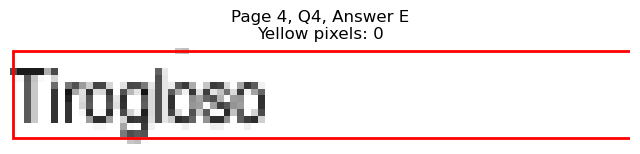


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=430.2, x1=100.5, y1=442.9
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 262
Page 4, Q5, A: Yellow percentage: 0.0%


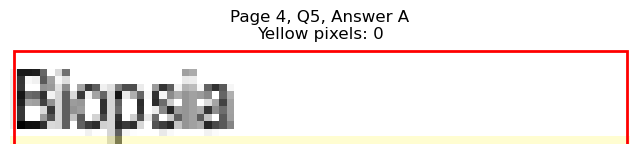

Page 4, Q5 - B: Detected box: x0=68.3, y0=442.8, x1=179.2, y1=455.5
Page 4, Q5, B: Yellow pixels: 1691
Page 4, Q5, B: Total non-white pixels: 2268
Page 4, Q5, B: Yellow percentage: 74.6%


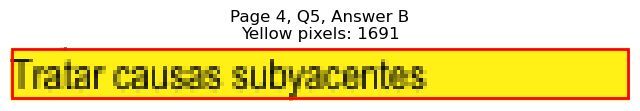

Page 4, Q5 - C: Detected box: x0=68.8, y0=455.5, x1=154.0, y1=468.1
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 452
Page 4, Q5, C: Yellow percentage: 0.0%


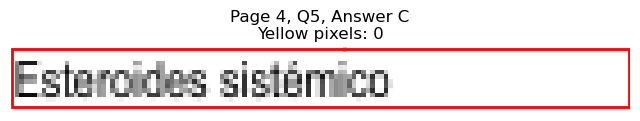

Page 4, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=403.7, y1=442.9
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 401
Page 4, Q5, D: Yellow percentage: 0.0%


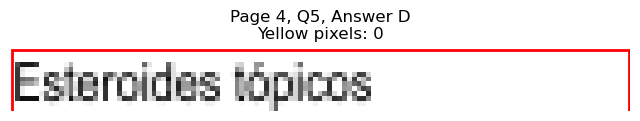

Page 4, Q5 - E: Detected box: x0=327.0, y0=442.8, x1=400.7, y1=455.5
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 391
Page 4, Q5, E: Yellow percentage: 0.0%


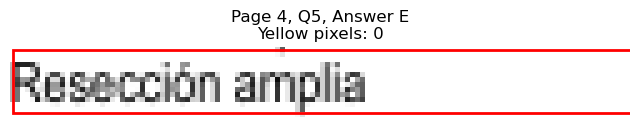


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=531.2, x1=150.0, y1=543.8
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 422
Page 4, Q6, A: Yellow percentage: 0.0%


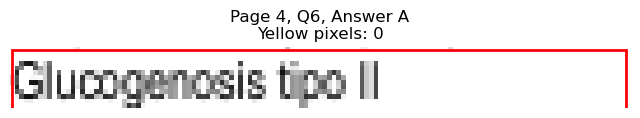

Page 4, Q6 - B: Detected box: x0=68.3, y0=543.8, x1=228.8, y1=556.4
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 811
Page 4, Q6, B: Yellow percentage: 0.0%


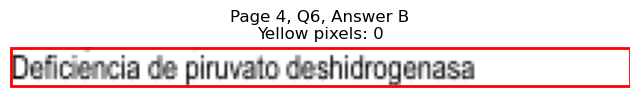

Page 4, Q6 - C: Detected box: x0=68.8, y0=556.5, x1=126.5, y1=569.2
Page 4, Q6, C: Yellow pixels: 1176
Page 4, Q6, C: Total non-white pixels: 1526
Page 4, Q6, C: Yellow percentage: 77.1%


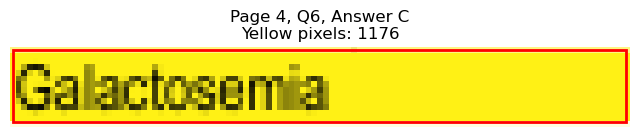

Page 4, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=377.7, y1=543.8
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 222
Page 4, Q6, D: Yellow percentage: 0.0%


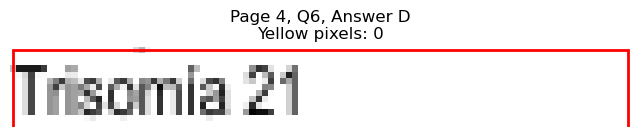

Page 4, Q6 - E: Detected box: x0=327.0, y0=543.8, x1=428.3, y1=556.4
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 532
Page 4, Q6, E: Yellow percentage: 0.0%


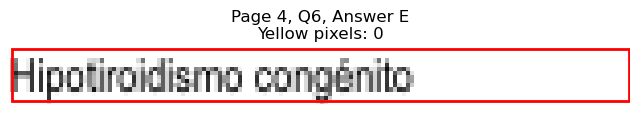


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=606.9, x1=171.6, y1=619.6
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 530
Page 4, Q7, A: Yellow percentage: 0.0%


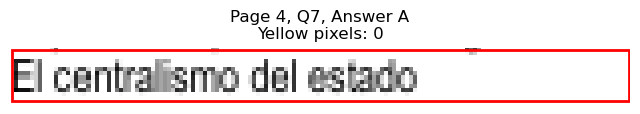

Page 4, Q7 - B: Detected box: x0=68.3, y0=619.6, x1=166.1, y1=632.3
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 499
Page 4, Q7, B: Yellow percentage: 0.0%


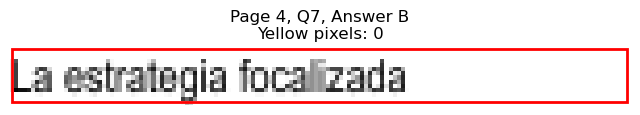

Page 4, Q7 - C: Detected box: x0=68.8, y0=632.2, x1=214.2, y1=644.9
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 717
Page 4, Q7, C: Yellow percentage: 0.0%


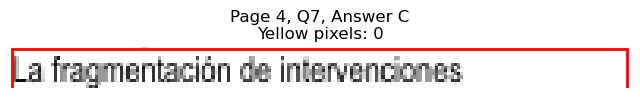

Page 4, Q7 - D: Detected box: x0=327.5, y0=606.9, x1=488.0, y1=619.6
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 851
Page 4, Q7, D: Yellow percentage: 0.0%


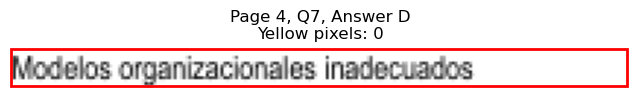

Page 4, Q7 - E: Detected box: x0=327.0, y0=619.6, x1=502.1, y1=632.3
Page 4, Q7, E: Yellow pixels: 1882
Page 4, Q7, E: Total non-white pixels: 2996
Page 4, Q7, E: Yellow percentage: 62.8%


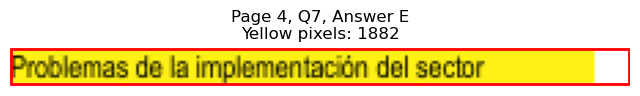


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=682.7, x1=113.9, y1=695.3
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 211
Page 4, Q8, A: Yellow percentage: 0.0%


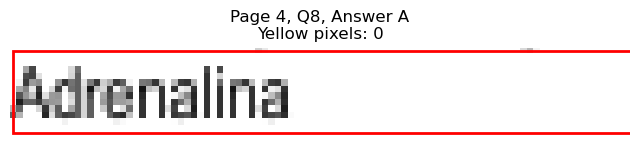

Page 4, Q8 - B: Detected box: x0=68.3, y0=695.4, x1=104.4, y1=708.0
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 182
Page 4, Q8, B: Yellow percentage: 0.0%


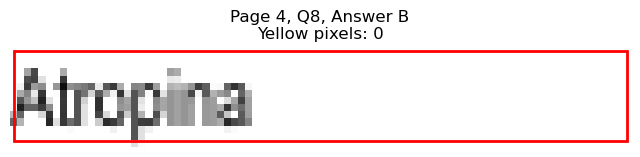

Page 4, Q8 - C: Detected box: x0=68.8, y0=708.0, x1=105.4, y1=720.6
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 196
Page 4, Q8, C: Yellow percentage: 0.0%


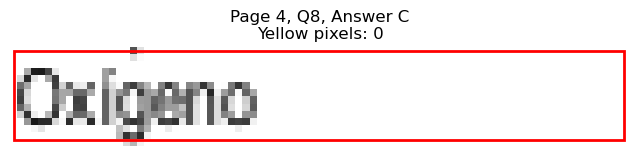

Page 4, Q8 - D: Detected box: x0=327.5, y0=682.7, x1=383.2, y1=695.3
Page 4, Q8, D: Yellow pixels: 1061
Page 4, Q8, D: Total non-white pixels: 1498
Page 4, Q8, D: Yellow percentage: 70.8%


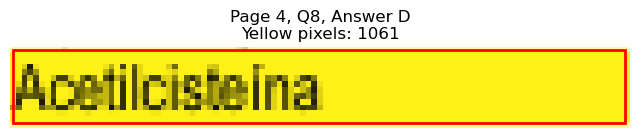

Page 4, Q8 - E: Detected box: x0=327.0, y0=695.4, x1=367.7, y1=708.0
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 293
Page 4, Q8, E: Yellow percentage: 0.0%


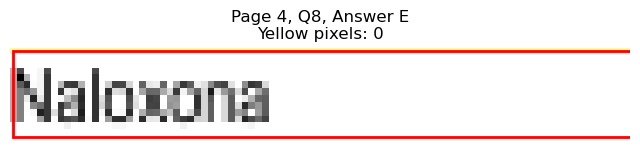


Page 4, Q8 - Selected Answer: D (based on yellow pixel count)





Page 5: Found 8 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=134.1, y1=127.3
Page 5, Q1, A: Yellow pixels: 1176
Page 5, Q1, A: Total non-white pixels: 1638
Page 5, Q1, A: Yellow percentage: 71.8%


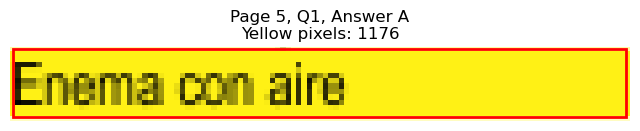

Page 5, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=121.5, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 372
Page 5, Q1, B: Yellow percentage: 0.0%


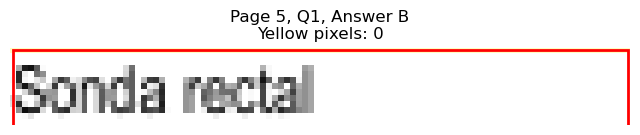

Page 5, Q1 - C: Detected box: x0=68.8, y0=139.9, x1=122.1, y1=152.6
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 269
Page 5, Q1, C: Yellow percentage: 0.0%


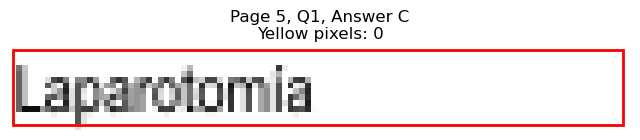

Page 5, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=385.3, y1=127.3
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 292
Page 5, Q1, D: Yellow percentage: 0.0%


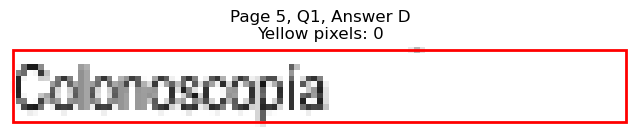

Page 5, Q1 - E: Detected box: x0=327.0, y0=127.2, x1=397.7, y1=139.9
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 334
Page 5, Q1, E: Yellow percentage: 0.0%


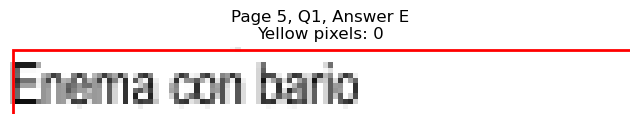


Page 5, Q1 - Selected Answer: A (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=77.3, y1=215.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 43
Page 5, Q2, A: Yellow percentage: 0.0%


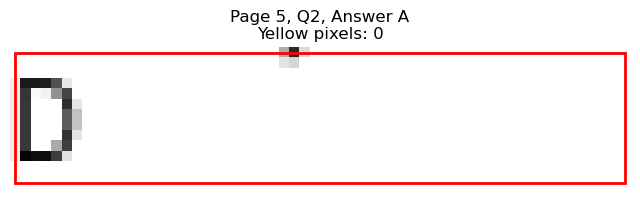

Page 5, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=86.9, y1=228.3
Page 5, Q2, B: Yellow pixels: 762
Page 5, Q2, B: Total non-white pixels: 966
Page 5, Q2, B: Yellow percentage: 78.9%


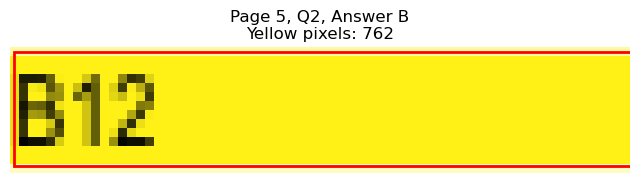

Page 5, Q2 - C: Detected box: x0=56.6, y0=228.3, x1=65.6, y1=240.9
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 130
Page 5, Q2, C: Yellow percentage: 0.0%


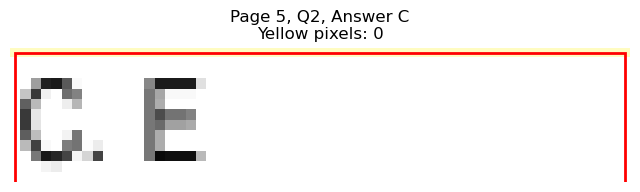

Page 5, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=324.4, y1=215.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 79
Page 5, Q2, D: Yellow percentage: 0.0%


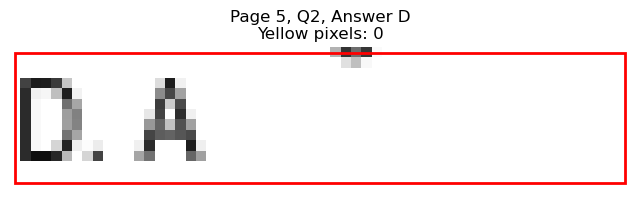

Page 5, Q2 - E: Detected box: x0=327.0, y0=215.7, x1=336.1, y1=228.3
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 33
Page 5, Q2, E: Yellow percentage: 0.0%


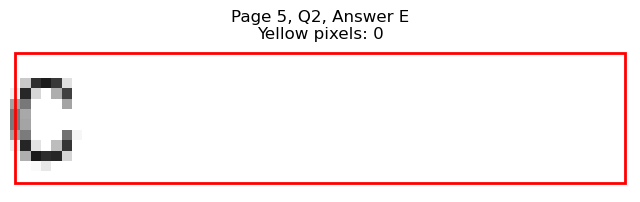


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=96.4, y1=291.5
Page 5, Q3, A: Yellow pixels: 915
Page 5, Q3, A: Total non-white pixels: 1106
Page 5, Q3, A: Yellow percentage: 82.7%


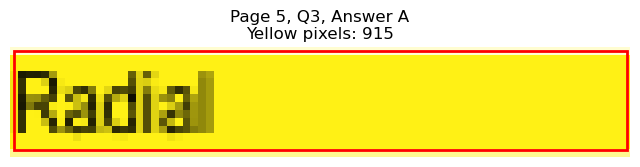

Page 5, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=146.1, y1=304.1
Page 5, Q3, B: Yellow pixels: 129
Page 5, Q3, B: Total non-white pixels: 516
Page 5, Q3, B: Yellow percentage: 25.0%


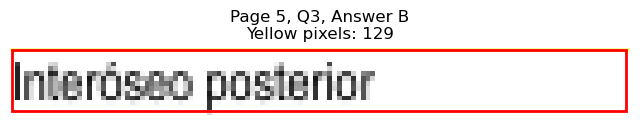

Page 5, Q3 - C: Detected box: x0=68.8, y0=304.0, x1=136.9, y1=316.7
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 350
Page 5, Q3, C: Yellow percentage: 0.0%


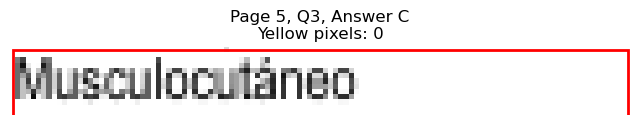

Page 5, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=358.1, y1=291.5
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 169
Page 5, Q3, D: Yellow percentage: 0.0%


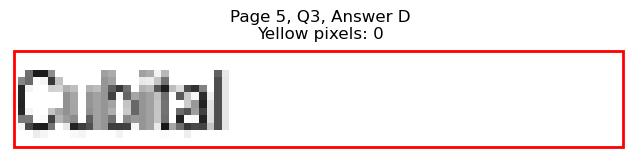

Page 5, Q3 - E: Detected box: x0=327.0, y0=291.4, x1=364.1, y1=304.1
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 192
Page 5, Q3, E: Yellow percentage: 0.0%


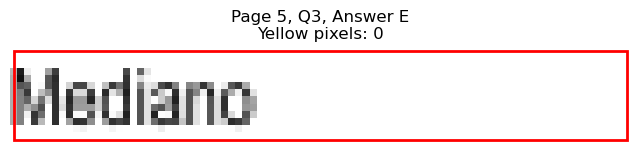


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=106.5, y1=379.8
Page 5, Q4, A: Yellow pixels: 1
Page 5, Q4, A: Total non-white pixels: 283
Page 5, Q4, A: Yellow percentage: 0.4%


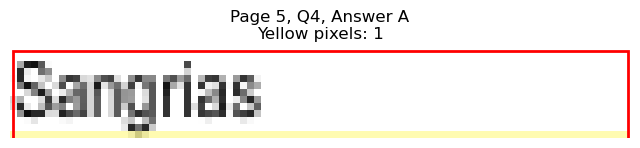

Page 5, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=149.5, y1=392.4
Page 5, Q4, B: Yellow pixels: 1272
Page 5, Q4, B: Total non-white pixels: 1848
Page 5, Q4, B: Yellow percentage: 68.8%


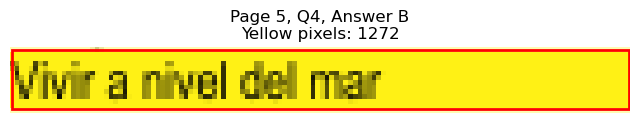

Page 5, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=130.5, y1=405.0
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 426
Page 5, Q4, C: Yellow percentage: 0.0%


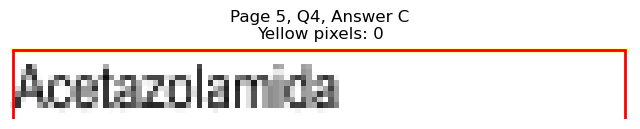

Page 5, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=384.7, y1=379.8
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 296
Page 5, Q4, D: Yellow percentage: 0.0%


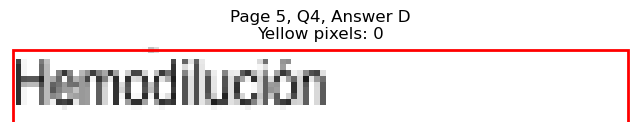

Page 5, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=414.8, y1=392.4
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 469
Page 5, Q4, E: Yellow percentage: 0.0%


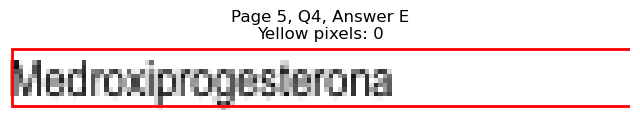


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=468.1, x1=112.5, y1=480.7
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 226
Page 5, Q5, A: Yellow percentage: 0.0%


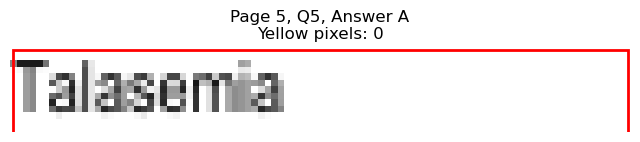

Page 5, Q5 - B: Detected box: x0=68.3, y0=480.8, x1=112.9, y1=493.4
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 228
Page 5, Q5, B: Yellow percentage: 0.0%


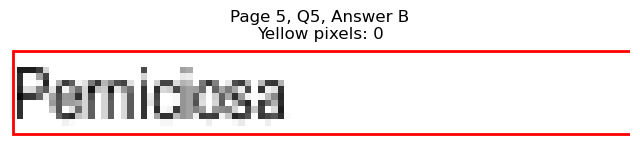

Page 5, Q5 - C: Detected box: x0=68.8, y0=493.4, x1=149.1, y1=506.0
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 409
Page 5, Q5, C: Yellow percentage: 0.0%


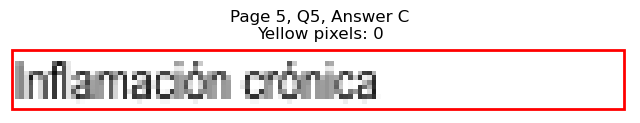

Page 5, Q5 - D: Detected box: x0=327.5, y0=468.1, x1=412.3, y1=480.7
Page 5, Q5, D: Yellow pixels: 1443
Page 5, Q5, D: Total non-white pixels: 1768
Page 5, Q5, D: Yellow percentage: 81.6%


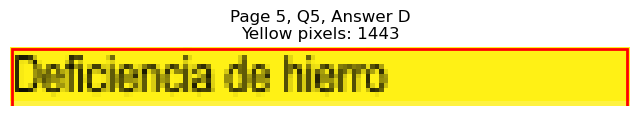

Page 5, Q5 - E: Detected box: x0=327.0, y0=480.8, x1=386.2, y1=493.4
Page 5, Q5, E: Yellow pixels: 110
Page 5, Q5, E: Total non-white pixels: 447
Page 5, Q5, E: Yellow percentage: 24.6%


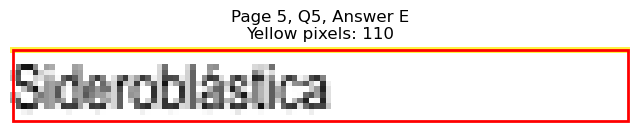


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=543.8, x1=190.7, y1=556.4
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 583
Page 5, Q6, A: Yellow percentage: 0.0%


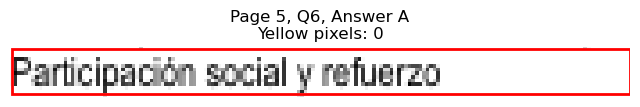

Page 5, Q6 - B: Detected box: x0=68.3, y0=556.5, x1=260.0, y1=569.2
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 913
Page 5, Q6, B: Yellow percentage: 0.0%


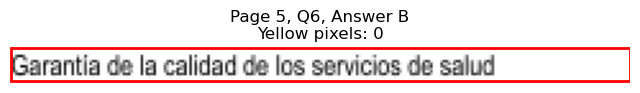

Page 5, Q6 - C: Detected box: x0=68.8, y0=569.1, x1=196.7, y1=581.8
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 646
Page 5, Q6, C: Yellow percentage: 0.0%


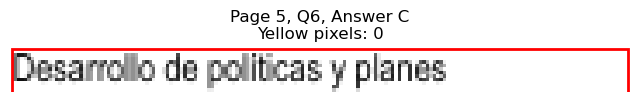

Page 5, Q6 - D: Detected box: x0=327.5, y0=543.8, x1=419.3, y1=556.4
Page 5, Q6, D: Yellow pixels: 1548
Page 5, Q6, D: Total non-white pixels: 2002
Page 5, Q6, D: Yellow percentage: 77.3%


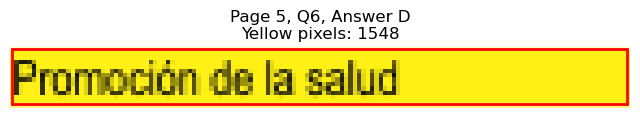

Page 5, Q6 - E: Detected box: x0=327.0, y0=556.5, x1=515.1, y1=569.2
Page 5, Q6, E: Yellow pixels: 213
Page 5, Q6, E: Total non-white pixels: 1158
Page 5, Q6, E: Yellow percentage: 18.4%


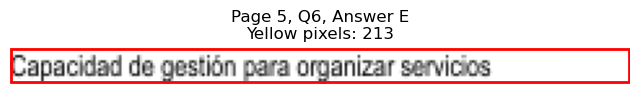


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=619.6, x1=123.5, y1=632.3
Page 5, Q7, A: Yellow pixels: 106
Page 5, Q7, A: Total non-white pixels: 390
Page 5, Q7, A: Yellow percentage: 27.2%


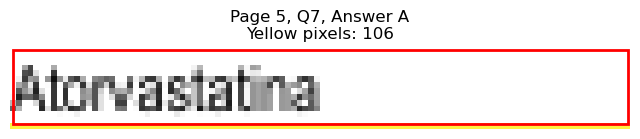

Page 5, Q7 - B: Detected box: x0=68.3, y0=632.2, x1=138.0, y1=644.9
Page 5, Q7, B: Yellow pixels: 1316
Page 5, Q7, B: Total non-white pixels: 1573
Page 5, Q7, B: Yellow percentage: 83.7%


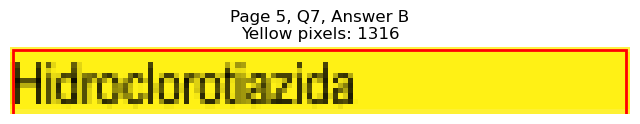

Page 5, Q7 - C: Detected box: x0=68.8, y0=644.9, x1=106.5, y1=657.5
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 173
Page 5, Q7, C: Yellow percentage: 0.0%


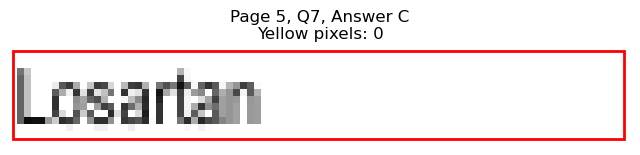

Page 5, Q7 - D: Detected box: x0=327.5, y0=619.6, x1=374.7, y1=632.3
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 251
Page 5, Q7, D: Yellow percentage: 0.0%


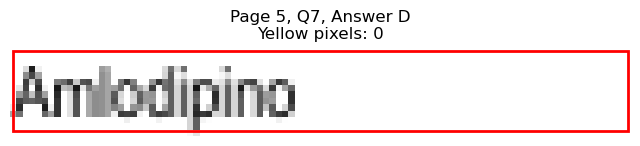

Page 5, Q7 - E: Detected box: x0=327.0, y0=632.2, x1=409.9, y1=644.9
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 434
Page 5, Q7, E: Yellow percentage: 0.0%


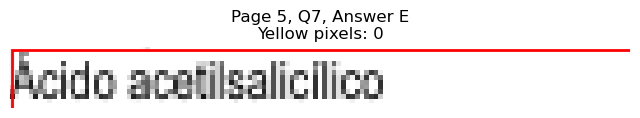


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=708.0, x1=164.1, y1=720.6
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 465
Page 5, Q8, A: Yellow percentage: 0.0%


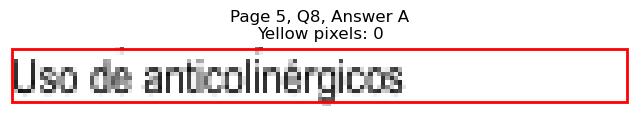

Page 5, Q8 - B: Detected box: x0=68.3, y0=720.6, x1=193.7, y1=733.2
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 605
Page 5, Q8, B: Yellow percentage: 0.0%


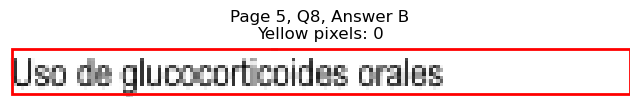

Page 5, Q8 - C: Detected box: x0=68.8, y0=733.2, x1=208.2, y1=745.8
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 744
Page 5, Q8, C: Yellow percentage: 0.0%


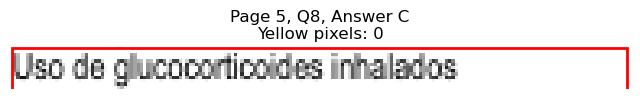

Page 5, Q8 - D: Detected box: x0=327.5, y0=708.0, x1=432.9, y1=720.6
Page 5, Q8, D: Yellow pixels: 156
Page 5, Q8, D: Total non-white pixels: 693
Page 5, Q8, D: Yellow percentage: 22.5%


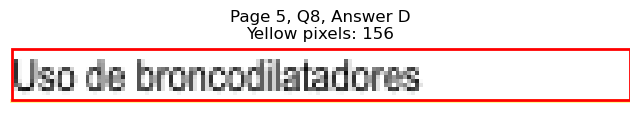

Page 5, Q8 - E: Detected box: x0=327.0, y0=720.6, x1=440.9, y1=733.2
Page 5, Q8, E: Yellow pixels: 1670
Page 5, Q8, E: Total non-white pixels: 2296
Page 5, Q8, E: Yellow percentage: 72.7%


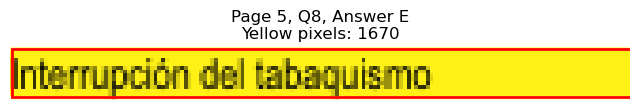


Page 5, Q8 - Selected Answer: E (based on yellow pixel count)





Page 6: Found 8 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=174.6, y1=102.1
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 510
Page 6, Q1, A: Yellow percentage: 0.0%


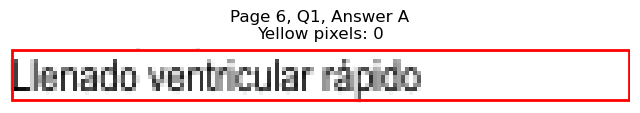

Page 6, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=217.2, y1=114.7
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 758
Page 6, Q1, B: Yellow percentage: 0.0%


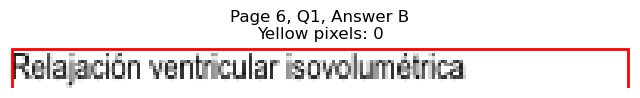

Page 6, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=136.0, y1=127.3
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 331
Page 6, Q1, C: Yellow percentage: 0.0%


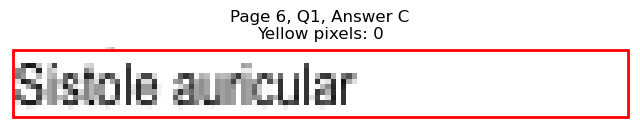

Page 6, Q1 - D: Detected box: x0=327.5, y0=89.4, x1=456.4, y1=102.1
Page 6, Q1, D: Yellow pixels: 180
Page 6, Q1, D: Total non-white pixels: 848
Page 6, Q1, D: Yellow percentage: 21.2%


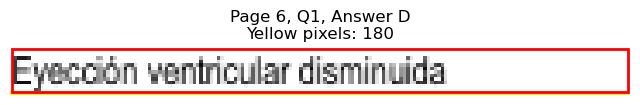

Page 6, Q1 - E: Detected box: x0=327.0, y0=102.0, x1=437.9, y1=114.7
Page 6, Q1, E: Yellow pixels: 1666
Page 6, Q1, E: Total non-white pixels: 2093
Page 6, Q1, E: Yellow percentage: 79.6%


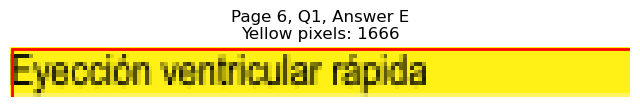


Page 6, Q1 - Selected Answer: E (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=82.3, y1=165.2
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 58
Page 6, Q2, A: Yellow percentage: 0.0%


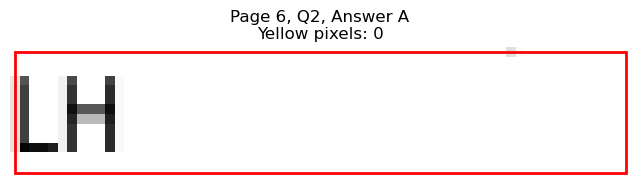

Page 6, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=110.9, y1=177.8
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 209
Page 6, Q2, B: Yellow percentage: 0.0%


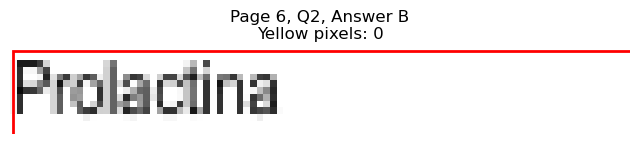

Page 6, Q2 - C: Detected box: x0=68.8, y0=177.7, x1=125.4, y1=190.4
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 298
Page 6, Q2, C: Yellow percentage: 0.0%


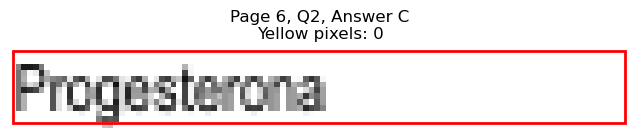

Page 6, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=371.2, y1=165.2
Page 6, Q2, D: Yellow pixels: 95
Page 6, Q2, D: Total non-white pixels: 323
Page 6, Q2, D: Yellow percentage: 29.4%


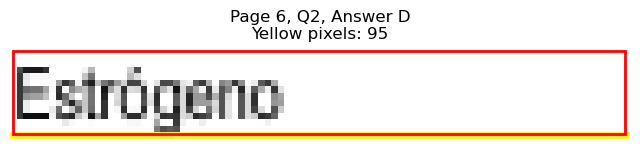

Page 6, Q2 - E: Detected box: x0=327.0, y0=165.1, x1=367.1, y1=177.8
Page 6, Q2, E: Yellow pixels: 1032
Page 6, Q2, E: Total non-white pixels: 1183
Page 6, Q2, E: Yellow percentage: 87.2%


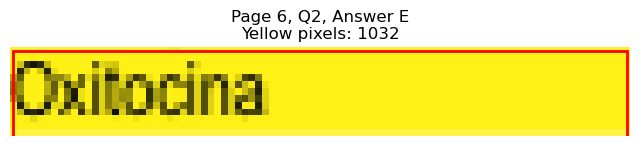


Page 6, Q2 - Selected Answer: E (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=142.6, y1=266.1
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 347
Page 6, Q3, A: Yellow percentage: 0.0%


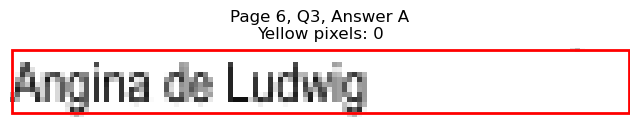

Page 6, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=166.1, y1=278.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 494
Page 6, Q3, B: Yellow percentage: 0.0%


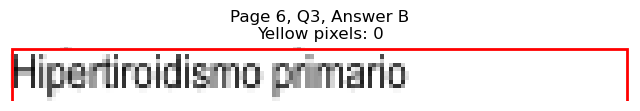

Page 6, Q3 - C: Detected box: x0=68.8, y0=278.8, x1=132.5, y1=291.5
Page 6, Q3, C: Yellow pixels: 1223
Page 6, Q3, C: Total non-white pixels: 1610
Page 6, Q3, C: Yellow percentage: 76.0%


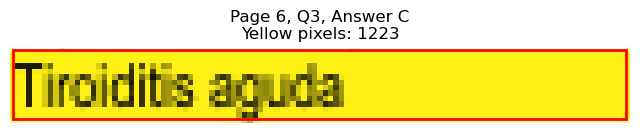

Page 6, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=411.3, y1=266.1
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 425
Page 6, Q3, D: Yellow percentage: 0.0%


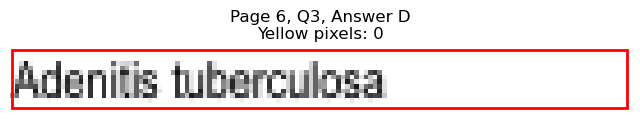

Page 6, Q3 - E: Detected box: x0=327.0, y0=266.1, x1=390.3, y1=278.7
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 315
Page 6, Q3, E: Yellow percentage: 0.0%


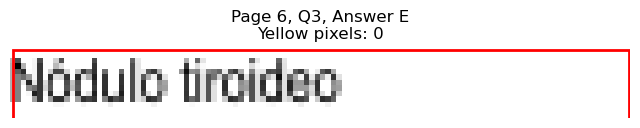


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=133.5, y1=354.6
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 334
Page 6, Q4, A: Yellow percentage: 0.0%


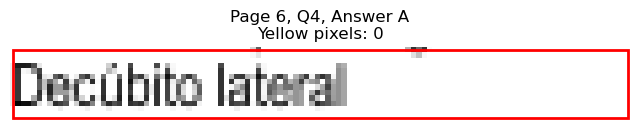

Page 6, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=113.4, y1=367.2
Page 6, Q4, B: Yellow pixels: 96
Page 6, Q4, B: Total non-white pixels: 324
Page 6, Q4, B: Yellow percentage: 29.6%


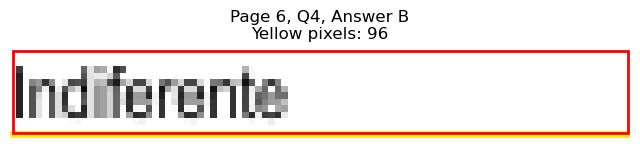

Page 6, Q4 - C: Detected box: x0=68.8, y0=367.1, x1=99.4, y1=379.8
Page 6, Q4, C: Yellow pixels: 946
Page 6, Q4, C: Total non-white pixels: 1066
Page 6, Q4, C: Yellow percentage: 88.7%


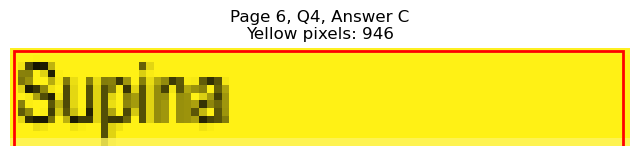

Page 6, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=356.1, y1=354.6
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 126
Page 6, Q4, D: Yellow percentage: 0.0%


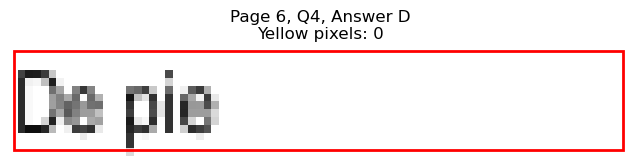

Page 6, Q4 - E: Detected box: x0=327.0, y0=354.5, x1=353.7, y1=367.2
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 128
Page 6, Q4, E: Yellow percentage: 0.0%


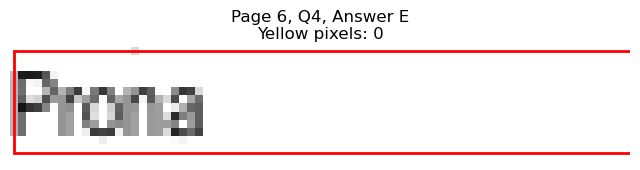


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=163.1, y1=455.5
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 498
Page 6, Q5, A: Yellow percentage: 0.0%


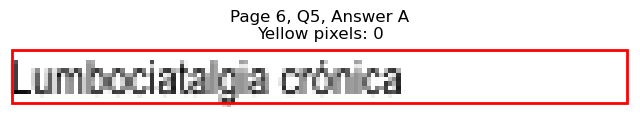

Page 6, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=143.1, y1=468.1
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 407
Page 6, Q5, B: Yellow percentage: 0.0%


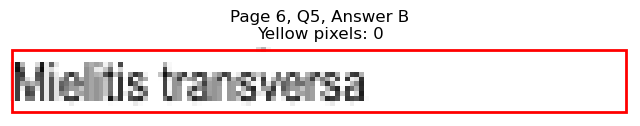

Page 6, Q5 - C: Detected box: x0=68.8, y0=468.1, x1=203.2, y1=480.7
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 687
Page 6, Q5, C: Yellow percentage: 0.0%


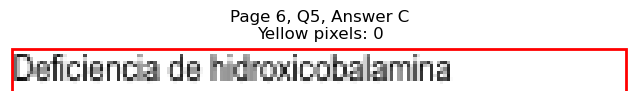

Page 6, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=526.8, y1=455.5
Page 6, Q5, D: Yellow pixels: 1983
Page 6, Q5, D: Total non-white pixels: 2996
Page 6, Q5, D: Yellow percentage: 66.2%


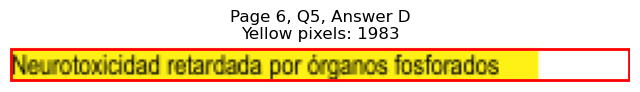

Page 6, Q5 - E: Detected box: x0=327.0, y0=455.5, x1=442.4, y1=468.1
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 578
Page 6, Q5, E: Yellow percentage: 0.0%


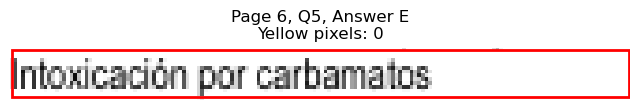


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=531.2, x1=151.6, y1=543.8
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 409
Page 6, Q6, A: Yellow percentage: 0.0%


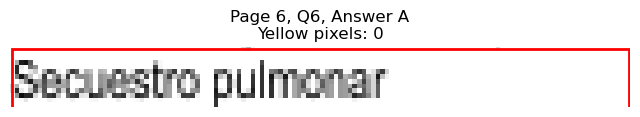

Page 6, Q6 - B: Detected box: x0=68.3, y0=543.8, x1=175.1, y1=556.4
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 562
Page 6, Q6, B: Yellow percentage: 0.0%


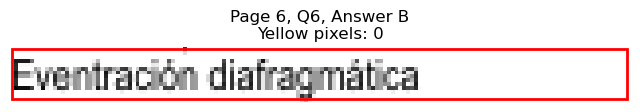

Page 6, Q6 - C: Detected box: x0=68.8, y0=556.5, x1=154.6, y1=569.2
Page 6, Q6, C: Yellow pixels: 1404
Page 6, Q6, C: Total non-white pixels: 1918
Page 6, Q6, C: Yellow percentage: 73.2%


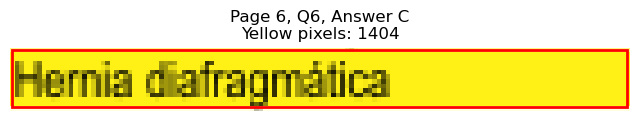

Page 6, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=412.9, y1=543.8
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 432
Page 6, Q6, D: Yellow percentage: 0.0%


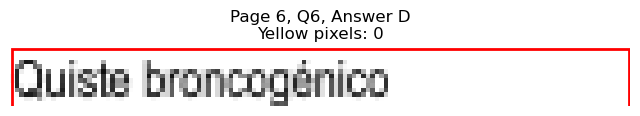

Page 6, Q6 - E: Detected box: x0=327.0, y0=543.8, x1=482.0, y1=556.4
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 808
Page 6, Q6, E: Yellow percentage: 0.0%


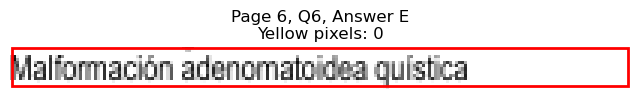


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=619.6, x1=121.9, y1=632.3
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 248
Page 6, Q7, A: Yellow percentage: 0.0%


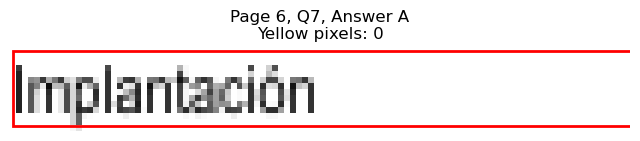

Page 6, Q7 - B: Detected box: x0=68.3, y0=632.2, x1=115.9, y1=644.9
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 338
Page 6, Q7, B: Yellow percentage: 0.0%


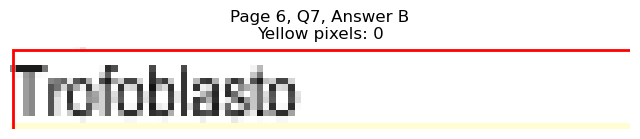

Page 6, Q7 - C: Detected box: x0=68.8, y0=644.9, x1=121.9, y1=657.5
Page 6, Q7, C: Yellow pixels: 1130
Page 6, Q7, C: Total non-white pixels: 1456
Page 6, Q7, C: Yellow percentage: 77.6%


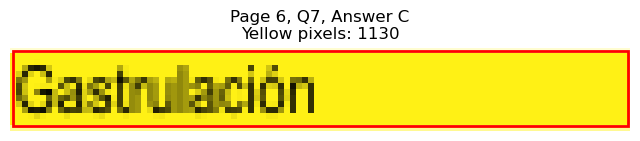

Page 6, Q7 - D: Detected box: x0=327.5, y0=619.6, x1=381.7, y1=632.3
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 265
Page 6, Q7, D: Yellow percentage: 0.0%


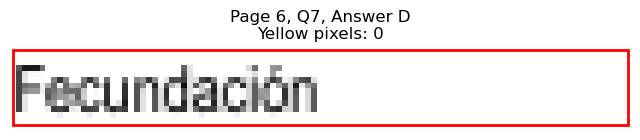

Page 6, Q7 - E: Detected box: x0=327.0, y0=632.2, x1=357.2, y1=644.9
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 158
Page 6, Q7, E: Yellow percentage: 0.0%


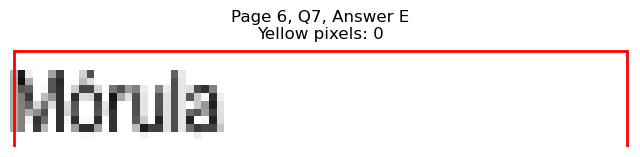


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=720.6, x1=133.5, y1=733.2
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 330
Page 6, Q8, A: Yellow percentage: 0.0%


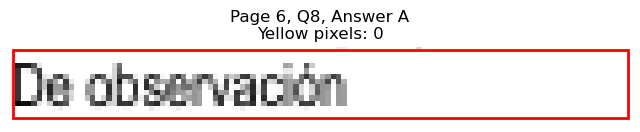

Page 6, Q8 - B: Detected box: x0=68.3, y0=733.2, x1=122.4, y1=745.8
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 278
Page 6, Q8, B: Yellow percentage: 0.0%


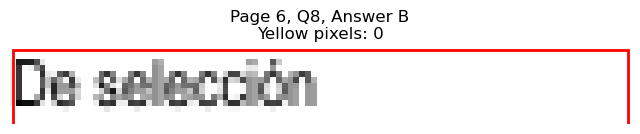

Page 6, Q8 - C: Detected box: x0=68.8, y0=745.8, x1=121.5, y1=758.4
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 256
Page 6, Q8, C: Yellow percentage: 0.0%


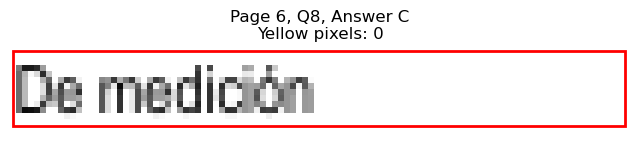

Page 6, Q8 - D: Detected box: x0=327.5, y0=720.6, x1=372.7, y1=733.2
Page 6, Q8, D: Yellow pixels: 96
Page 6, Q8, D: Total non-white pixels: 311
Page 6, Q8, D: Yellow percentage: 30.9%


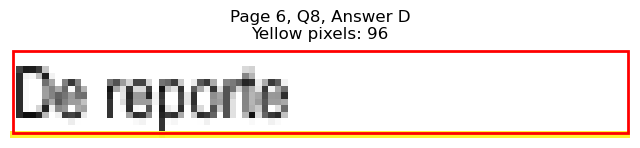

Page 6, Q8 - E: Detected box: x0=327.0, y0=733.2, x1=387.8, y1=745.8
Page 6, Q8, E: Yellow pixels: 1208
Page 6, Q8, E: Total non-white pixels: 1443
Page 6, Q8, E: Yellow percentage: 83.7%


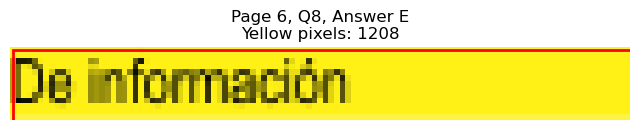


Page 6, Q8 - Selected Answer: E (based on yellow pixel count)





Page 7: Found 7 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=111.4, y1=127.3
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 211
Page 7, Q1, A: Yellow percentage: 0.0%


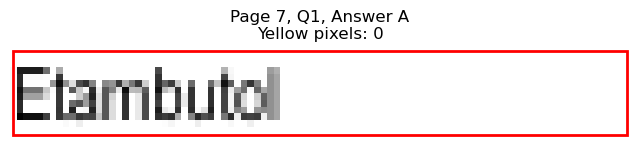

Page 7, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=123.0, y1=139.9
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 277
Page 7, Q1, B: Yellow percentage: 0.0%


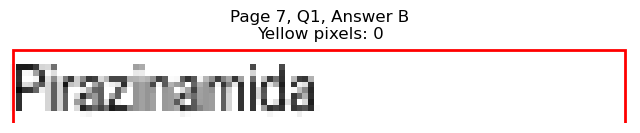

Page 7, Q1 - C: Detected box: x0=68.8, y0=139.9, x1=118.5, y1=152.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 255
Page 7, Q1, C: Yellow percentage: 0.0%


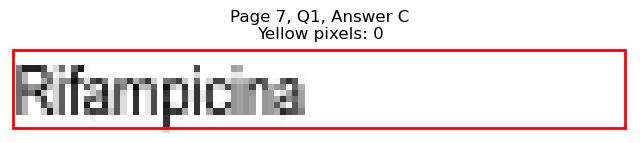

Page 7, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=370.7, y1=127.3
Page 7, Q1, D: Yellow pixels: 961
Page 7, Q1, D: Total non-white pixels: 1316
Page 7, Q1, D: Yellow percentage: 73.0%


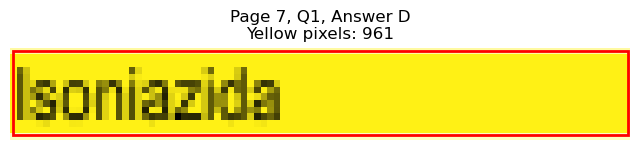

Page 7, Q1 - E: Detected box: x0=327.0, y0=127.2, x1=376.7, y1=139.9
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 361
Page 7, Q1, E: Yellow percentage: 0.0%


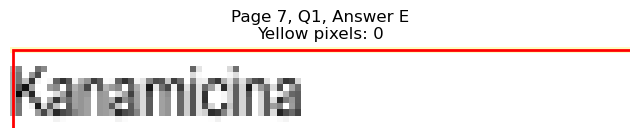


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=162.1, y1=215.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 485
Page 7, Q2, A: Yellow percentage: 0.0%


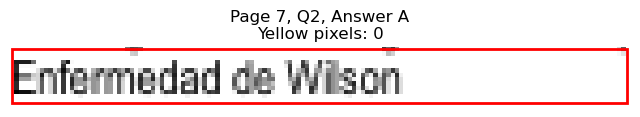

Page 7, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=147.5, y1=228.3
Page 7, Q2, B: Yellow pixels: 130
Page 7, Q2, B: Total non-white pixels: 526
Page 7, Q2, B: Yellow percentage: 24.7%


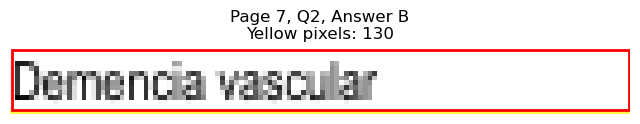

Page 7, Q2 - C: Detected box: x0=68.8, y0=228.3, x1=175.6, y1=240.9
Page 7, Q2, C: Yellow pixels: 1616
Page 7, Q2, C: Total non-white pixels: 2054
Page 7, Q2, C: Yellow percentage: 78.7%


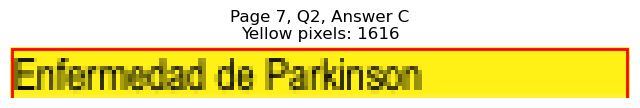

Page 7, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=382.7, y1=215.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 287
Page 7, Q2, D: Yellow percentage: 0.0%


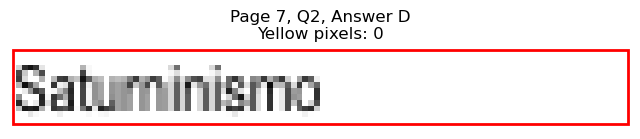

Page 7, Q2 - E: Detected box: x0=327.0, y0=215.7, x1=436.9, y1=228.3
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 560
Page 7, Q2, E: Yellow percentage: 0.0%


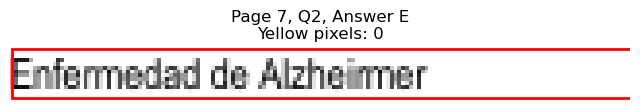


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=123.0, y1=291.5
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 428
Page 7, Q3, A: Yellow percentage: 0.0%


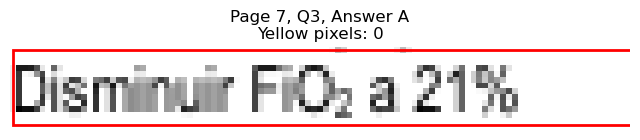

Page 7, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=123.0, y1=304.1
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 444
Page 7, Q3, B: Yellow percentage: 0.0%


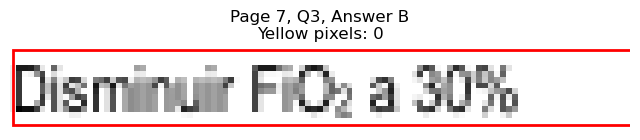

Page 7, Q3 - C: Detected box: x0=68.8, y0=304.0, x1=125.0, y1=316.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 466
Page 7, Q3, C: Yellow percentage: 0.0%


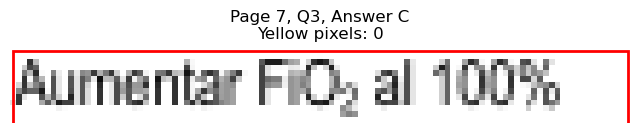

Page 7, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=383.7, y1=291.5
Page 7, Q3, D: Yellow pixels: 107
Page 7, Q3, D: Total non-white pixels: 482
Page 7, Q3, D: Yellow percentage: 22.2%


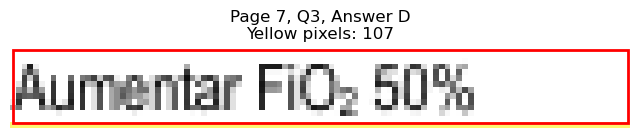

Page 7, Q3 - E: Detected box: x0=327.0, y0=291.4, x1=382.3, y1=304.1
Page 7, Q3, E: Yellow pixels: 1006
Page 7, Q3, E: Total non-white pixels: 1484
Page 7, Q3, E: Yellow percentage: 67.8%


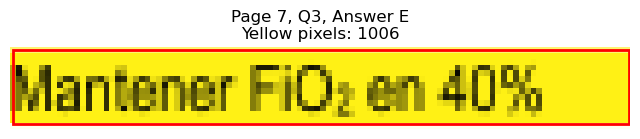


Page 7, Q3 - Selected Answer: E (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=76.8, y1=367.2
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 28
Page 7, Q4, A: Yellow percentage: 0.0%


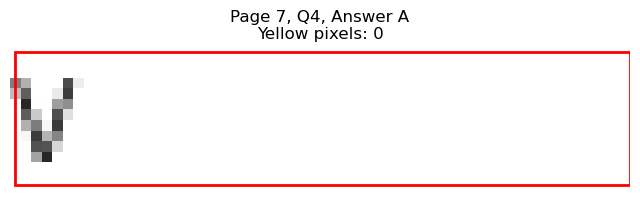

Page 7, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=79.3, y1=379.8
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 36
Page 7, Q4, B: Yellow percentage: 0.0%


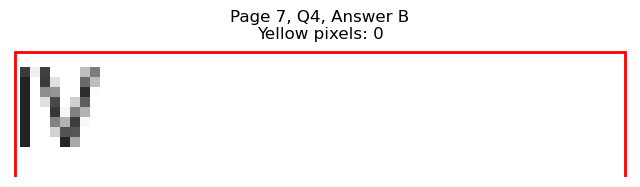

Page 7, Q4 - C: Detected box: x0=56.6, y0=379.7, x1=65.6, y1=392.4
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 53
Page 7, Q4, C: Yellow percentage: 0.0%


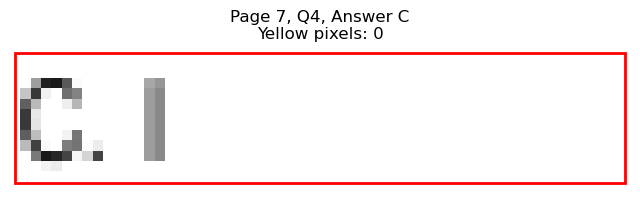

Page 7, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=337.6, y1=367.2
Page 7, Q4, D: Yellow pixels: 753
Page 7, Q4, D: Total non-white pixels: 854
Page 7, Q4, D: Yellow percentage: 88.2%


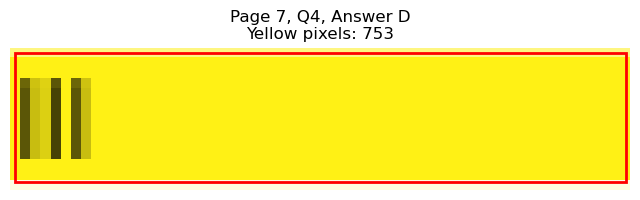

Page 7, Q4 - E: Detected box: x0=315.4, y0=367.1, x1=323.9, y1=379.8
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 127
Page 7, Q4, E: Yellow percentage: 0.0%


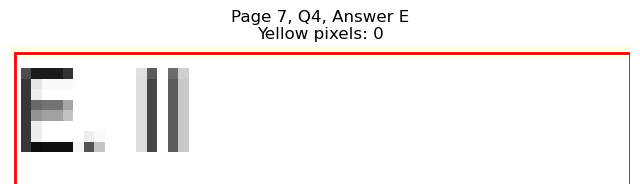


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=148.1, y1=455.5
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 422
Page 7, Q5, A: Yellow percentage: 0.0%


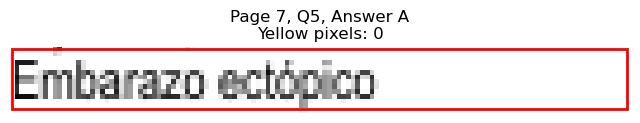

Page 7, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=142.1, y1=468.1
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 372
Page 7, Q5, B: Yellow percentage: 0.0%


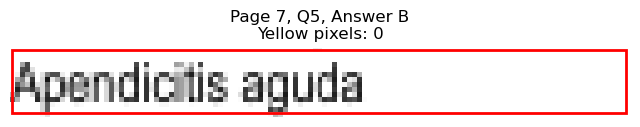

Page 7, Q5 - C: Detected box: x0=68.8, y0=468.1, x1=200.2, y1=480.7
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 668
Page 7, Q5, C: Yellow percentage: 0.0%


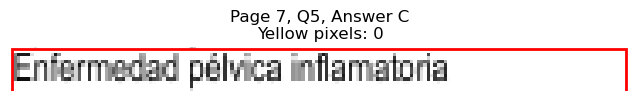

Page 7, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=391.3, y1=455.5
Page 7, Q5, D: Yellow pixels: 1269
Page 7, Q5, D: Total non-white pixels: 1610
Page 7, Q5, D: Yellow percentage: 78.8%


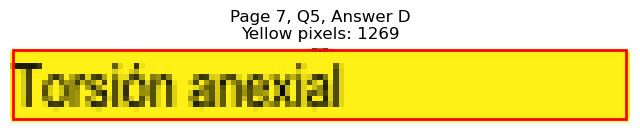

Page 7, Q5 - E: Detected box: x0=327.0, y0=455.5, x1=407.8, y1=468.1
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 417
Page 7, Q5, E: Yellow percentage: 0.0%


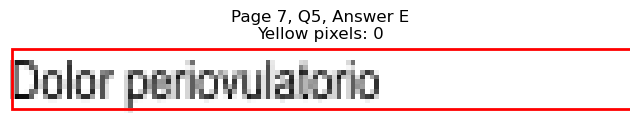


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=543.8, x1=119.4, y1=556.4
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 255
Page 7, Q6, A: Yellow percentage: 0.0%


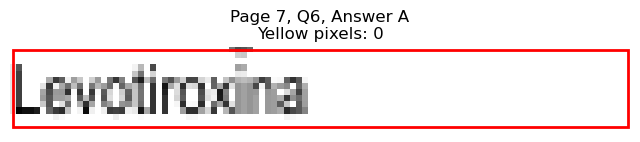

Page 7, Q6 - B: Detected box: x0=68.3, y0=556.5, x1=131.5, y1=569.2
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 289
Page 7, Q6, B: Yellow percentage: 0.0%


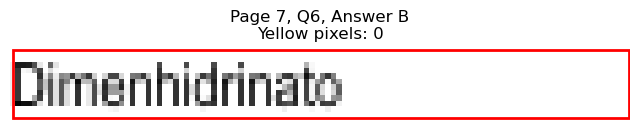

Page 7, Q6 - C: Detected box: x0=68.8, y0=569.1, x1=142.9, y1=581.8
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 330
Page 7, Q6, C: Yellow percentage: 0.0%


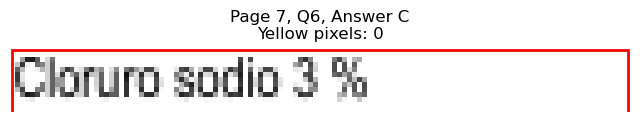

Page 7, Q6 - D: Detected box: x0=327.5, y0=543.8, x1=381.7, y1=556.4
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 273
Page 7, Q6, D: Yellow percentage: 0.0%


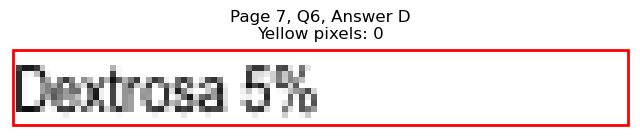

Page 7, Q6 - E: Detected box: x0=327.0, y0=556.5, x1=374.7, y1=569.2
Page 7, Q6, E: Yellow pixels: 1096
Page 7, Q6, E: Total non-white pixels: 1372
Page 7, Q6, E: Yellow percentage: 79.9%


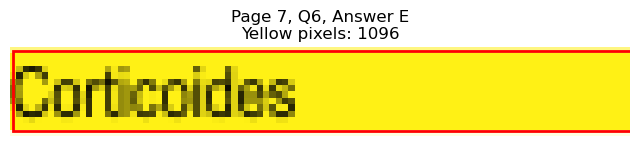


Page 7, Q6 - Selected Answer: E (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=644.9, x1=282.3, y1=657.5
Page 7, Q7, A: Yellow pixels: 1941
Page 7, Q7, A: Total non-white pixels: 3066
Page 7, Q7, A: Yellow percentage: 63.3%


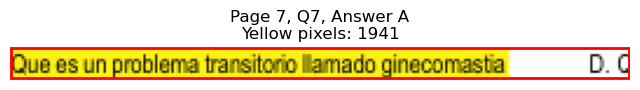

Page 7, Q7 - B: Detected box: x0=68.3, y0=670.1, x1=282.3, y1=682.7
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 1367
Page 7, Q7, B: Yellow percentage: 0.0%


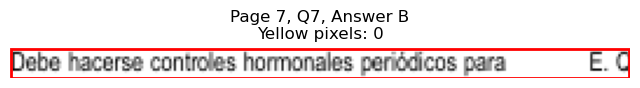

Page 7, Q7 - C: Detected box: x0=68.8, y0=695.4, x1=282.2, y1=708.0
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 1056
Page 7, Q7, C: Yellow percentage: 0.0%


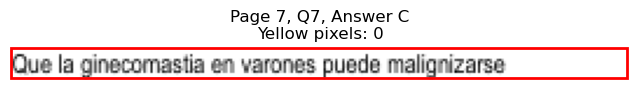

Page 7, Q7 - D: Detected box: x0=383.3, y0=644.9, x1=436.4, y1=657.5
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 516
Page 7, Q7, D: Yellow percentage: 0.0%


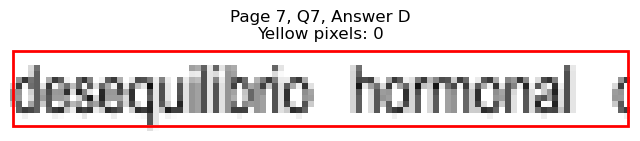

Page 7, Q7 - E: Detected box: x0=327.0, y0=670.1, x1=507.6, y1=682.7
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 913
Page 7, Q7, E: Yellow percentage: 0.0%


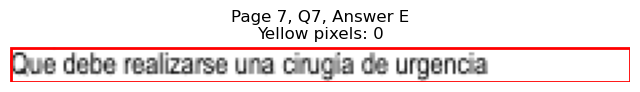


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=80.9, y1=114.7
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 59
Page 8, Q1, A: Yellow percentage: 0.0%


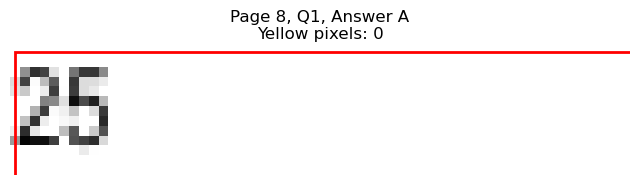

Page 8, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=80.9, y1=127.3
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 41
Page 8, Q1, B: Yellow percentage: 0.0%


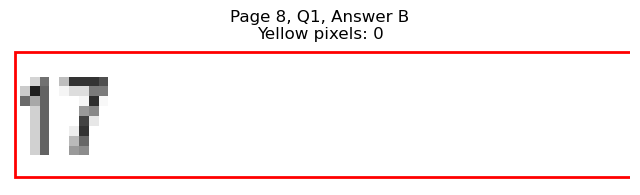

Page 8, Q1 - C: Detected box: x0=68.8, y0=127.2, x1=81.4, y1=139.9
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 54
Page 8, Q1, C: Yellow percentage: 0.0%


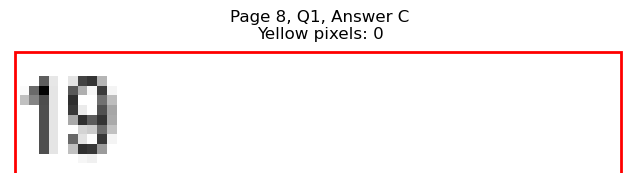

Page 8, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=340.1, y1=114.7
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 108
Page 8, Q1, D: Yellow percentage: 0.0%


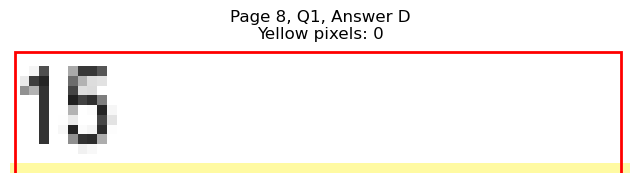

Page 8, Q1 - E: Detected box: x0=327.0, y0=114.6, x1=339.7, y1=127.3
Page 8, Q1, E: Yellow pixels: 715
Page 8, Q1, E: Total non-white pixels: 882
Page 8, Q1, E: Yellow percentage: 81.1%


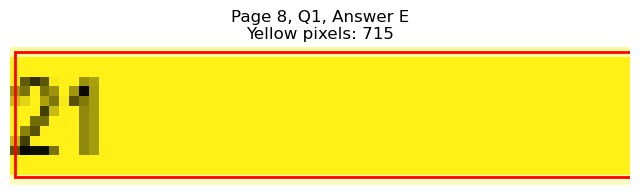


Page 8, Q1 - Selected Answer: E (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=137.5, y1=190.4
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 374
Page 8, Q2, A: Yellow percentage: 0.0%


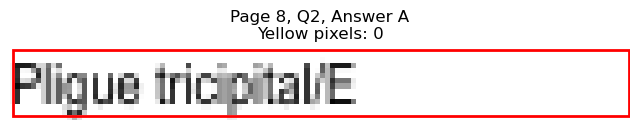

Page 8, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=84.9, y1=203.0
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 76
Page 8, Q2, B: Yellow percentage: 0.0%


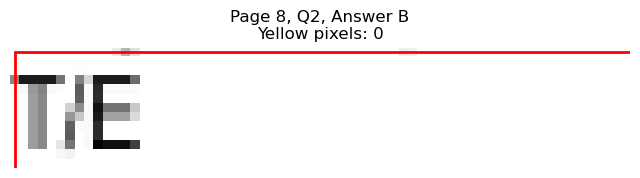

Page 8, Q2 - C: Detected box: x0=68.8, y0=202.9, x1=154.0, y1=215.6
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 451
Page 8, Q2, C: Yellow percentage: 0.0%


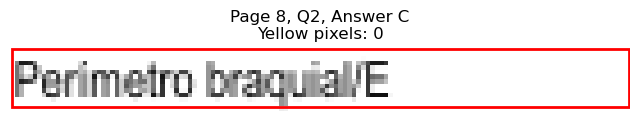

Page 8, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=344.1, y1=190.4
Page 8, Q2, D: Yellow pixels: 763
Page 8, Q2, D: Total non-white pixels: 952
Page 8, Q2, D: Yellow percentage: 80.1%


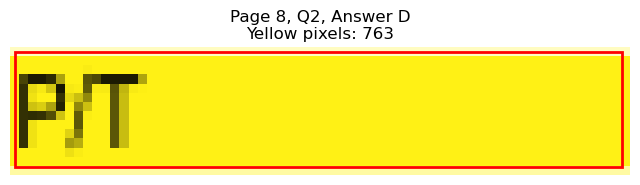

Page 8, Q2 - E: Detected box: x0=327.0, y0=190.3, x1=344.1, y1=203.0
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 147
Page 8, Q2, E: Yellow percentage: 0.0%


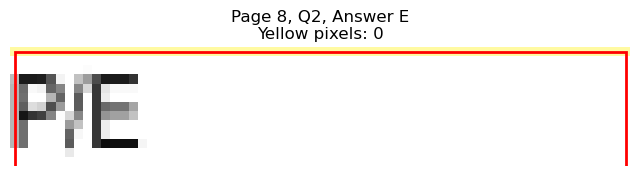


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=162.6, y1=278.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 530
Page 8, Q3, A: Yellow percentage: 0.0%


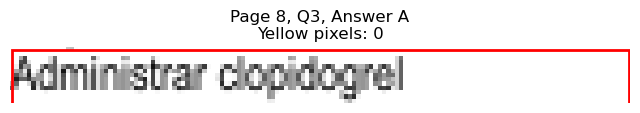

Page 8, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=213.8, y1=291.5
Page 8, Q3, B: Yellow pixels: 1931
Page 8, Q3, B: Total non-white pixels: 2744
Page 8, Q3, B: Yellow percentage: 70.4%


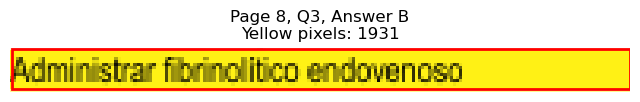

Page 8, Q3 - C: Detected box: x0=68.8, y0=291.4, x1=186.1, y1=304.1
Page 8, Q3, C: Yellow pixels: 169
Page 8, Q3, C: Total non-white pixels: 759
Page 8, Q3, C: Yellow percentage: 22.3%


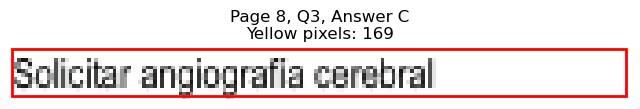

Page 8, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=499.7, y1=278.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 832
Page 8, Q3, D: Yellow percentage: 0.0%


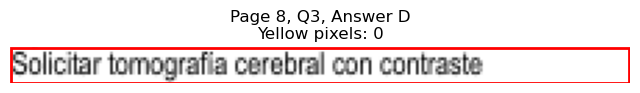

Page 8, Q3 - E: Detected box: x0=327.0, y0=278.8, x1=447.9, y1=291.5
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 603
Page 8, Q3, E: Yellow percentage: 0.0%


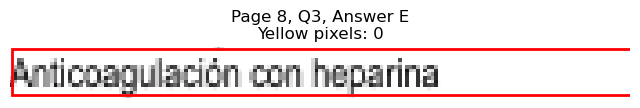


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=113.9, y1=367.2
Page 8, Q4, A: Yellow pixels: 1083
Page 8, Q4, A: Total non-white pixels: 1344
Page 8, Q4, A: Yellow percentage: 80.6%


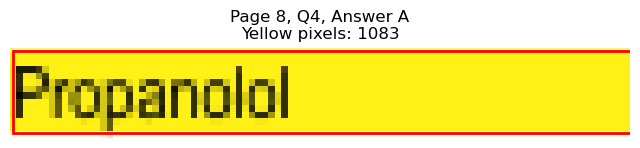

Page 8, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=112.5, y1=379.8
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 323
Page 8, Q4, B: Yellow percentage: 0.0%


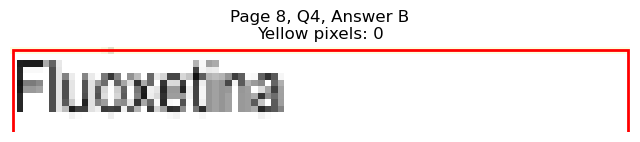

Page 8, Q4 - C: Detected box: x0=68.8, y0=379.7, x1=96.9, y1=392.4
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 148
Page 8, Q4, C: Yellow percentage: 0.0%


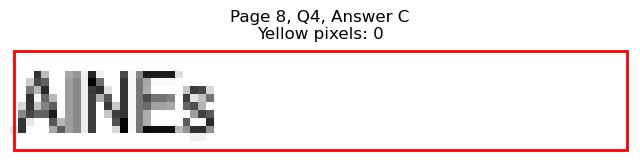

Page 8, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=376.1, y1=367.2
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 260
Page 8, Q4, D: Yellow percentage: 0.0%


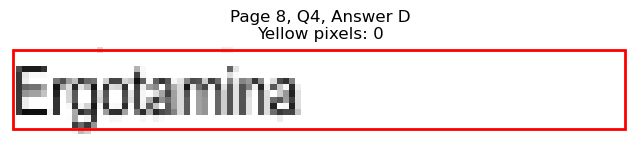

Page 8, Q4 - E: Detected box: x0=327.0, y0=367.1, x1=375.2, y1=379.8
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 236
Page 8, Q4, E: Yellow percentage: 0.0%


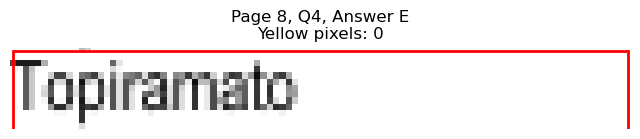


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=417.6, x1=133.0, y1=430.3
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 321
Page 8, Q5, A: Yellow percentage: 0.0%


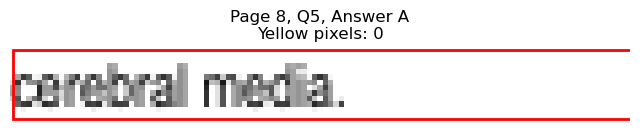

Page 8, Q5 - B: Detected box: x0=68.3, y0=430.2, x1=108.4, y1=442.9
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 183
Page 8, Q5, B: Yellow percentage: 0.0%


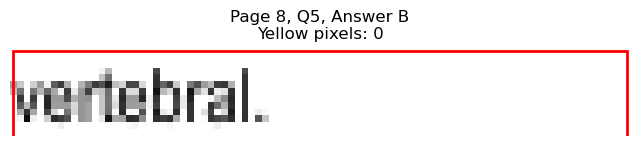

Page 8, Q5 - C: Detected box: x0=68.8, y0=442.8, x1=162.6, y1=455.5
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 449
Page 8, Q5, C: Yellow percentage: 0.0%


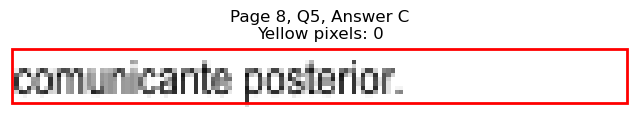

Page 8, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=359.1, y1=430.3
Page 8, Q5, D: Yellow pixels: 83
Page 8, Q5, D: Total non-white pixels: 238
Page 8, Q5, D: Yellow percentage: 34.9%


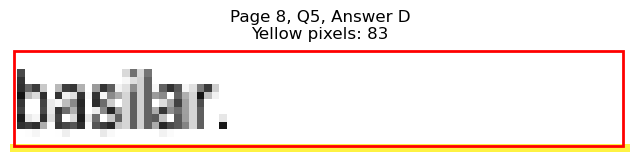

Page 8, Q5 - E: Detected box: x0=327.0, y0=430.2, x1=416.3, y1=442.9
Page 8, Q5, E: Yellow pixels: 1487
Page 8, Q5, E: Total non-white pixels: 1820
Page 8, Q5, E: Yellow percentage: 81.7%


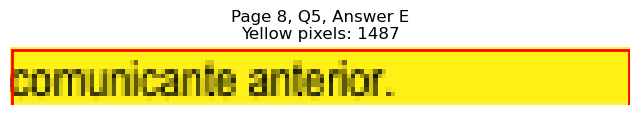


Page 8, Q5 - Selected Answer: E (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=518.6, x1=105.5, y1=531.2
Page 8, Q6, A: Yellow pixels: 990
Page 8, Q6, A: Total non-white pixels: 1232
Page 8, Q6, A: Yellow percentage: 80.4%


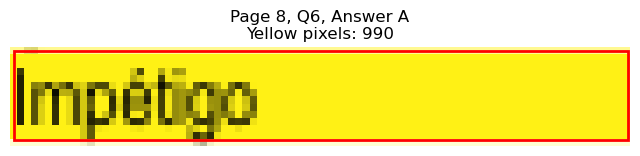

Page 8, Q6 - B: Detected box: x0=68.3, y0=531.2, x1=128.5, y1=543.8
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 435
Page 8, Q6, B: Yellow percentage: 0.0%


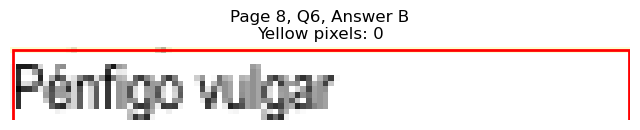

Page 8, Q6 - C: Detected box: x0=68.8, y0=543.8, x1=95.4, y1=556.4
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 148
Page 8, Q6, C: Yellow percentage: 0.0%


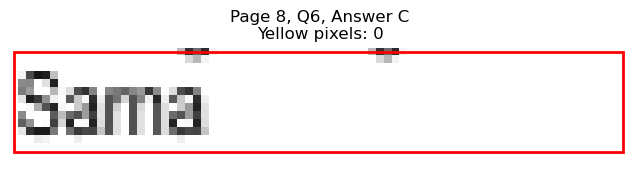

Page 8, Q6 - D: Detected box: x0=327.5, y0=518.6, x1=382.7, y1=531.2
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 296
Page 8, Q6, D: Yellow percentage: 0.0%


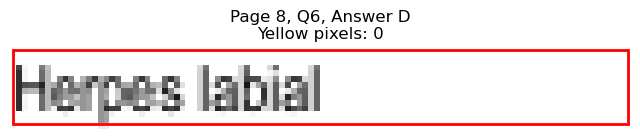

Page 8, Q6 - E: Detected box: x0=327.0, y0=531.2, x1=414.8, y1=543.8
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 455
Page 8, Q6, E: Yellow percentage: 0.0%


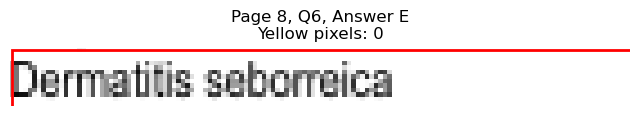


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=619.6, x1=90.4, y1=632.3
Page 8, Q7, A: Yellow pixels: 807
Page 8, Q7, A: Total non-white pixels: 1022
Page 8, Q7, A: Yellow percentage: 79.0%


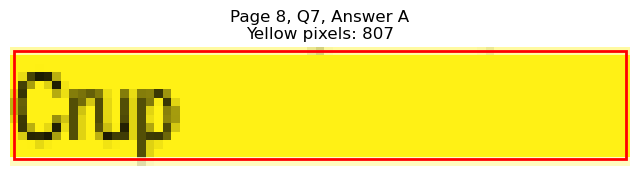

Page 8, Q7 - B: Detected box: x0=68.3, y0=632.2, x1=133.0, y1=644.9
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 430
Page 8, Q7, B: Yellow percentage: 0.0%


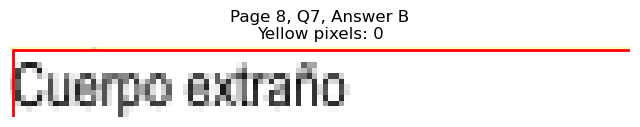

Page 8, Q7 - C: Detected box: x0=68.8, y0=644.9, x1=160.1, y1=657.5
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 468
Page 8, Q7, C: Yellow percentage: 0.0%


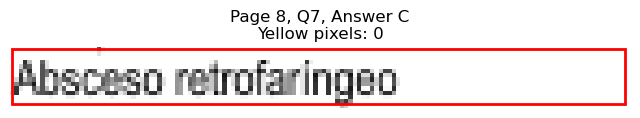

Page 8, Q7 - D: Detected box: x0=327.5, y0=619.6, x1=380.7, y1=632.3
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 260
Page 8, Q7, D: Yellow percentage: 0.0%


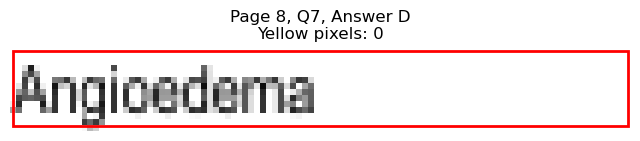

Page 8, Q7 - E: Detected box: x0=327.0, y0=632.2, x1=378.7, y1=644.9
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 287
Page 8, Q7, E: Yellow percentage: 0.0%


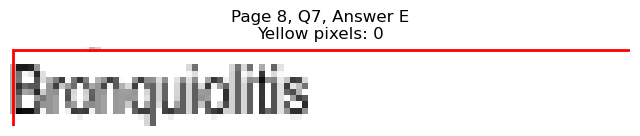


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=682.7, x1=115.0, y1=695.3
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 237
Page 8, Q8, A: Yellow percentage: 0.0%


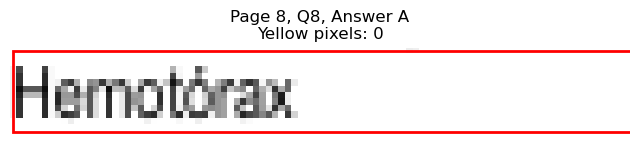

Page 8, Q8 - B: Detected box: x0=68.3, y0=695.4, x1=145.1, y1=708.0
Page 8, Q8, B: Yellow pixels: 1376
Page 8, Q8, B: Total non-white pixels: 1665
Page 8, Q8, B: Yellow percentage: 82.6%


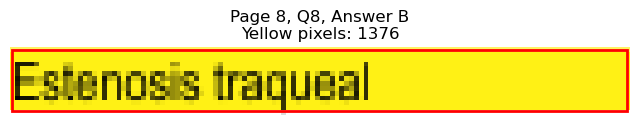

Page 8, Q8 - C: Detected box: x0=68.8, y0=708.0, x1=141.5, y1=720.6
Page 8, Q8, C: Yellow pixels: 123
Page 8, Q8, C: Total non-white pixels: 498
Page 8, Q8, C: Yellow percentage: 24.7%


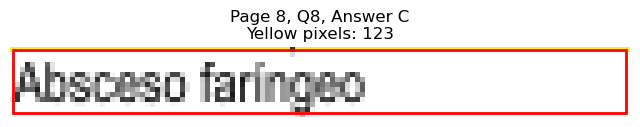

Page 8, Q8 - D: Detected box: x0=327.5, y0=682.7, x1=439.9, y1=695.3
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 574
Page 8, Q8, D: Yellow percentage: 0.0%


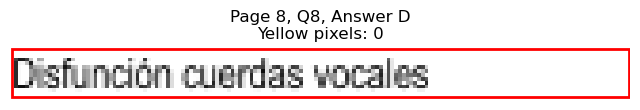

Page 8, Q8 - E: Detected box: x0=327.0, y0=695.4, x1=411.8, y1=708.0
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 457
Page 8, Q8, E: Yellow percentage: 0.0%


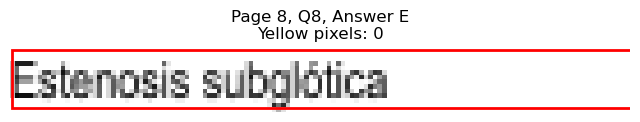


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 8 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=100.5, y1=114.7
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 129
Page 9, Q1, A: Yellow percentage: 0.0%


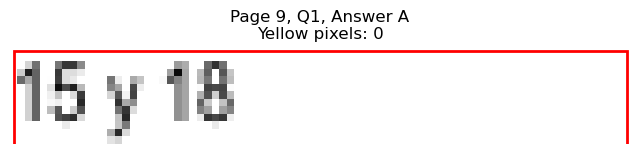

Page 9, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=90.4, y1=127.3
Page 9, Q1, B: Yellow pixels: 73
Page 9, Q1, B: Total non-white pixels: 157
Page 9, Q1, B: Yellow percentage: 46.5%


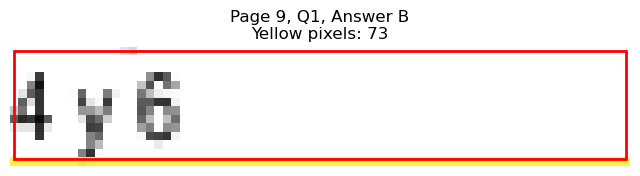

Page 9, Q1 - C: Detected box: x0=68.8, y0=127.2, x1=96.0, y1=139.9
Page 9, Q1, C: Yellow pixels: 957
Page 9, Q1, C: Total non-white pixels: 1027
Page 9, Q1, C: Yellow percentage: 93.2%


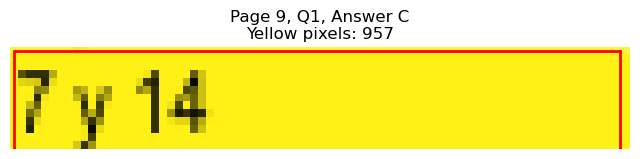

Page 9, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=359.7, y1=114.7
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 118
Page 9, Q1, D: Yellow percentage: 0.0%


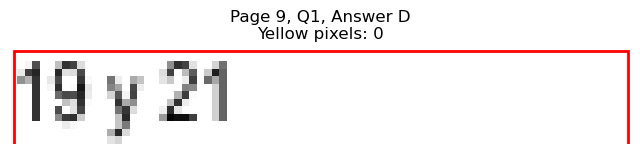

Page 9, Q1 - E: Detected box: x0=327.0, y0=114.6, x1=349.1, y1=127.3
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 76
Page 9, Q1, E: Yellow percentage: 0.0%


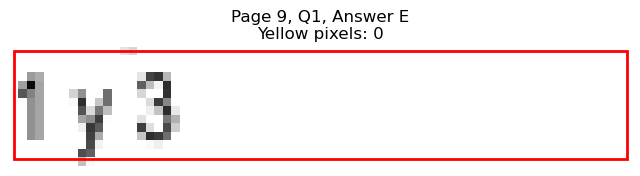


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=124.5, y1=203.0
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 299
Page 9, Q2, A: Yellow percentage: 0.0%


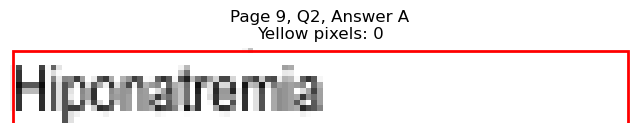

Page 9, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=130.9, y1=215.6
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 341
Page 9, Q2, B: Yellow percentage: 0.0%


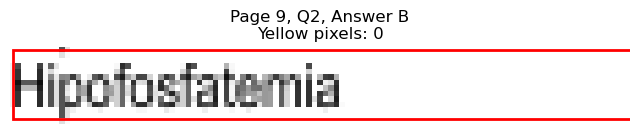

Page 9, Q2 - C: Detected box: x0=68.8, y0=215.7, x1=127.9, y1=228.3
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 300
Page 9, Q2, C: Yellow percentage: 0.0%


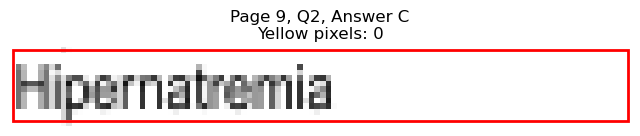

Page 9, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=382.7, y1=203.0
Page 9, Q2, D: Yellow pixels: 1133
Page 9, Q2, D: Total non-white pixels: 1378
Page 9, Q2, D: Yellow percentage: 82.2%


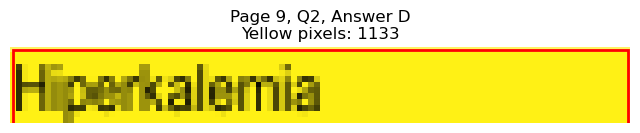

Page 9, Q2 - E: Detected box: x0=327.0, y0=202.9, x1=386.7, y1=215.6
Page 9, Q2, E: Yellow pixels: 108
Page 9, Q2, E: Total non-white pixels: 416
Page 9, Q2, E: Yellow percentage: 26.0%


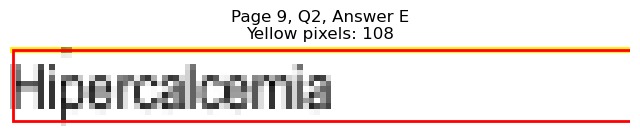


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=115.9, y1=278.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 250
Page 9, Q3, A: Yellow percentage: 0.0%


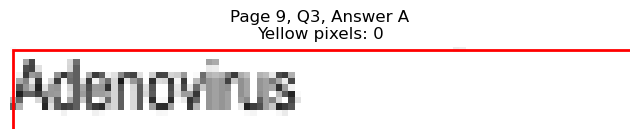

Page 9, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=131.5, y1=291.5
Page 9, Q3, B: Yellow pixels: 1214
Page 9, Q3, B: Total non-white pixels: 1596
Page 9, Q3, B: Yellow percentage: 76.1%


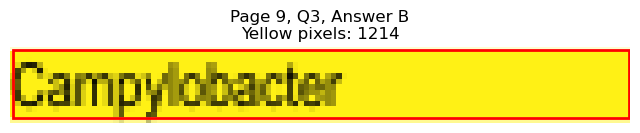

Page 9, Q3 - C: Detected box: x0=68.8, y0=291.4, x1=100.3, y1=304.1
Page 9, Q3, C: Yellow pixels: 82
Page 9, Q3, C: Total non-white pixels: 258
Page 9, Q3, C: Yellow percentage: 31.8%


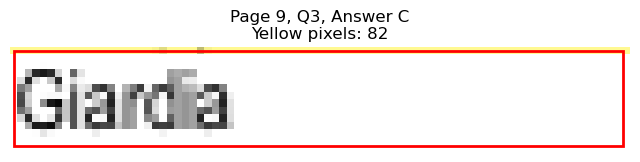

Page 9, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=354.7, y1=278.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 121
Page 9, Q3, D: Yellow percentage: 0.0%


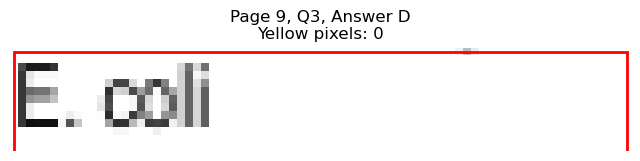

Page 9, Q3 - E: Detected box: x0=327.0, y0=278.8, x1=374.2, y1=291.5
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 251
Page 9, Q3, E: Yellow percentage: 0.0%


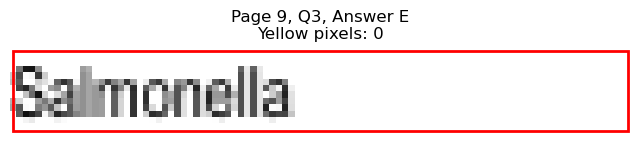


Page 9, Q3 - Selected Answer: B (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=121.9, y1=367.2
Page 9, Q4, A: Yellow pixels: 104
Page 9, Q4, A: Total non-white pixels: 370
Page 9, Q4, A: Yellow percentage: 28.1%


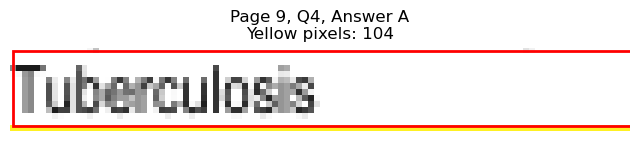

Page 9, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=113.9, y1=379.8
Page 9, Q4, B: Yellow pixels: 1076
Page 9, Q4, B: Total non-white pixels: 1248
Page 9, Q4, B: Yellow percentage: 86.2%


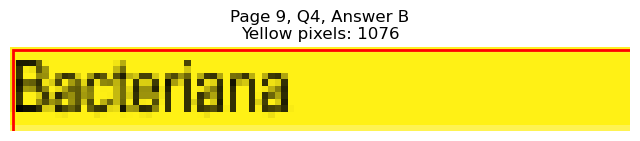

Page 9, Q4 - C: Detected box: x0=68.8, y0=379.7, x1=109.9, y1=392.4
Page 9, Q4, C: Yellow pixels: 92
Page 9, Q4, C: Total non-white pixels: 317
Page 9, Q4, C: Yellow percentage: 29.0%


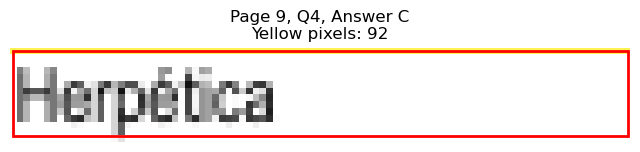

Page 9, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=363.2, y1=367.2
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 195
Page 9, Q4, D: Yellow percentage: 0.0%


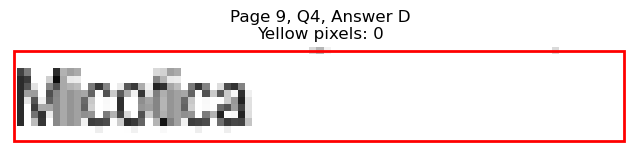

Page 9, Q4 - E: Detected box: x0=327.0, y0=367.1, x1=374.2, y1=379.8
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 260
Page 9, Q4, E: Yellow percentage: 0.0%


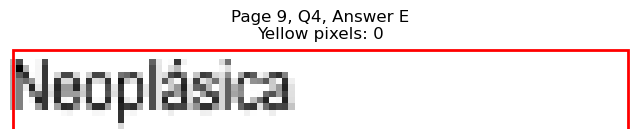


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=127.5, y1=455.5
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 328
Page 9, Q5, A: Yellow percentage: 0.0%


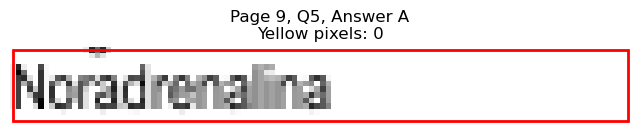

Page 9, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=114.0, y1=468.1
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 206
Page 9, Q5, B: Yellow percentage: 0.0%


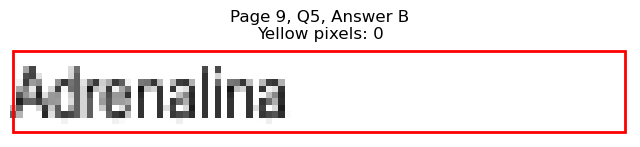

Page 9, Q5 - C: Detected box: x0=68.8, y0=468.1, x1=116.9, y1=480.7
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 231
Page 9, Q5, C: Yellow percentage: 0.0%


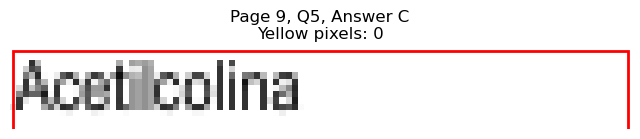

Page 9, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=371.2, y1=455.5
Page 9, Q5, D: Yellow pixels: 1062
Page 9, Q5, D: Total non-white pixels: 1330
Page 9, Q5, D: Yellow percentage: 79.8%


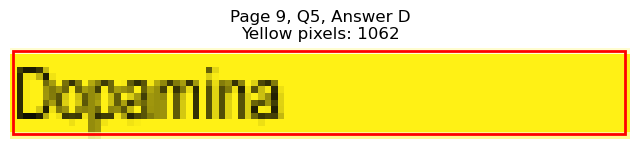

Page 9, Q5 - E: Detected box: x0=327.0, y0=455.5, x1=368.2, y1=468.1
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 223
Page 9, Q5, E: Yellow percentage: 0.0%


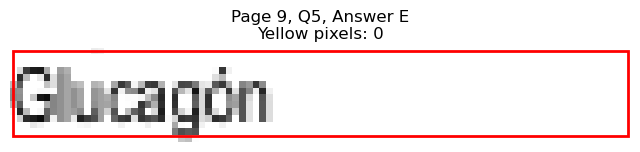


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=518.6, x1=108.4, y1=531.2
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 207
Page 9, Q6, A: Yellow percentage: 0.0%


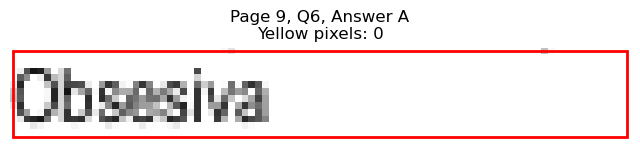

Page 9, Q6 - B: Detected box: x0=68.3, y0=531.2, x1=141.5, y1=543.8
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 393
Page 9, Q6, B: Yellow percentage: 0.0%


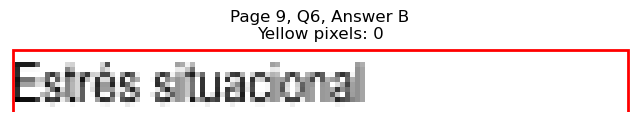

Page 9, Q6 - C: Detected box: x0=68.8, y0=543.8, x1=119.4, y1=556.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 250
Page 9, Q6, C: Yellow percentage: 0.0%


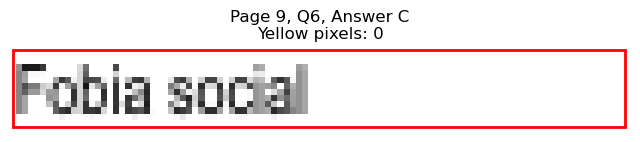

Page 9, Q6 - D: Detected box: x0=327.5, y0=518.6, x1=398.7, y1=531.2
Page 9, Q6, D: Yellow pixels: 1303
Page 9, Q6, D: Total non-white pixels: 1708
Page 9, Q6, D: Yellow percentage: 76.3%


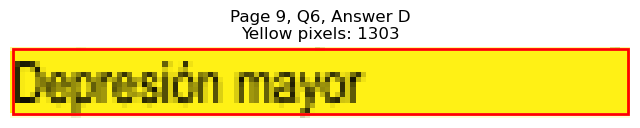

Page 9, Q6 - E: Detected box: x0=327.0, y0=531.2, x1=400.7, y1=543.8
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 505
Page 9, Q6, E: Yellow percentage: 0.0%


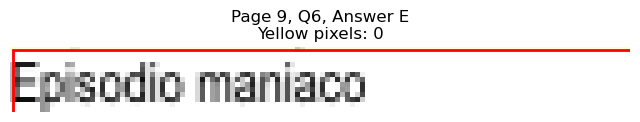


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=619.6, x1=191.2, y1=632.3
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 635
Page 9, Q7, A: Yellow percentage: 0.0%


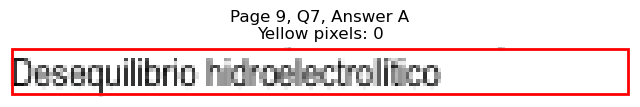

Page 9, Q7 - B: Detected box: x0=68.3, y0=632.2, x1=143.1, y1=644.9
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 387
Page 9, Q7, B: Yellow percentage: 0.0%


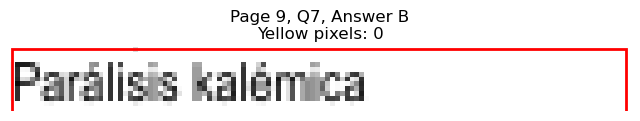

Page 9, Q7 - C: Detected box: x0=68.8, y0=644.9, x1=124.0, y1=657.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 289
Page 9, Q7, C: Yellow percentage: 0.0%


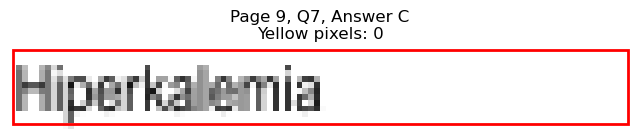

Page 9, Q7 - D: Detected box: x0=327.5, y0=619.6, x1=388.7, y1=632.3
Page 9, Q7, D: Yellow pixels: 112
Page 9, Q7, D: Total non-white pixels: 412
Page 9, Q7, D: Yellow percentage: 27.2%


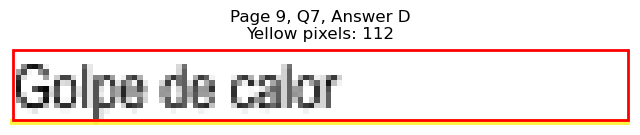

Page 9, Q7 - E: Detected box: x0=327.0, y0=632.2, x1=385.7, y1=644.9
Page 9, Q7, E: Yellow pixels: 1175
Page 9, Q7, E: Total non-white pixels: 1417
Page 9, Q7, E: Yellow percentage: 82.9%


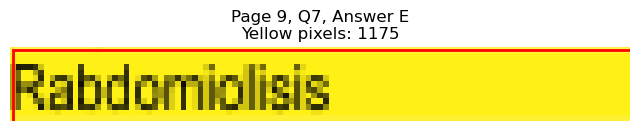


Page 9, Q7 - Selected Answer: E (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=720.6, x1=185.2, y1=733.2
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 578
Page 9, Q8, A: Yellow percentage: 0.0%


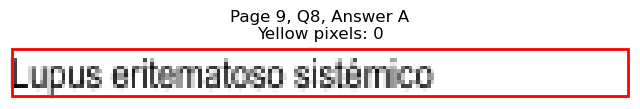

Page 9, Q8 - B: Detected box: x0=68.3, y0=733.2, x1=139.5, y1=745.8
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 479
Page 9, Q8, B: Yellow percentage: 0.0%


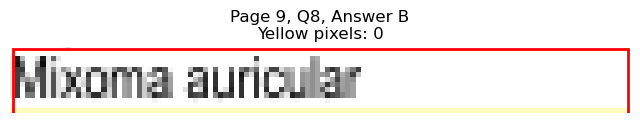

Page 9, Q8 - C: Detected box: x0=68.8, y0=745.8, x1=163.6, y1=758.4
Page 9, Q8, C: Yellow pixels: 1526
Page 9, Q8, C: Total non-white pixels: 2044
Page 9, Q8, C: Yellow percentage: 74.7%


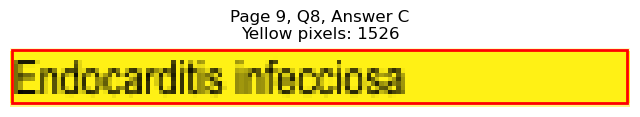

Page 9, Q8 - D: Detected box: x0=327.5, y0=720.6, x1=397.7, y1=733.2
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 360
Page 9, Q8, D: Yellow percentage: 0.0%


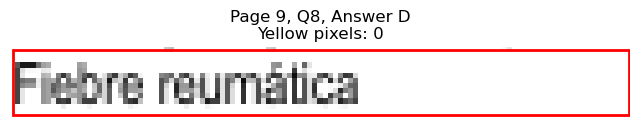

Page 9, Q8 - E: Detected box: x0=327.0, y0=733.2, x1=438.9, y1=745.8
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 624
Page 9, Q8, E: Yellow percentage: 0.0%


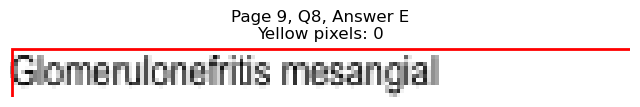


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 7 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=127.9, y1=139.9
Page 10, Q1, A: Yellow pixels: 1189
Page 10, Q1, A: Total non-white pixels: 1430
Page 10, Q1, A: Yellow percentage: 83.1%


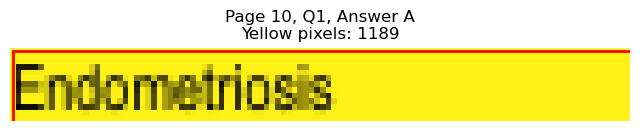

Page 10, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=122.4, y1=152.6
Page 10, Q1, B: Yellow pixels: 105
Page 10, Q1, B: Total non-white pixels: 386
Page 10, Q1, B: Yellow percentage: 27.2%


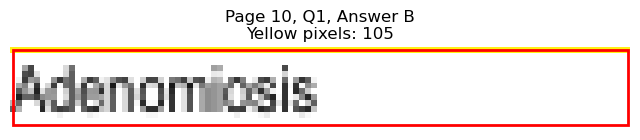

Page 10, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=116.9, y1=165.2
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 267
Page 10, Q1, C: Yellow percentage: 0.0%


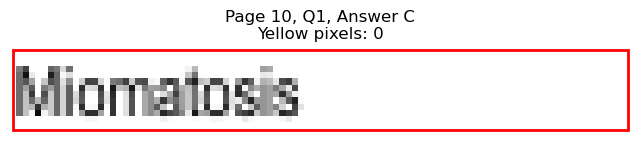

Page 10, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=458.9, y1=139.9
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 681
Page 10, Q1, D: Yellow percentage: 0.0%


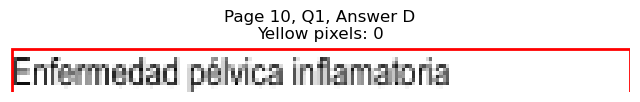

Page 10, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=463.5, y1=152.6
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 680
Page 10, Q1, E: Yellow percentage: 0.0%


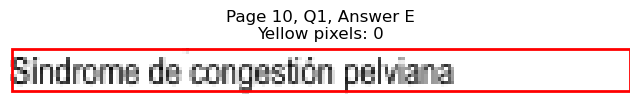


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=215.7, x1=152.5, y1=228.3
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 434
Page 10, Q2, A: Yellow percentage: 0.0%


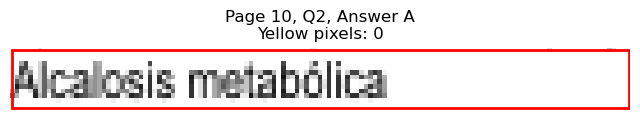

Page 10, Q2 - B: Detected box: x0=68.3, y0=228.3, x1=150.5, y1=240.9
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 547
Page 10, Q2, B: Yellow percentage: 0.0%


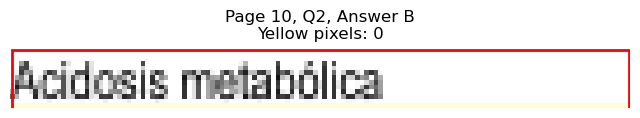

Page 10, Q2 - C: Detected box: x0=68.8, y0=240.9, x1=152.5, y1=253.5
Page 10, Q2, C: Yellow pixels: 1414
Page 10, Q2, C: Total non-white pixels: 1890
Page 10, Q2, C: Yellow percentage: 74.8%


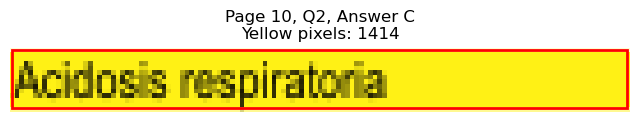

Page 10, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=387.7, y1=228.3
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 301
Page 10, Q2, D: Yellow percentage: 0.0%


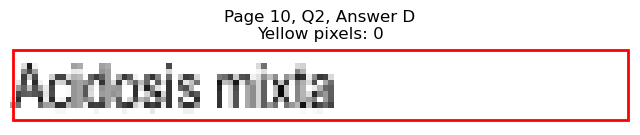

Page 10, Q2 - E: Detected box: x0=327.0, y0=228.3, x1=412.9, y1=240.9
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 462
Page 10, Q2, E: Yellow percentage: 0.0%


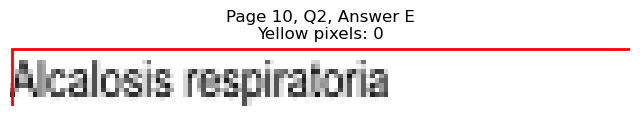


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=316.6, x1=137.5, y1=329.3
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 367
Page 10, Q3, A: Yellow percentage: 0.0%


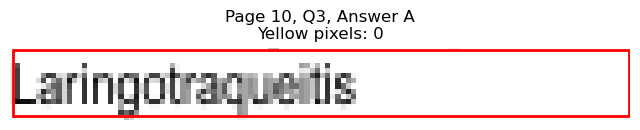

Page 10, Q3 - B: Detected box: x0=68.3, y0=329.2, x1=109.5, y1=341.9
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 242
Page 10, Q3, B: Yellow percentage: 0.0%


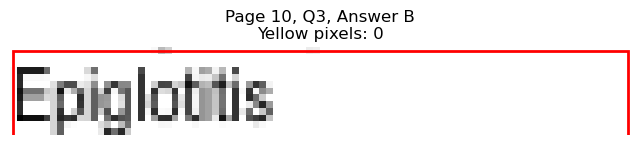

Page 10, Q3 - C: Detected box: x0=68.8, y0=341.9, x1=112.9, y1=354.6
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 236
Page 10, Q3, C: Yellow percentage: 0.0%


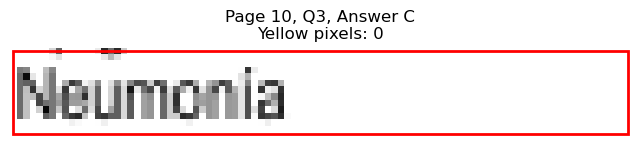

Page 10, Q3 - D: Detected box: x0=327.5, y0=316.6, x1=379.1, y1=329.3
Page 10, Q3, D: Yellow pixels: 103
Page 10, Q3, D: Total non-white pixels: 377
Page 10, Q3, D: Yellow percentage: 27.3%


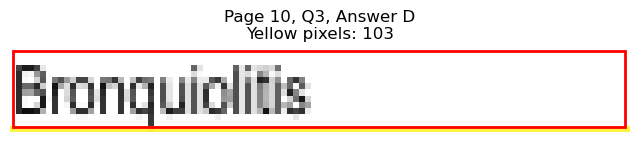

Page 10, Q3 - E: Detected box: x0=327.0, y0=329.2, x1=369.7, y1=341.9
Page 10, Q3, E: Yellow pixels: 1046
Page 10, Q3, E: Total non-white pixels: 1209
Page 10, Q3, E: Yellow percentage: 86.5%


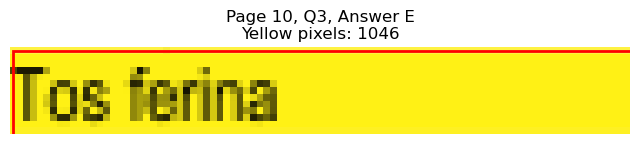


Page 10, Q3 - Selected Answer: E (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=417.6, x1=104.4, y1=430.3
Page 10, Q4, A: Yellow pixels: 894
Page 10, Q4, A: Total non-white pixels: 1218
Page 10, Q4, A: Yellow percentage: 73.4%


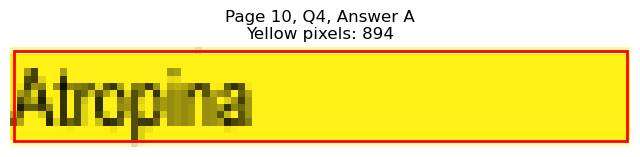

Page 10, Q4 - B: Detected box: x0=68.3, y0=430.2, x1=121.0, y1=442.9
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 377
Page 10, Q4, B: Yellow percentage: 0.0%


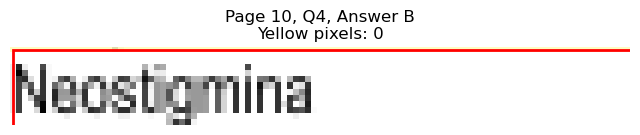

Page 10, Q4 - C: Detected box: x0=68.8, y0=442.8, x1=115.9, y1=455.5
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 230
Page 10, Q4, C: Yellow percentage: 0.0%


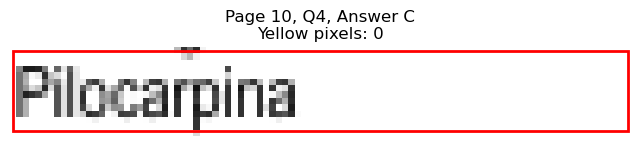

Page 10, Q4 - D: Detected box: x0=327.5, y0=417.6, x1=362.7, y1=430.3
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 194
Page 10, Q4, D: Yellow percentage: 0.0%


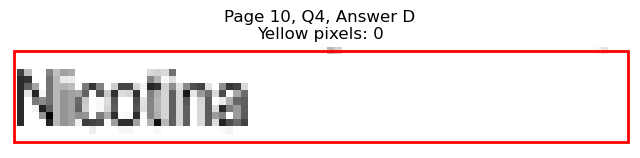

Page 10, Q4 - E: Detected box: x0=327.0, y0=430.2, x1=368.2, y1=442.9
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 210
Page 10, Q4, E: Yellow percentage: 0.0%


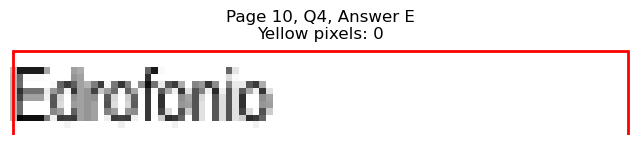


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=506.0, x1=178.1, y1=518.6
Page 10, Q5, A: Yellow pixels: 161
Page 10, Q5, A: Total non-white pixels: 706
Page 10, Q5, A: Yellow percentage: 22.8%


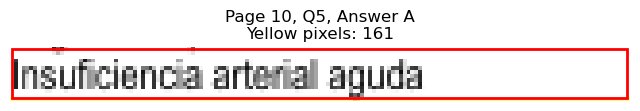

Page 10, Q5 - B: Detected box: x0=68.3, y0=518.6, x1=182.7, y1=531.2
Page 10, Q5, B: Yellow pixels: 1705
Page 10, Q5, B: Total non-white pixels: 2310
Page 10, Q5, B: Yellow percentage: 73.8%


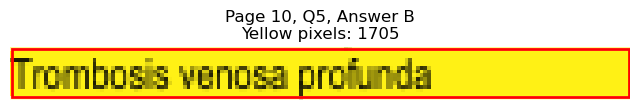

Page 10, Q5 - C: Detected box: x0=68.8, y0=531.2, x1=102.9, y1=543.8
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 271
Page 10, Q5, C: Yellow percentage: 0.0%


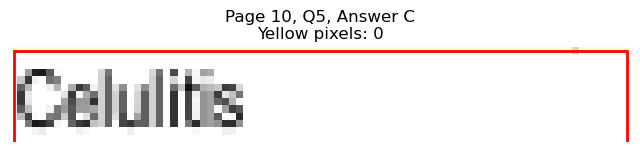

Page 10, Q5 - D: Detected box: x0=327.5, y0=506.0, x1=454.5, y1=518.6
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 629
Page 10, Q5, D: Yellow percentage: 0.0%


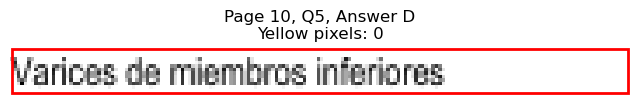

Page 10, Q5 - E: Detected box: x0=327.0, y0=518.6, x1=401.8, y1=531.2
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 379
Page 10, Q5, E: Yellow percentage: 0.0%


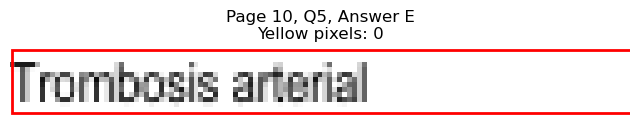


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=581.7, x1=144.0, y1=594.4
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 377
Page 10, Q6, A: Yellow percentage: 0.0%


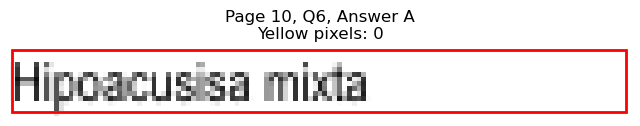

Page 10, Q6 - B: Detected box: x0=68.3, y0=594.3, x1=189.6, y1=607.0
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 586
Page 10, Q6, B: Yellow percentage: 0.0%


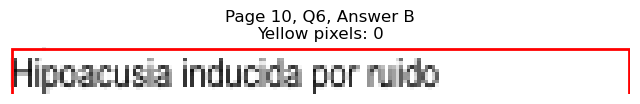

Page 10, Q6 - C: Detected box: x0=68.8, y0=606.9, x1=138.0, y1=619.6
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 342
Page 10, Q6, C: Yellow percentage: 0.0%


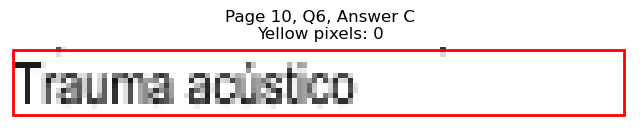

Page 10, Q6 - D: Detected box: x0=327.5, y0=581.7, x1=436.4, y1=594.4
Page 10, Q6, D: Yellow pixels: 160
Page 10, Q6, D: Total non-white pixels: 732
Page 10, Q6, D: Yellow percentage: 21.9%


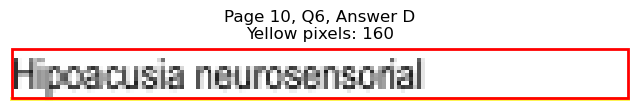

Page 10, Q6 - E: Detected box: x0=327.0, y0=594.3, x1=434.9, y1=607.0
Page 10, Q6, E: Yellow pixels: 1644
Page 10, Q6, E: Total non-white pixels: 2054
Page 10, Q6, E: Yellow percentage: 80.0%


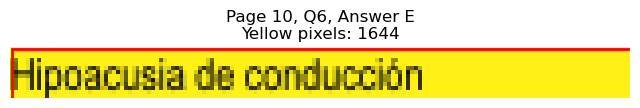


Page 10, Q6 - Selected Answer: E (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=670.1, x1=101.9, y1=682.7
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 155
Page 10, Q7, A: Yellow percentage: 0.0%


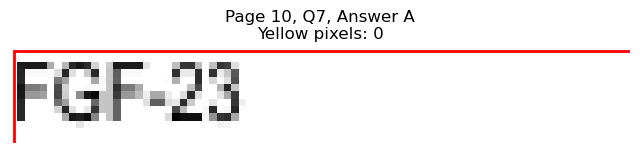

Page 10, Q7 - B: Detected box: x0=68.3, y0=682.7, x1=100.5, y1=695.3
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 167
Page 10, Q7, B: Yellow percentage: 0.0%


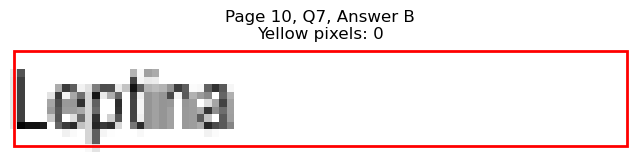

Page 10, Q7 - C: Detected box: x0=68.8, y0=695.4, x1=115.9, y1=708.0
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 230
Page 10, Q7, C: Yellow percentage: 0.0%


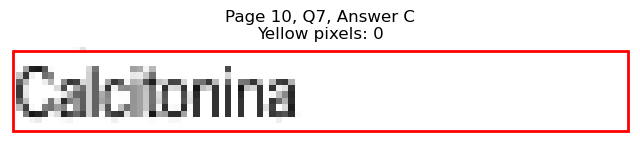

Page 10, Q7 - D: Detected box: x0=327.5, y0=670.1, x1=358.6, y1=682.7
Page 10, Q7, D: Yellow pixels: 931
Page 10, Q7, D: Total non-white pixels: 1066
Page 10, Q7, D: Yellow percentage: 87.3%


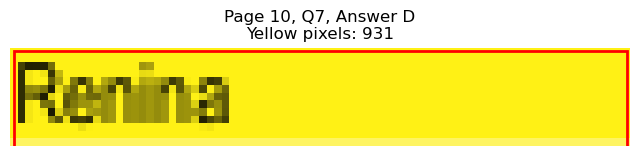

Page 10, Q7 - E: Detected box: x0=327.0, y0=682.7, x1=359.2, y1=695.3
Page 10, Q7, E: Yellow pixels: 83
Page 10, Q7, E: Total non-white pixels: 243
Page 10, Q7, E: Yellow percentage: 34.2%


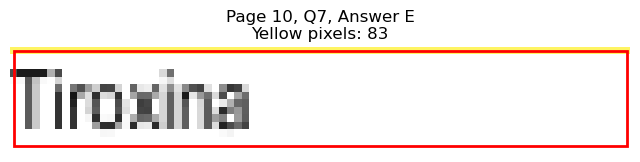


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=143.5, y1=139.9
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 375
Page 11, Q1, A: Yellow percentage: 0.0%


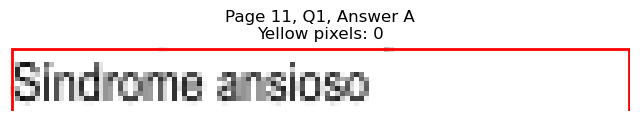

Page 11, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=100.3, y1=152.6
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 181
Page 11, Q1, B: Yellow percentage: 0.0%


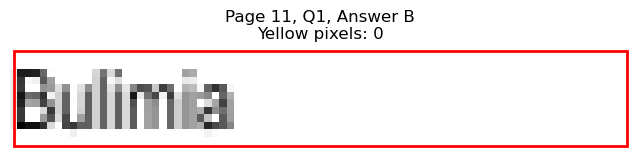

Page 11, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=135.0, y1=165.2
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 343
Page 11, Q1, C: Yellow percentage: 0.0%


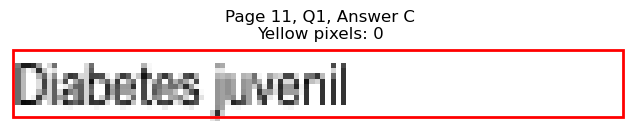

Page 11, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=402.3, y1=139.9
Page 11, Q1, D: Yellow pixels: 1369
Page 11, Q1, D: Total non-white pixels: 1638
Page 11, Q1, D: Yellow percentage: 83.6%


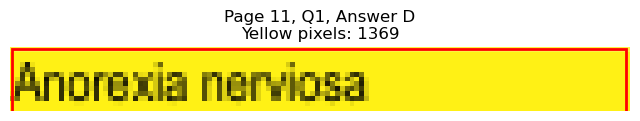

Page 11, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=389.7, y1=152.6
Page 11, Q1, E: Yellow pixels: 113
Page 11, Q1, E: Total non-white pixels: 443
Page 11, Q1, E: Yellow percentage: 25.5%


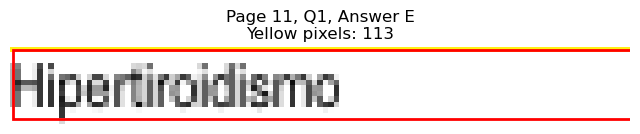


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=133.0, y1=203.0
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 314
Page 11, Q2, A: Yellow percentage: 0.0%


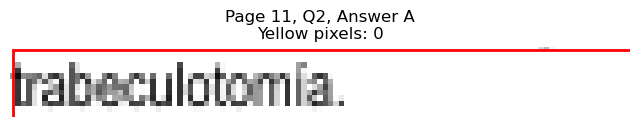

Page 11, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=152.5, y1=215.6
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 428
Page 11, Q2, B: Yellow percentage: 0.0%


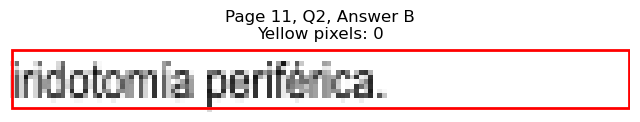

Page 11, Q2 - C: Detected box: x0=68.8, y0=215.7, x1=132.0, y1=228.3
Page 11, Q2, C: Yellow pixels: 1137
Page 11, Q2, C: Total non-white pixels: 1610
Page 11, Q2, C: Yellow percentage: 70.6%


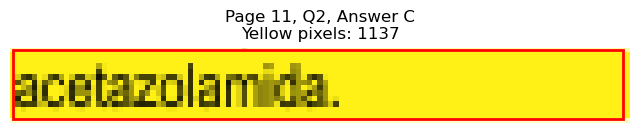

Page 11, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=384.2, y1=203.0
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 273
Page 11, Q2, D: Yellow percentage: 0.0%


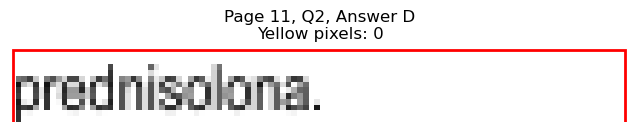

Page 11, Q2 - E: Detected box: x0=327.0, y0=202.9, x1=378.7, y1=215.6
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 265
Page 11, Q2, E: Yellow percentage: 0.0%


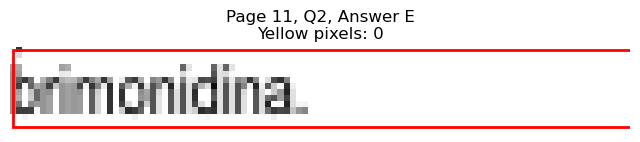


Page 11, Q2 - Selected Answer: C (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=169.6, y1=291.5
Page 11, Q3, A: Yellow pixels: 152
Page 11, Q3, A: Total non-white pixels: 668
Page 11, Q3, A: Yellow percentage: 22.8%


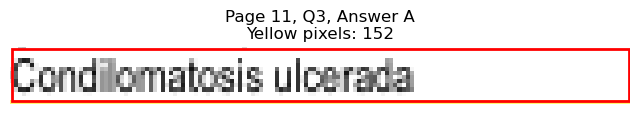

Page 11, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=127.5, y1=304.1
Page 11, Q3, B: Yellow pixels: 1180
Page 11, Q3, B: Total non-white pixels: 1540
Page 11, Q3, B: Yellow percentage: 76.6%


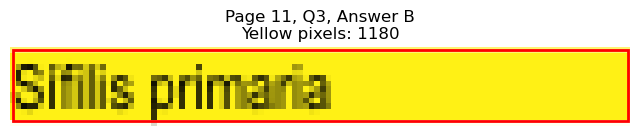

Page 11, Q3 - C: Detected box: x0=68.8, y0=304.0, x1=129.5, y1=316.7
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 427
Page 11, Q3, C: Yellow percentage: 0.0%


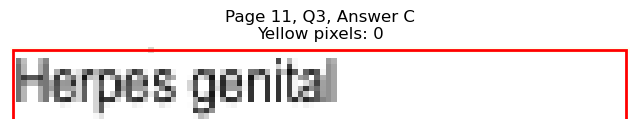

Page 11, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=376.1, y1=291.5
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 249
Page 11, Q3, D: Yellow percentage: 0.0%


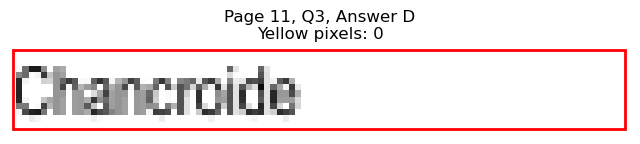

Page 11, Q3 - E: Detected box: x0=327.0, y0=291.4, x1=381.8, y1=304.1
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 272
Page 11, Q3, E: Yellow percentage: 0.0%


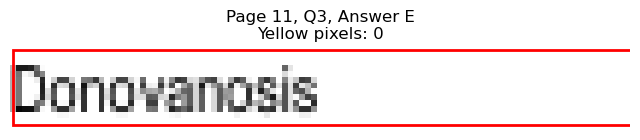


Page 11, Q3 - Selected Answer: B (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=118.0, y1=367.2
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 223
Page 11, Q4, A: Yellow percentage: 0.0%


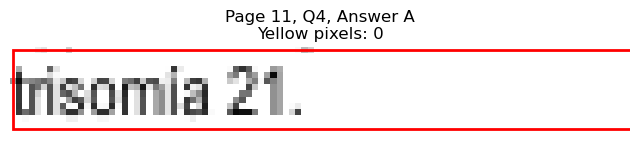

Page 11, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=187.2, y1=379.8
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 576
Page 11, Q4, B: Yellow percentage: 0.0%


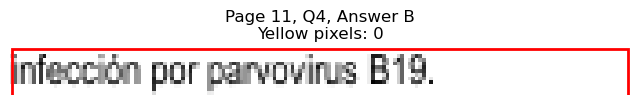

Page 11, Q4 - C: Detected box: x0=68.8, y0=379.7, x1=238.2, y1=392.4
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 858
Page 11, Q4, C: Yellow percentage: 0.0%


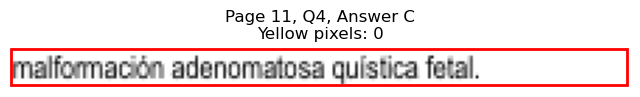

Page 11, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=382.3, y1=367.2
Page 11, Q4, D: Yellow pixels: 106
Page 11, Q4, D: Total non-white pixels: 362
Page 11, Q4, D: Yellow percentage: 29.3%


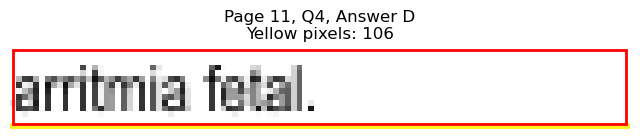

Page 11, Q4 - E: Detected box: x0=327.0, y0=367.1, x1=381.2, y1=379.8
Page 11, Q4, E: Yellow pixels: 1149
Page 11, Q4, E: Total non-white pixels: 1365
Page 11, Q4, E: Yellow percentage: 84.2%


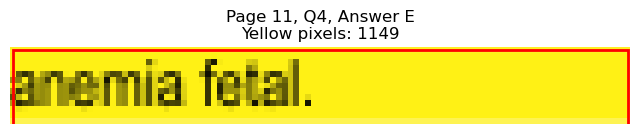


Page 11, Q4 - Selected Answer: E (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=68.3, y0=430.2, x1=142.6, y1=442.9
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 375
Page 11, Q5, A: Yellow percentage: 0.0%


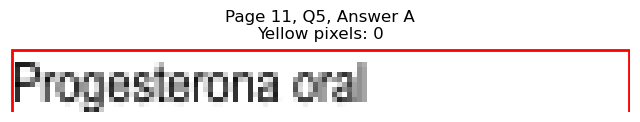

Page 11, Q5 - B: Detected box: x0=68.3, y0=442.8, x1=143.5, y1=455.5
Page 11, Q5, B: Yellow pixels: 126
Page 11, Q5, B: Total non-white pixels: 515
Page 11, Q5, B: Yellow percentage: 24.5%


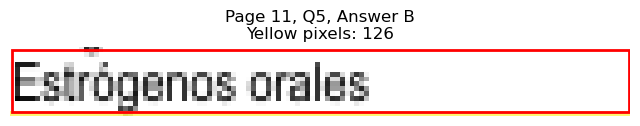

Page 11, Q5 - C: Detected box: x0=68.8, y0=455.5, x1=122.9, y1=468.1
Page 11, Q5, C: Yellow pixels: 1144
Page 11, Q5, C: Total non-white pixels: 1470
Page 11, Q5, C: Yellow percentage: 77.8%


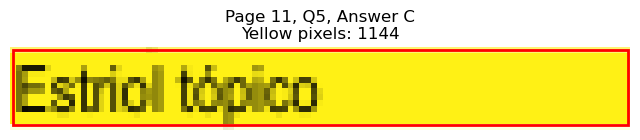

Page 11, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=475.5, y1=442.9
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 740
Page 11, Q5, D: Yellow percentage: 0.0%


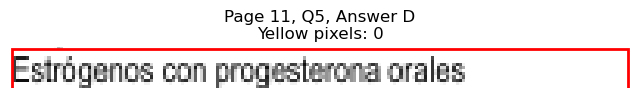

Page 11, Q5 - E: Detected box: x0=327.0, y0=442.8, x1=416.8, y1=455.5
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 492
Page 11, Q5, E: Yellow percentage: 0.0%


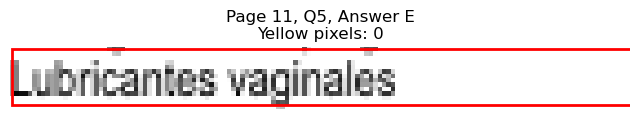


Page 11, Q5 - Selected Answer: C (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=68.3, y0=506.0, x1=175.6, y1=518.6
Page 11, Q6, A: Yellow pixels: 1645
Page 11, Q6, A: Total non-white pixels: 2212
Page 11, Q6, A: Yellow percentage: 74.4%


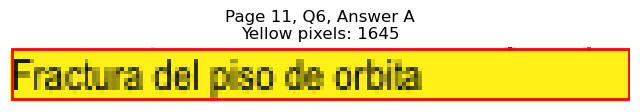

Page 11, Q6 - B: Detected box: x0=68.3, y0=518.6, x1=169.1, y1=531.2
Page 11, Q6, B: Yellow pixels: 152
Page 11, Q6, B: Total non-white pixels: 618
Page 11, Q6, B: Yellow percentage: 24.6%


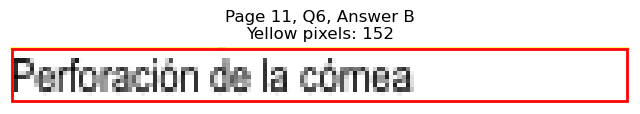

Page 11, Q6 - C: Detected box: x0=68.8, y0=531.2, x1=169.6, y1=543.8
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 505
Page 11, Q6, C: Yellow percentage: 0.0%


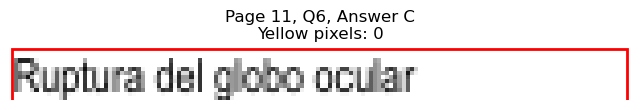

Page 11, Q6 - D: Detected box: x0=327.5, y0=506.0, x1=404.2, y1=518.6
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 386
Page 11, Q6, D: Yellow percentage: 0.0%


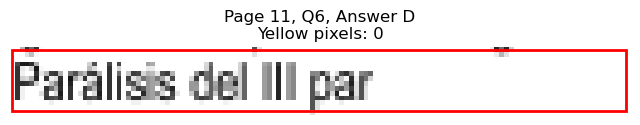

Page 11, Q6 - E: Detected box: x0=327.0, y0=518.6, x1=404.8, y1=531.2
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 391
Page 11, Q6, E: Yellow percentage: 0.0%


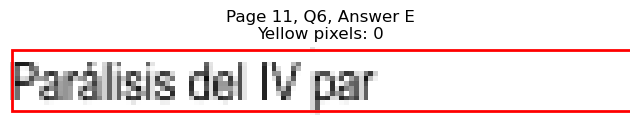


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=68.3, y0=581.7, x1=164.5, y1=594.4
Page 11, Q7, A: Yellow pixels: 1393
Page 11, Q7, A: Total non-white pixels: 2058
Page 11, Q7, A: Yellow percentage: 67.7%


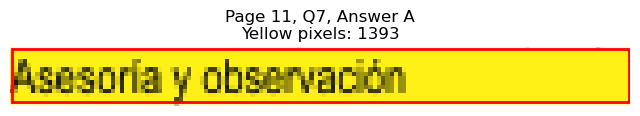

Page 11, Q7 - B: Detected box: x0=68.3, y0=594.3, x1=156.0, y1=607.0
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 585
Page 11, Q7, B: Yellow percentage: 0.0%


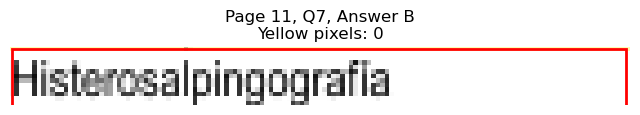

Page 11, Q7 - C: Detected box: x0=68.8, y0=606.9, x1=139.5, y1=619.6
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 366
Page 11, Q7, C: Yellow percentage: 0.0%


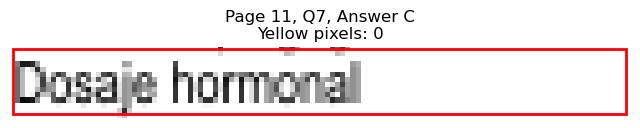

Page 11, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=419.8, y1=594.4
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 509
Page 11, Q7, D: Yellow percentage: 0.0%


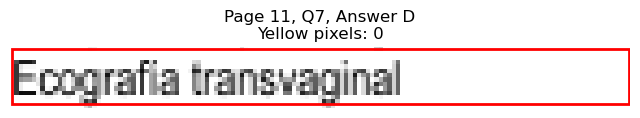

Page 11, Q7 - E: Detected box: x0=327.0, y0=594.3, x1=398.8, y1=607.0
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 369
Page 11, Q7, E: Yellow percentage: 0.0%


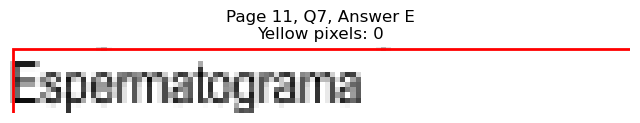


Page 11, Q7 - Selected Answer: A (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=68.3, y0=682.7, x1=163.6, y1=695.3
Page 11, Q8, A: Yellow pixels: 0
Page 11, Q8, A: Total non-white pixels: 471
Page 11, Q8, A: Yellow percentage: 0.0%


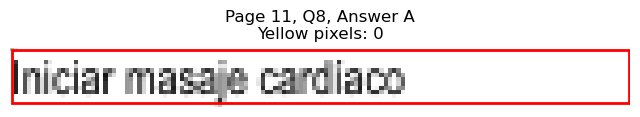

Page 11, Q8 - B: Detected box: x0=68.3, y0=695.4, x1=134.0, y1=708.0
Page 11, Q8, B: Yellow pixels: 0
Page 11, Q8, B: Total non-white pixels: 498
Page 11, Q8, B: Yellow percentage: 0.0%


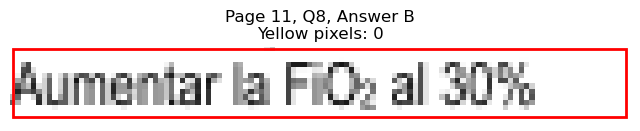

Page 11, Q8 - C: Detected box: x0=68.8, y0=708.0, x1=134.5, y1=720.6
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 488
Page 11, Q8, C: Yellow percentage: 0.0%


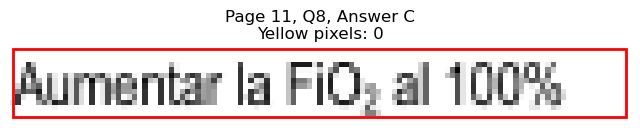

Page 11, Q8 - D: Detected box: x0=327.5, y0=682.7, x1=443.3, y1=695.3
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 605
Page 11, Q8, D: Yellow percentage: 0.0%


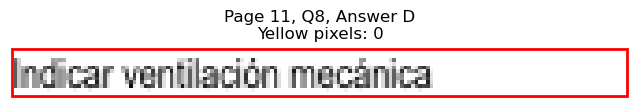

Page 11, Q8 - E: Detected box: x0=385.5, y0=695.4, x1=504.9, y1=708.0
Page 11, Q8, E: Yellow pixels: 1589
Page 11, Q8, E: Total non-white pixels: 2032
Page 11, Q8, E: Yellow percentage: 78.2%


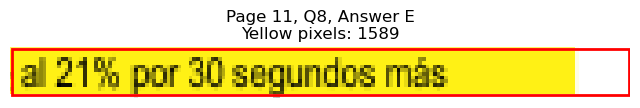


Page 11, Q8 - Selected Answer: E (based on yellow pixel count)





Page 12: Found 8 questions
Page 12, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=163.6, y1=139.9
Page 12, Q1, A: Yellow pixels: 0
Page 12, Q1, A: Total non-white pixels: 480
Page 12, Q1, A: Yellow percentage: 0.0%


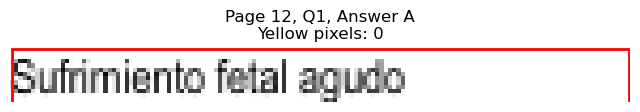

Page 12, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=146.1, y1=152.6
Page 12, Q1, B: Yellow pixels: 129
Page 12, Q1, B: Total non-white pixels: 531
Page 12, Q1, B: Yellow percentage: 24.3%


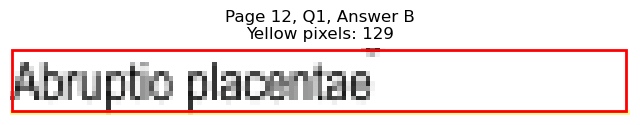

Page 12, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=149.5, y1=165.2
Page 12, Q1, C: Yellow pixels: 1400
Page 12, Q1, C: Total non-white pixels: 1848
Page 12, Q1, C: Yellow percentage: 75.8%


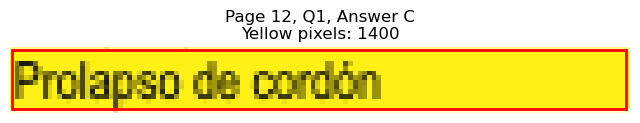

Page 12, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=413.8, y1=139.9
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 448
Page 12, Q1, D: Yellow percentage: 0.0%


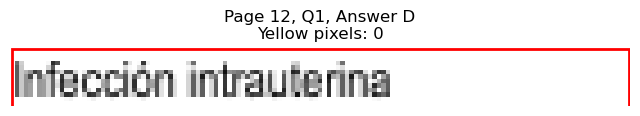

Page 12, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=391.7, y1=152.6
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 328
Page 12, Q1, E: Yellow percentage: 0.0%


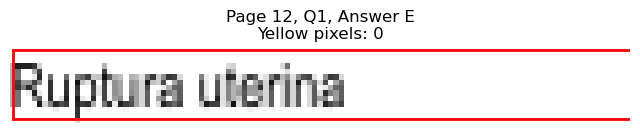


Page 12, Q1 - Selected Answer: C (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=68.3, y0=215.7, x1=171.6, y1=228.3
Page 12, Q2, A: Yellow pixels: 1411
Page 12, Q2, A: Total non-white pixels: 2156
Page 12, Q2, A: Yellow percentage: 65.4%


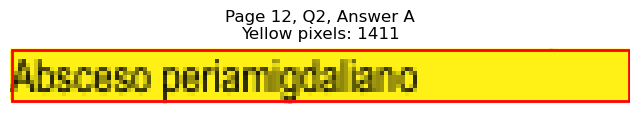

Page 12, Q2 - B: Detected box: x0=68.3, y0=228.3, x1=107.4, y1=240.9
Page 12, Q2, B: Yellow pixels: 0
Page 12, Q2, B: Total non-white pixels: 286
Page 12, Q2, B: Yellow percentage: 0.0%


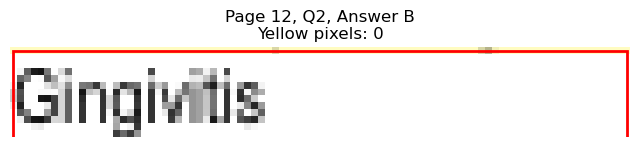

Page 12, Q2 - C: Detected box: x0=68.8, y0=240.9, x1=143.1, y1=253.5
Page 12, Q2, C: Yellow pixels: 0
Page 12, Q2, C: Total non-white pixels: 390
Page 12, Q2, C: Yellow percentage: 0.0%


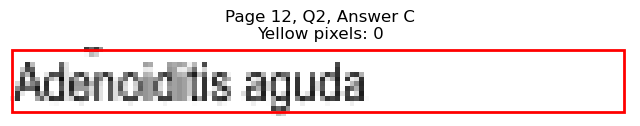

Page 12, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=401.8, y1=228.3
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 361
Page 12, Q2, D: Yellow percentage: 0.0%


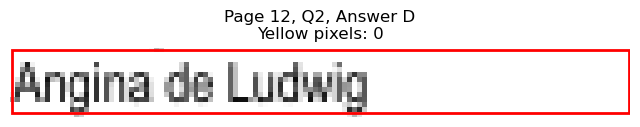

Page 12, Q2 - E: Detected box: x0=327.0, y0=228.3, x1=400.7, y1=240.9
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 405
Page 12, Q2, E: Yellow percentage: 0.0%


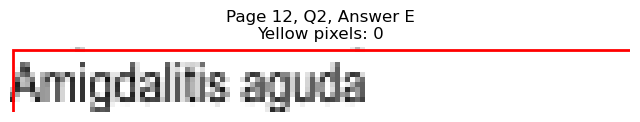


Page 12, Q2 - Selected Answer: A (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=56.6, y0=304.0, x1=65.2, y1=316.7
Page 12, Q3, A: Yellow pixels: 0
Page 12, Q3, A: Total non-white pixels: 46
Page 12, Q3, A: Yellow percentage: 0.0%


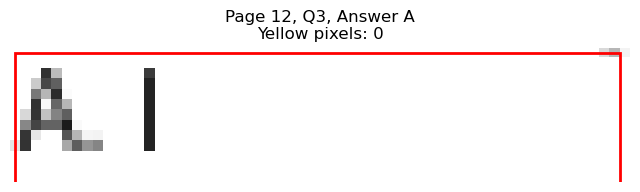

Page 12, Q3 - B: Detected box: x0=56.6, y0=316.6, x1=65.2, y1=329.3
Page 12, Q3, B: Yellow pixels: 0
Page 12, Q3, B: Total non-white pixels: 75
Page 12, Q3, B: Yellow percentage: 0.0%


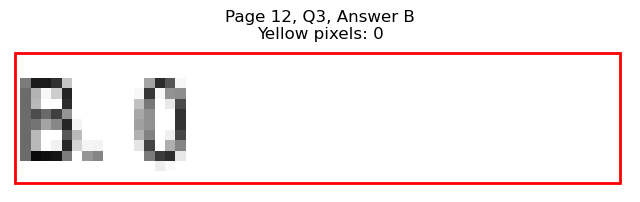

Page 12, Q3 - C: Detected box: x0=68.8, y0=329.2, x1=79.8, y1=341.9
Page 12, Q3, C: Yellow pixels: 0
Page 12, Q3, C: Total non-white pixels: 44
Page 12, Q3, C: Yellow percentage: 0.0%


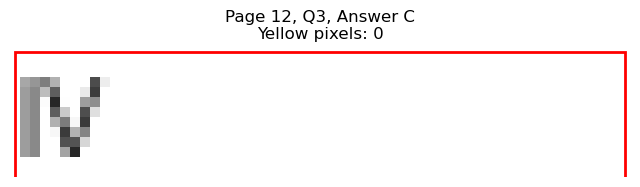

Page 12, Q3 - D: Detected box: x0=327.5, y0=304.0, x1=337.6, y1=316.7
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 112
Page 12, Q3, D: Yellow percentage: 0.0%


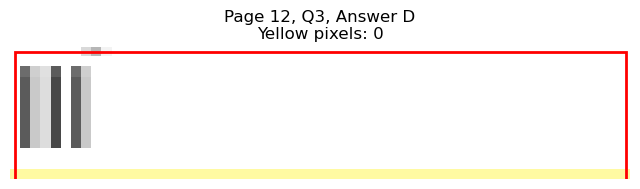

Page 12, Q3 - E: Detected box: x0=315.4, y0=316.6, x1=323.9, y1=329.3
Page 12, Q3, E: Yellow pixels: 658
Page 12, Q3, E: Total non-white pixels: 826
Page 12, Q3, E: Yellow percentage: 79.7%


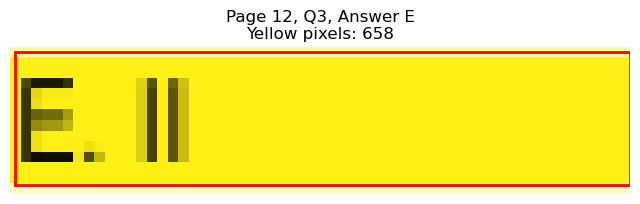


Page 12, Q3 - Selected Answer: E (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=68.3, y0=404.9, x1=154.6, y1=417.6
Page 12, Q4, A: Yellow pixels: 0
Page 12, Q4, A: Total non-white pixels: 443
Page 12, Q4, A: Yellow percentage: 0.0%


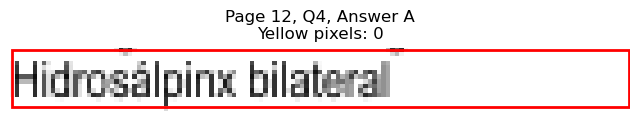

Page 12, Q4 - B: Detected box: x0=68.3, y0=417.6, x1=124.9, y1=430.3
Page 12, Q4, B: Yellow pixels: 107
Page 12, Q4, B: Total non-white pixels: 377
Page 12, Q4, B: Yellow percentage: 28.4%


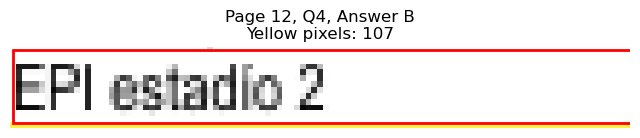

Page 12, Q4 - C: Detected box: x0=68.8, y0=430.2, x1=205.2, y1=442.9
Page 12, Q4, C: Yellow pixels: 1928
Page 12, Q4, C: Total non-white pixels: 2444
Page 12, Q4, C: Yellow percentage: 78.9%


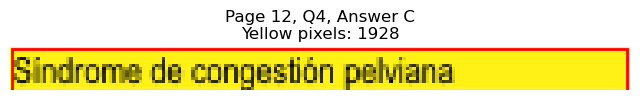

Page 12, Q4 - D: Detected box: x0=327.5, y0=404.9, x1=413.3, y1=417.6
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 438
Page 12, Q4, D: Yellow percentage: 0.0%


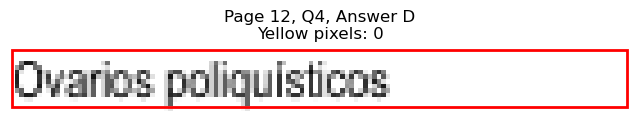

Page 12, Q4 - E: Detected box: x0=327.0, y0=417.6, x1=386.7, y1=430.3
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 327
Page 12, Q4, E: Yellow percentage: 0.0%


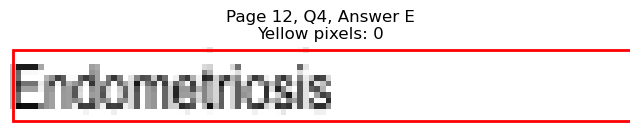


Page 12, Q4 - Selected Answer: C (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=68.3, y0=468.1, x1=119.4, y1=480.7
Page 12, Q5, A: Yellow pixels: 0
Page 12, Q5, A: Total non-white pixels: 257
Page 12, Q5, A: Yellow percentage: 0.0%


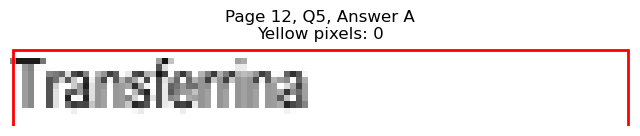

Page 12, Q5 - B: Detected box: x0=68.3, y0=480.8, x1=108.4, y1=493.4
Page 12, Q5, B: Yellow pixels: 0
Page 12, Q5, B: Total non-white pixels: 208
Page 12, Q5, B: Yellow percentage: 0.0%


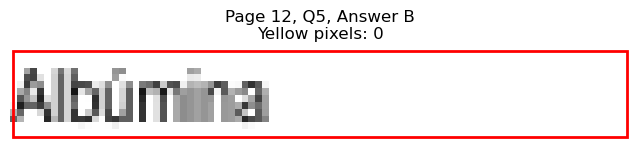

Page 12, Q5 - C: Detected box: x0=68.8, y0=493.4, x1=104.4, y1=506.0
Page 12, Q5, C: Yellow pixels: 0
Page 12, Q5, C: Total non-white pixels: 182
Page 12, Q5, C: Yellow percentage: 0.0%


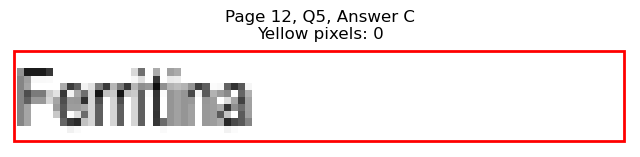

Page 12, Q5 - D: Detected box: x0=327.5, y0=468.1, x1=383.2, y1=480.7
Page 12, Q5, D: Yellow pixels: 0
Page 12, Q5, D: Total non-white pixels: 294
Page 12, Q5, D: Yellow percentage: 0.0%


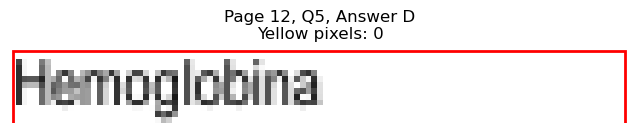

Page 12, Q5 - E: Detected box: x0=327.0, y0=480.8, x1=387.2, y1=493.4
Page 12, Q5, E: Yellow pixels: 1089
Page 12, Q5, E: Total non-white pixels: 1554
Page 12, Q5, E: Yellow percentage: 70.1%


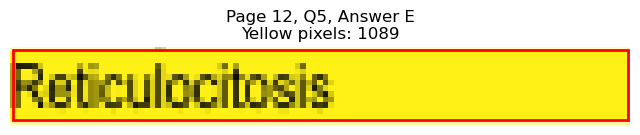


Page 12, Q5 - Selected Answer: E (based on yellow pixel count)




Page 12, Q6 - A: Detected box: x0=68.3, y0=531.2, x1=158.1, y1=543.8
Page 12, Q6, A: Yellow pixels: 0
Page 12, Q6, A: Total non-white pixels: 441
Page 12, Q6, A: Yellow percentage: 0.0%


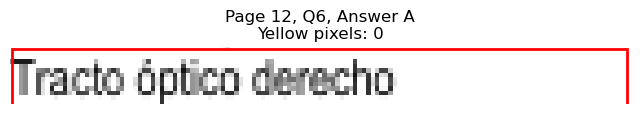

Page 12, Q6 - B: Detected box: x0=68.3, y0=543.8, x1=162.1, y1=556.4
Page 12, Q6, B: Yellow pixels: 0
Page 12, Q6, B: Total non-white pixels: 456
Page 12, Q6, B: Yellow percentage: 0.0%


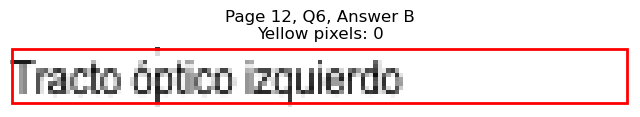

Page 12, Q6 - C: Detected box: x0=68.8, y0=556.5, x1=159.0, y1=569.2
Page 12, Q6, C: Yellow pixels: 1488
Page 12, Q6, C: Total non-white pixels: 1988
Page 12, Q6, C: Yellow percentage: 74.8%


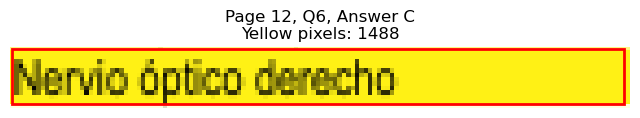

Page 12, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=421.9, y1=543.8
Page 12, Q6, D: Yellow pixels: 0
Page 12, Q6, D: Total non-white pixels: 468
Page 12, Q6, D: Yellow percentage: 0.0%


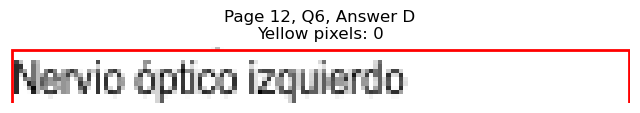

Page 12, Q6 - E: Detected box: x0=327.0, y0=543.8, x1=392.2, y1=556.4
Page 12, Q6, E: Yellow pixels: 0
Page 12, Q6, E: Total non-white pixels: 350
Page 12, Q6, E: Yellow percentage: 0.0%


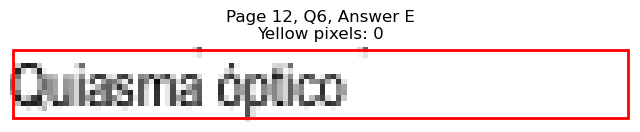


Page 12, Q6 - Selected Answer: C (based on yellow pixel count)




Page 12, Q7 - A: Detected box: x0=68.3, y0=606.9, x1=138.5, y1=619.6
Page 12, Q7, A: Yellow pixels: 0
Page 12, Q7, A: Total non-white pixels: 353
Page 12, Q7, A: Yellow percentage: 0.0%


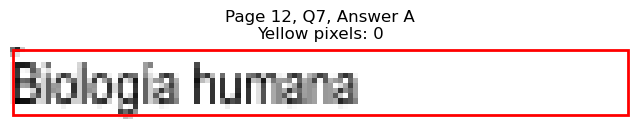

Page 12, Q7 - B: Detected box: x0=68.3, y0=619.6, x1=210.8, y1=632.3
Page 12, Q7, B: Yellow pixels: 0
Page 12, Q7, B: Total non-white pixels: 695
Page 12, Q7, B: Yellow percentage: 0.0%


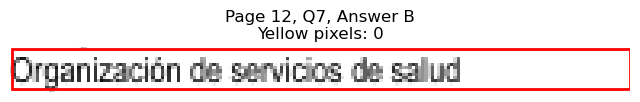

Page 12, Q7 - C: Detected box: x0=68.8, y0=632.2, x1=95.9, y1=644.9
Page 12, Q7, C: Yellow pixels: 0
Page 12, Q7, C: Total non-white pixels: 134
Page 12, Q7, C: Yellow percentage: 0.0%


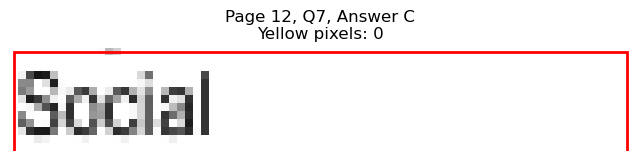

Page 12, Q7 - D: Detected box: x0=327.5, y0=606.9, x1=383.7, y1=619.6
Page 12, Q7, D: Yellow pixels: 1177
Page 12, Q7, D: Total non-white pixels: 1498
Page 12, Q7, D: Yellow percentage: 78.6%


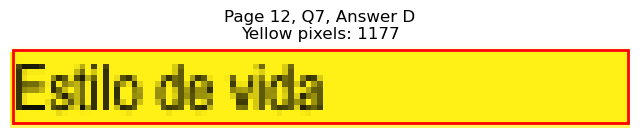

Page 12, Q7 - E: Detected box: x0=327.0, y0=619.6, x1=367.7, y1=632.3
Page 12, Q7, E: Yellow pixels: 91
Page 12, Q7, E: Total non-white pixels: 290
Page 12, Q7, E: Yellow percentage: 31.4%


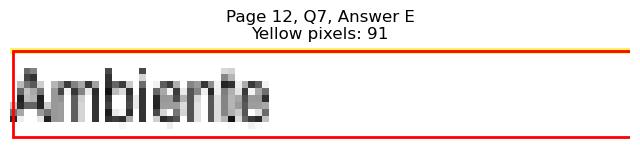


Page 12, Q7 - Selected Answer: D (based on yellow pixel count)




Page 12, Q8 - A: Detected box: x0=68.3, y0=708.0, x1=152.1, y1=720.6
Page 12, Q8, A: Yellow pixels: 1458
Page 12, Q8, A: Total non-white pixels: 1890
Page 12, Q8, A: Yellow percentage: 77.1%


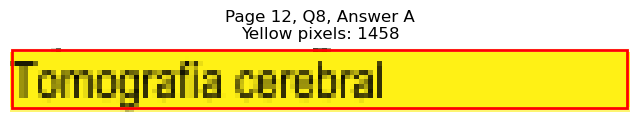

Page 12, Q8 - B: Detected box: x0=68.3, y0=720.6, x1=222.9, y1=733.2
Page 12, Q8, B: Yellow pixels: 203
Page 12, Q8, B: Total non-white pixels: 987
Page 12, Q8, B: Yellow percentage: 20.6%


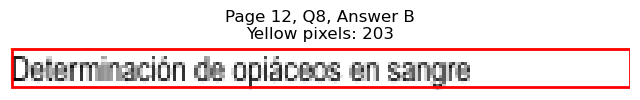

Page 12, Q8 - C: Detected box: x0=68.8, y0=733.2, x1=156.0, y1=745.8
Page 12, Q8, C: Yellow pixels: 0
Page 12, Q8, C: Total non-white pixels: 441
Page 12, Q8, C: Yellow percentage: 0.0%


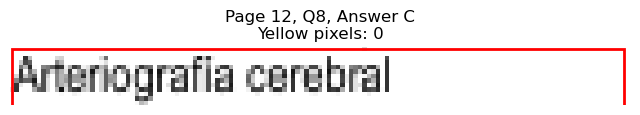

Page 12, Q8 - D: Detected box: x0=327.5, y0=708.0, x1=392.7, y1=720.6
Page 12, Q8, D: Yellow pixels: 0
Page 12, Q8, D: Total non-white pixels: 307
Page 12, Q8, D: Yellow percentage: 0.0%


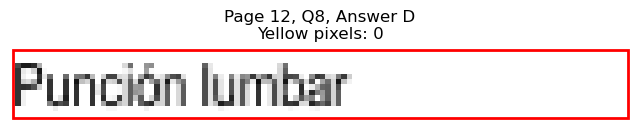

Page 12, Q8 - E: Detected box: x0=327.0, y0=720.6, x1=414.8, y1=733.2
Page 12, Q8, E: Yellow pixels: 0
Page 12, Q8, E: Total non-white pixels: 496
Page 12, Q8, E: Yellow percentage: 0.0%


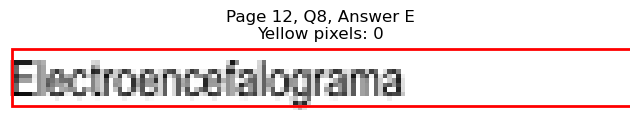


Page 12, Q8 - Selected Answer: A (based on yellow pixel count)





Page 13: Found 6 questions
Page 13, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=161.5, y1=114.7
Page 13, Q1, A: Yellow pixels: 0
Page 13, Q1, A: Total non-white pixels: 460
Page 13, Q1, A: Yellow percentage: 0.0%


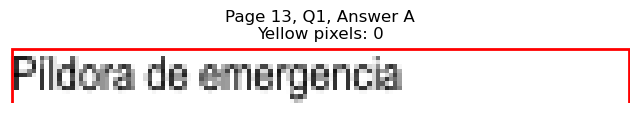

Page 13, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=235.8, y1=127.3
Page 13, Q1, B: Yellow pixels: 0
Page 13, Q1, B: Total non-white pixels: 864
Page 13, Q1, B: Yellow percentage: 0.0%


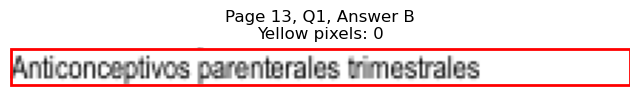

Page 13, Q1 - C: Detected box: x0=68.8, y0=127.2, x1=212.7, y1=139.9
Page 13, Q1, C: Yellow pixels: 0
Page 13, Q1, C: Total non-white pixels: 721
Page 13, Q1, C: Yellow percentage: 0.0%


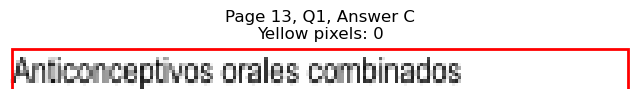

Page 13, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=492.1, y1=114.7
Page 13, Q1, D: Yellow pixels: 2
Page 13, Q1, D: Total non-white pixels: 1046
Page 13, Q1, D: Yellow percentage: 0.2%


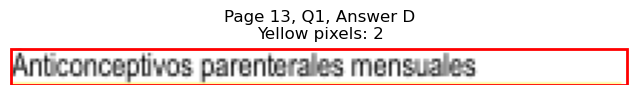

Page 13, Q1 - E: Detected box: x0=327.0, y0=114.6, x1=384.2, y1=127.3
Page 13, Q1, E: Yellow pixels: 1076
Page 13, Q1, E: Total non-white pixels: 1512
Page 13, Q1, E: Yellow percentage: 71.2%


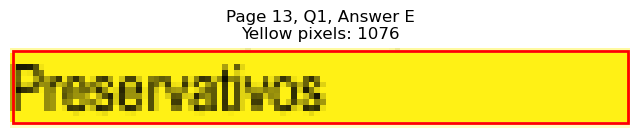


Page 13, Q1 - Selected Answer: E (based on yellow pixel count)




Page 13, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=282.4, y1=190.4
Page 13, Q2, A: Yellow pixels: 0
Page 13, Q2, A: Total non-white pixels: 1093
Page 13, Q2, A: Yellow percentage: 0.0%


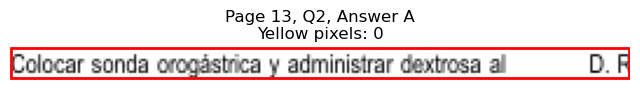

Page 13, Q2 - B: Detected box: x0=150.8, y0=202.9, x1=205.5, y1=215.6
Page 13, Q2, B: Yellow pixels: 0
Page 13, Q2, B: Total non-white pixels: 435
Page 13, Q2, B: Yellow percentage: 0.0%


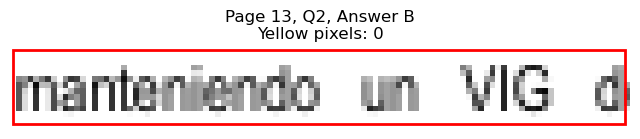

Page 13, Q2 - C: Detected box: x0=68.8, y0=228.3, x1=247.8, y1=240.9
Page 13, Q2, C: Yellow pixels: 0
Page 13, Q2, C: Total non-white pixels: 858
Page 13, Q2, C: Yellow percentage: 0.0%


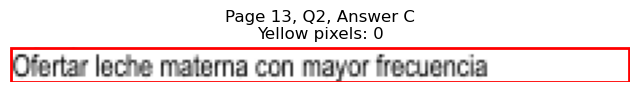

Page 13, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=541.0, y1=190.4
Page 13, Q2, D: Yellow pixels: 0
Page 13, Q2, D: Total non-white pixels: 1058
Page 13, Q2, D: Yellow percentage: 0.0%


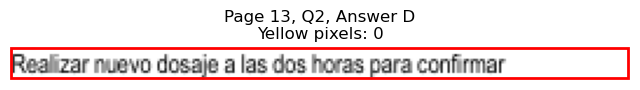

Page 13, Q2 - E: Detected box: x0=327.0, y0=202.9, x1=541.0, y1=215.6
Page 13, Q2, E: Yellow pixels: 2061
Page 13, Q2, E: Total non-white pixels: 2995
Page 13, Q2, E: Yellow percentage: 68.8%


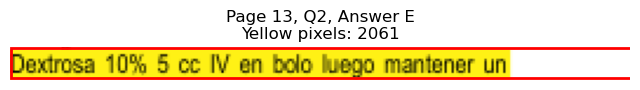


Page 13, Q2 - Selected Answer: E (based on yellow pixel count)




Page 13, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=124.9, y1=278.7
Page 13, Q3, A: Yellow pixels: 0
Page 13, Q3, A: Total non-white pixels: 265
Page 13, Q3, A: Yellow percentage: 0.0%


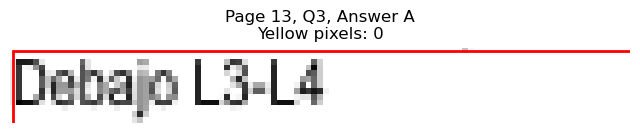

Page 13, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=147.0, y1=291.5
Page 13, Q3, B: Yellow pixels: 0
Page 13, Q3, B: Total non-white pixels: 387
Page 13, Q3, B: Yellow percentage: 0.0%


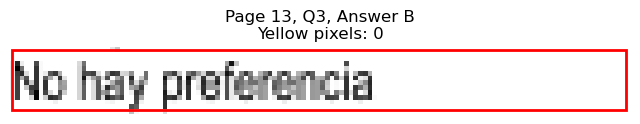

Page 13, Q3 - C: Detected box: x0=68.8, y0=291.4, x1=125.4, y1=304.1
Page 13, Q3, C: Yellow pixels: 0
Page 13, Q3, C: Total non-white pixels: 285
Page 13, Q3, C: Yellow percentage: 0.0%


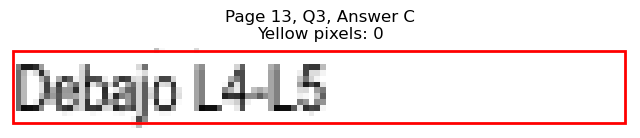

Page 13, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=405.8, y1=278.7
Page 13, Q3, D: Yellow pixels: 0
Page 13, Q3, D: Total non-white pixels: 388
Page 13, Q3, D: Yellow percentage: 0.0%


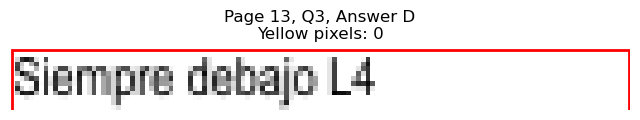

Page 13, Q3 - E: Detected box: x0=327.0, y0=278.8, x1=396.3, y1=291.5
Page 13, Q3, E: Yellow pixels: 1321
Page 13, Q3, E: Total non-white pixels: 1680
Page 13, Q3, E: Yellow percentage: 78.6%


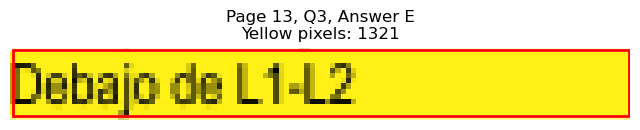


Page 13, Q3 - Selected Answer: E (based on yellow pixel count)




Page 13, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=190.2, y1=367.2
Page 13, Q4, A: Yellow pixels: 0
Page 13, Q4, A: Total non-white pixels: 584
Page 13, Q4, A: Yellow percentage: 0.0%


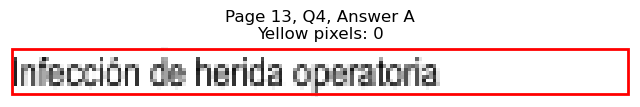

Page 13, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=101.4, y1=379.8
Page 13, Q4, B: Yellow pixels: 0
Page 13, Q4, B: Total non-white pixels: 194
Page 13, Q4, B: Yellow percentage: 0.0%


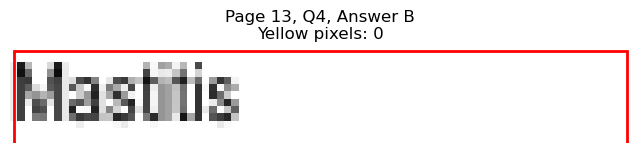

Page 13, Q4 - C: Detected box: x0=68.8, y0=379.7, x1=121.5, y1=392.4
Page 13, Q4, C: Yellow pixels: 0
Page 13, Q4, C: Total non-white pixels: 276
Page 13, Q4, C: Yellow percentage: 0.0%


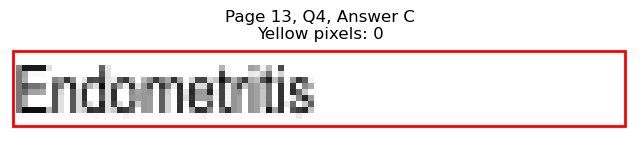

Page 13, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=414.3, y1=367.2
Page 13, Q4, D: Yellow pixels: 138
Page 13, Q4, D: Total non-white pixels: 600
Page 13, Q4, D: Yellow percentage: 23.0%


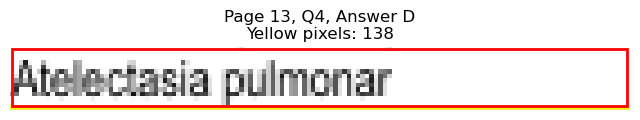

Page 13, Q4 - E: Detected box: x0=327.0, y0=367.1, x1=437.9, y1=379.8
Page 13, Q4, E: Yellow pixels: 1699
Page 13, Q4, E: Total non-white pixels: 2093
Page 13, Q4, E: Yellow percentage: 81.2%


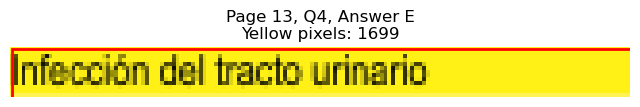


Page 13, Q4 - Selected Answer: E (based on yellow pixel count)




Page 13, Q5 - A: Detected box: x0=68.3, y0=430.2, x1=93.4, y1=442.9
Page 13, Q5, A: Yellow pixels: 891
Page 13, Q5, A: Total non-white pixels: 988
Page 13, Q5, A: Yellow percentage: 90.2%


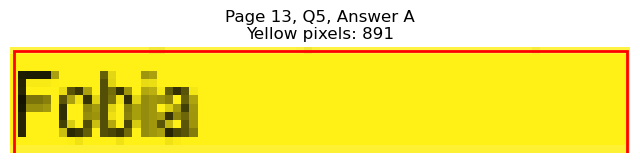

Page 13, Q5 - B: Detected box: x0=68.3, y0=442.8, x1=156.0, y1=455.5
Page 13, Q5, B: Yellow pixels: 139
Page 13, Q5, B: Total non-white pixels: 565
Page 13, Q5, B: Yellow percentage: 24.6%


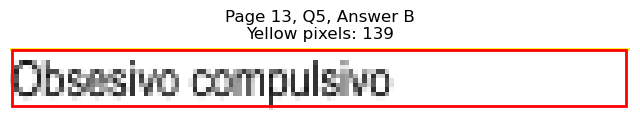

Page 13, Q5 - C: Detected box: x0=68.8, y0=455.5, x1=148.9, y1=468.1
Page 13, Q5, C: Yellow pixels: 0
Page 13, Q5, C: Total non-white pixels: 392
Page 13, Q5, C: Yellow percentage: 0.0%


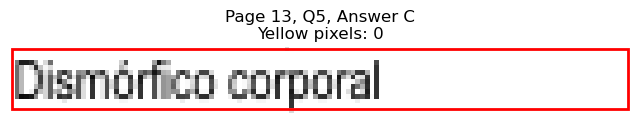

Page 13, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=390.3, y1=442.9
Page 13, Q5, D: Yellow pixels: 0
Page 13, Q5, D: Total non-white pixels: 307
Page 13, Q5, D: Yellow percentage: 0.0%


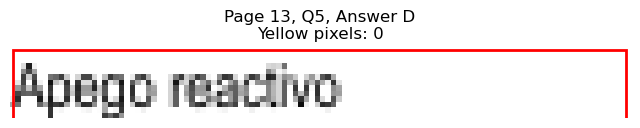

Page 13, Q5 - E: Detected box: x0=327.0, y0=442.8, x1=394.3, y1=455.5
Page 13, Q5, E: Yellow pixels: 0
Page 13, Q5, E: Total non-white pixels: 345
Page 13, Q5, E: Yellow percentage: 0.0%


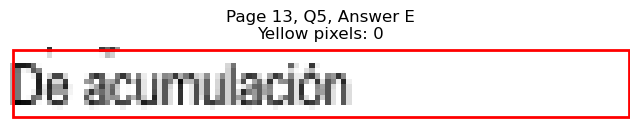


Page 13, Q5 - Selected Answer: A (based on yellow pixel count)




Page 13, Q6 - A: Detected box: x0=68.3, y0=506.0, x1=164.1, y1=518.6
Page 13, Q6, A: Yellow pixels: 0
Page 13, Q6, A: Total non-white pixels: 489
Page 13, Q6, A: Yellow percentage: 0.0%


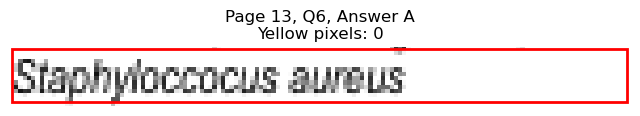

Page 13, Q6 - B: Detected box: x0=68.3, y0=518.6, x1=131.5, y1=531.2
Page 13, Q6, B: Yellow pixels: 0
Page 13, Q6, B: Total non-white pixels: 339
Page 13, Q6, B: Yellow percentage: 0.0%


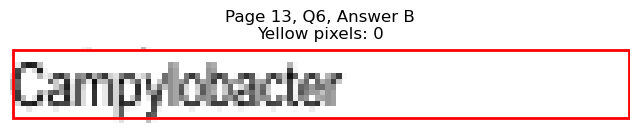

Page 13, Q6 - C: Detected box: x0=68.8, y0=531.2, x1=163.6, y1=543.8
Page 13, Q6, C: Yellow pixels: 0
Page 13, Q6, C: Total non-white pixels: 483
Page 13, Q6, C: Yellow percentage: 0.0%


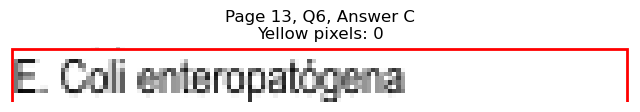

Page 13, Q6 - D: Detected box: x0=327.5, y0=506.0, x1=418.4, y1=518.6
Page 13, Q6, D: Yellow pixels: 1469
Page 13, Q6, D: Total non-white pixels: 1988
Page 13, Q6, D: Yellow percentage: 73.9%


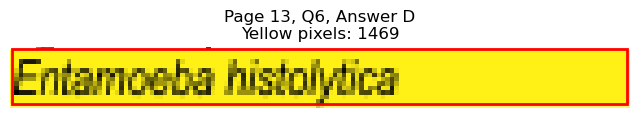

Page 13, Q6 - E: Detected box: x0=327.0, y0=518.6, x1=410.8, y1=531.2
Page 13, Q6, E: Yellow pixels: 133
Page 13, Q6, E: Total non-white pixels: 580
Page 13, Q6, E: Yellow percentage: 22.9%


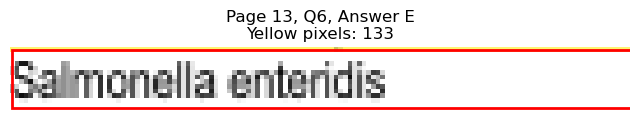


Page 13, Q6 - Selected Answer: D (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 50 años es llevado a emergencia por d...
1   ¿Cuál es el primer cuadro ocular que se presen...
2   Adolescente varón de 16 años, desde hace una s...
3   "La urgencia urinaria usualmente acompañada de...
4   ¿Cuál es el nivel de isquemia intestinal que a...
..                                                ...
95  Neonato a término, pequeño para edad gestacion...
96  ¿Cuál es el nivel de inyección de preferencia ...
97  Paciente en su segundo día posoperada de una c...
98  Mujer de 28 años, que presenta un temor acusad...
99  Varón de 35 años, presenta hace 15 días dolor ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                       Acetazolamida   
1                                          Queratitis   
2                                Neiseria gonorrhoeae   
3                              Hipermovilidad uretral   
4          Yeyuno hasta colon ascendente o transverso   
..                                                ...   
95  Colocar sonda orogástrica y administrar dextro...   
96                                       Debajo L3-L4   
97                     Infección de herida operatoria   
98                                              Fobia   
99                              Staphyloccocus aureus   

                                     option_B  \
0                                  Amlodipino   
1                                  Escleritis   
2                         Haemophilus ducreyi   
3                          Vejiga hiperactiva   
4                        Todo el marco cólico   
..                                        ...   
95  Dextrosa al 10% manteniendo un VIG de 6-8   
96                         No hay preferencia   
97                                   Mastitis   
98                        Obsesivo compulsivo   
99                              Campylobacter   

                                      option_C  \
0                                   Carvedilol   
1                        Conjuntivitis papilar   
2                          Virus herpes tipo 2   
3                          Vaciamiento anómalo   
4                       Todo el yeyuno e ileon   
..                                         ...   
95  Ofertar leche materna con mayor frecuencia   
96                                Debajo L4-L5   
97                                Endometritis   
98                         Dismórfico corporal   
99                      E. Coli enteropatógena   

                                             option_D  \
0                                     Espironolactona   
1                             Glaucoma ángulo cerrado   
2                                      Papiloma virus   
3                         Hiperactividad del detrusor   
4                   Ileon, colon derecho y transverso   
..                                                ...   
95  Realizar nuevo dosaje a las dos horas para con...   
96                                  Siempre debajo L4   
97                               Atelectasia pulmonar   
98                                     Apego reactivo   
99                              Entamoeba histolytica   

                                          option_E  
0                                  Hidroclotiazida  
1                          Glaucoma ángulo abierto  
2                               Treponema pallidum  
3                     Incontinencia urinaria mixta  
4                          Duodeno, yeyuno e ileon  
..                                             ...  
95  Dextrosa 10% 5 cc IV en bolo luego mantener un  
96                                 Debajo de L1-L2  
97                   Infección del tracto urinario  
98                                  De acumulación  
99                            Salmonella enteridis  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               E
1               C
2               A
3               B
4               A
..            ...
95              E
96              E
97              E
98              A
99              D

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Varón de 50 años es llevado a emergencia por d...   
1   ¿Cuál es el primer cuadro ocular que se presen...   
2   Adolescente varón de 16 años, desde hace una s...   
3   "La urgencia urinaria usualmente acompañada de...   
4   ¿Cuál es el nivel de isquemia intestinal que a...   
..                                                ...   
95  Neonato a término, pequeño para edad gestacion...   
96  ¿Cuál es el nivel de inyección de preferencia ...   
97  Paciente en su segundo día posoperada de una c...   
98  Mujer de 28 años, que presenta un temor acusad...   
99  Varón de 35 años, presenta hace 15 días dolor ...   

                                             option_A  \
0                                       Acetazolamida   
1                                          Queratitis   
2                                Neiseria gonorrhoeae   
3                              Hipermovilidad uretral   
4          Yeyuno hasta colon ascendente o transverso   
..                                                ...   
95  Colocar sonda orogástrica y administrar dextro...   
96                                       Debajo L3-L4   
97                     Infección de herida operatoria   
98                                              Fobia   
99                              Staphyloccocus aureus   

                                     option_B  \
0                                  Amlodipino   
1                                  Escleritis   
2                         Haemophilus ducreyi   
3                          Vejiga hiperactiva   
4                        Todo el marco cólico   
..                                        ...   
95  Dextrosa al 10% manteniendo un VIG de 6-8   
96                         No hay preferencia   
97                                   Mastitis   
98                        Obsesivo compulsivo   
99                              Campylobacter   

                                      option_C  \
0                                   Carvedilol   
1                        Conjuntivitis papilar   
2                          Virus herpes tipo 2   
3                          Vaciamiento anómalo   
4                       Todo el yeyuno e ileon   
..                                         ...   
95  Ofertar leche materna con mayor frecuencia   
96                                Debajo L4-L5   
97                                Endometritis   
98                         Dismórfico corporal   
99                      E. Coli enteropatógena   

                                             option_D  \
0                                     Espironolactona   
1                             Glaucoma ángulo cerrado   
2                                      Papiloma virus   
3                         Hiperactividad del detrusor   
4                   Ileon, colon derecho y transverso   
..                                                ...   
95  Realizar nuevo dosaje a las dos horas para con...   
96                                  Siempre debajo L4   
97                               Atelectasia pulmonar   
98                                     Apego reactivo   
99                              Entamoeba histolytica   

                                          option_E correct_answer  
0                                  Hidroclotiazida              E  
1                          Glaucoma ángulo abierto              C  
2                               Treponema pallidum              A  
3                     Incontinencia urinaria mixta              B  
4                          Duodeno, yeyuno e ileon              A  
..                                             ...            ...  
95  Dextrosa 10% 5 cc IV en bolo luego mantener un              E  
96                                 Debajo de L1-L2              E  
97                   Infección del tracto urinario              E  
98                                  De acumulación              A  
99                            Salmonella enteridis 

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2022/Especialidad Prueba B.csv
